In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils

# path to predictions folder (stored in repository by default)
# unexpected behavior might occur if you use another location
path = '/home/sareeves/thermostability-transfer'
preds_loc = os.path.join(path, 'data', 's669_mapped_preds_cluster.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [2]:
# load main data
db = pd.read_csv(preds_loc, index_col=0)
# don't assume that anything except the uids and predictions are in the preds file
db2 = pd.read_csv(os.path.join(path, 'data', 's669_mapped.csv'), index_col=0)
db2 = db2[[col for col in db2.columns if col not in db.columns]]
# join the predictions with the original S669 information
db = db.join(db2, how='right').reset_index().rename({'index': 'uid'}, axis=1)

# need a separate UID for methods which use the UniProt sequence
db['uid2'] = db['code'] + '_' + (db['position'].astype(int) - db['offset_up'].astype(int)).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])

# create and use a third index for matching with the S461 subset
db_full = db.copy(deep=True)
db_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]
db_full = db_full.reset_index().set_index('uid3')

# preprocess S461 to align with S669
s461 = pd.read_csv(os.path.join(path, 'data', 'S461.csv'))
s461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]
s461 = s461.set_index('uid3')
s461['ddG_I'] = -s461['ddG_D']
s461.columns = [s+'_dir' for s in s461.columns]
s461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)

# merge S669 with S461 (keeping predictions from both for comparison purposes)
db = s461.join(db_full, how='left').reset_index(drop=True).set_index(['uid', 'uid2'])

# reduce the dataframe to only include immediately relevant information
cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

# extract predictions
cols = db.columns
incl = [col for col in db.columns if ('_dir' in col) or ('_inv' in col)]
db_preds = db[incl].drop(['DDG_checked_dir', 'SEC_STR_dir', 'DDG_checked_inv', 'SEC_STR_inv', 'ddG_dir', 'ddG_inv'], axis=1)
db_preds = db_preds.drop([col for col in db_preds.columns if 'runtime_' in col], axis=1).drop_duplicates()

# keep some originally included features
db_feats = db[['code', 'multimer', 'TEMP', 'pH', 'SEC_STR_dir', 'SOL_ACC_dir']]

# use the S461 labels as the ground truth labels
ddgs = db[['code', 'ddG_dir', 'ddG_inv']]

# extract the runtimes for methods that have it (not currently used)
db_runtimes = db[[col for col in db.columns if 'runtime' in col]]

# sequence-based methods are naturally antisymmetric
db_preds['esm1v_median_inv'] = -db_preds['esm1v_median_dir']
db_preds['esm1v_mean_inv'] = -db_preds['esm1v_mean_dir']
db_preds['msa_transformer_median_inv'] = -db_preds['msa_transformer_median_dir']
db_preds['msa_transformer_mean_inv'] = -db_preds['msa_transformer_mean_dir']
db_preds['tranception_inv'] = -db_preds['tranception_dir']

# generate ProteinMPNN ensemble predictions
db_preds['mpnn_mean_dir'] = db_preds[['mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir']].mean(axis=1) 
db_runtimes['runtime_mpnn_mean_dir'] = db_runtimes[['runtime_mpnn_10_00_dir', 'runtime_mpnn_20_00_dir', 'runtime_mpnn_30_00_dir']].sum(axis=1)
db_preds['mpnn_mean_inv'] = db_preds[['mpnn_10_00_inv', 'mpnn_20_00_inv', 'mpnn_30_00_inv']].mean(axis=1)
db_runtimes['runtime_mpnn_mean_inv'] = db_runtimes[['runtime_mpnn_10_00_inv', 'runtime_mpnn_20_00_inv', 'runtime_mpnn_30_00_inv']].sum(axis=1)

db_preds = db_preds.reset_index(level=1)
db_preds

uid2  KORPMD_dir  CartddgD_dir  FoldXD_dir  EvoD_dir  \
uid                                                                    
1A0F_11A    1A0F_11A       0.138          1.45        0.48     -0.37   
1BA3_457D  1BA3_461D      -1.065         -4.47       -0.86     -0.77   
1BA3_485D  1BA3_489D       0.270          0.64       -0.13      0.96   
1BA3_485K  1BA3_489K       0.398          0.86        0.19      1.12   
1BA3_485M  1BA3_489M      -0.211         -1.08        0.30      1.42   
...              ...         ...           ...         ...       ...   
4HE7_19G    4HE7_19G      -0.249         -2.20       -0.04     -0.71   
4HE7_19K    4HE7_19K      -0.063          0.59        0.04      0.18   
5JXB_25G   5JXB_332G      -0.426         -4.72       -0.85     -0.53   
5JXB_25P   5JXB_332P      -0.930         -8.00       -0.97      0.42   
5OAQ_199H  5OAQ_429H      -2.512         -8.00       -3.64     -4.12   

           Dyna2D_dir  PopMsD_dir  DDGunD_dir  TNetD_dir  ACDCNND_dir  ...  \
uid                                                                    ...   
1A0F_11A        0.545       -1.04         0.5      0.021        0.225  ...   
1BA3_457D       0.160       -1.19        -1.2      0.123       -0.230  ...   
1BA3_485D      -0.193        0.07        -0.1      0.037       -0.040  ...   
1BA3_485K       0.190        0.26        -0.1      0.139        0.201  ...   
1BA3_485M      -0.138        0.29         0.0      0.169        0.231  ...   
...               ...         ...         ...        ...          ...  ...   
4HE7_19G       -0.133       -0.83        -0.4      0.106       -0.728  ...   
4HE7_19K       -0.119       -0.46        -0.3      0.657       -0.346  ...   
5JXB_25G        0.694       -0.05        -0.3      0.094       -0.134  ...   
5JXB_25P        0.390       -0.06        -0.2     -0.137        0.134  ...   
5OAQ_199H      -0.411       -2.46        -2.4     -0.230       -1.356  ...   

           tranception_dir  msa_transformer_mean_dir.1  \
uid                                                      
1A0F_11A         -0.017637                   -3.419950   
1BA3_457D        -0.008614                   -4.547824   
1BA3_485D         0.003210                    1.714401   
1BA3_485K         0.000465                    2.396171   
1BA3_485M        -0.008797                   -1.578121   
...                    ...                         ...   
4HE7_19G          0.027144                    0.689147   
4HE7_19K          0.021748                    0.887858   
5JXB_25G         -0.009617                   -9.815672   
5JXB_25P         -0.018131                  -15.911951   
5OAQ_199H        -0.038009                  -10.920754   

           msa_transformer_mean_new_dir  esm1v_median_inv  esm1v_mean_inv  \
uid                                                                         
1A0F_11A                      -3.581487          4.153863        4.624634   
1BA3_457D                     -5.651836          5.625221        5.599477   
1BA3_485D                      0.508530         -0.611018       -0.657705   
1BA3_485K                      2.809956         -2.775276       -2.805197   
1BA3_485M                     -0.904944          2.440030        2.319280   
...                                 ...               ...             ...   
4HE7_19G                       0.744890          0.132666       -0.003028   
4HE7_19K                       1.098679         -1.047024       -1.015891   
5JXB_25G                      -8.565118          8.438359        9.233605   
5JXB_25P                     -13.884424         15.578564       15.449700   
5OAQ_199H                    -10.987219          9.237511        8.655653   

           msa_transformer_median_inv  msa_transformer_mean_inv  \
uid                                                               
1A0F_11A                     3.382510                  3.477431   
1BA3_457D                    4.626297                  4.727912   
1BA3_485D                   -1.369567  

In [3]:
# our predictions are essentially identical to the original ones
print(db_preds[['korpm_dir', 'KORPMD_dir']].corr().iloc[1,0])
# failed prediction for only 1 entry with our pipeline
db_preds.loc[db_preds['korpm_dir'].isna()]

0.9964752348648677


uid2  KORPMD_dir  CartddgD_dir  FoldXD_dir  EvoD_dir  \
uid                                                                    
1R2Y_243E  1R2Y_243E      -1.721         -2.85       -2.59     -2.02   

           Dyna2D_dir  PopMsD_dir  DDGunD_dir  TNetD_dir  ACDCNND_dir  ...  \
uid                                                                    ...   
1R2Y_243E      -0.077       -0.86        -1.5      0.101       -0.608  ...   

           tranception_dir  msa_transformer_mean_dir.1  \
uid                                                      
1R2Y_243E        -0.019696                   -7.065342   

           msa_transformer_mean_new_dir  esm1v_median_inv  esm1v_mean_inv  \
uid                                                                         
1R2Y_243E                      -8.22869          5.753062        6.294906   

           msa_transformer_median_inv  msa_transformer_mean_inv  \
uid                                                               
1R2Y_243E                    6.103989                  5.892816   

           tranception_inv  mpnn_mean_dir  mpnn_mean_inv  
uid                                                       
1R2Y_243E         0.019696       -3.03854       2.828177  

[1 rows x 104 columns]

In [4]:
print('getting cartesian predictions')
# assuming you have designated the repo location as the path
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'rosetta_predictions'))
db_preds = db_preds.join(df_cart.astype(float), how='left')

#print('getting cartesian inverse predictions')
#df_cart_inv = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'rosetta_predictions'), inverse=True)
#db_preds = db_preds.join(df_cart_inv.astype(float), how='left')

db_preds = db_preds.reset_index().set_index(['uid', 'uid2'])

getting cartesian predictions


In [5]:
# our Rosetta predictions are not that stronly correlated to Hernandez et. al, although ours tend to perform better
print(db_preds[['CartddgD_dir', 'cartesian_ddg_dir']].corr().iloc[1,0])

0.767675817549726


                     korpm_dir  korpm_inv
uid       uid2                           
1A0F_11A  1A0F_11A       0.143     -0.268
1BA3_457D 1BA3_461D     -1.054      0.857
1BA3_485D 1BA3_489D      0.265      0.076
1BA3_485K 1BA3_489K      0.390     -0.127
1BA3_485M 1BA3_489M     -0.209      1.205
...                        ...        ...
4HE7_19G  4HE7_19G      -0.238      0.146
4HE7_19K  4HE7_19K      -0.064      0.127
5JXB_25G  5JXB_332G     -0.413     -0.109
5JXB_25P  5JXB_332P     -0.923      0.008
5OAQ_199H 5OAQ_429H     -2.722      1.419

[461 rows x 2 columns]
antisymmetry (should be close to -1) -0.8305201539288439
bias (should be close to 0) -0.029642391304347825


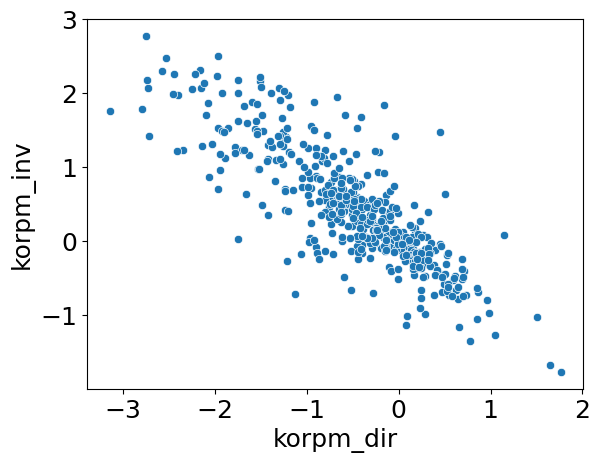

In [6]:
c1 = 'korpm_dir'
c2 = 'korpm_inv'

db_tmp = db_preds.copy()
print(db_tmp[[c1, c2]])
#db_tmp['code'] = db_tmp.reset_index(level=1).index.str[:4]
#db_tmp = db_tmp.loc[db_tmp['code']=='1A7V']
sns.scatterplot(data=db_tmp, x=c1, y=c2, legend=False)

print('antisymmetry (should be close to -1)', analysis_utils.antisymmetry(db_preds[c1], db_preds[c2]))
print('bias (should be close to 0)', analysis_utils.bias(db_preds[c1], db_preds[c2]))

In [7]:
db_complete = db_preds.copy(deep=True).reset_index()
db_complete = db_complete.set_index('uid')


neff = pd.read_csv(os.path.join(path, 'data', 'neff_s669.csv'), header=None).set_index(0) # todo / fix
neff.index.name = 'code'
neff.columns = ['neff']

db_feats_2 = pd.read_csv(os.path.join(path, 'data', 's669_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']
db_feats_2 = db_feats_2[['uid', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'nmr_xray', 'pH', 'resolution']] #'residue_depth',

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
db_complete = db_complete.join(ddgs)
db_complete = db_complete.join(db_feats_2.set_index('uid')).drop('code', axis=1).drop('uid2', axis=1).reset_index().drop('uid2', axis=1).set_index('uid')
db_complete['delta_kdh'] = db_complete['kdh_mut'] - db_complete['kdh_wt']
db_complete['delta_vol'] = db_complete['vol_mut'] - db_complete['vol_wt']
db_complete['delta_chg'] = db_complete['chg_mut'] - db_complete['chg_wt']
db_complete['delta_asa'] = db_complete['SOL_ACC_inv'] - db_complete['SOL_ACC_dir']
db_complete['to_proline'] = (db_complete.index.str[-1] == 'P').astype(int)
db_complete['to_glycine'] = (db_complete.index.str[-1] == 'G').astype(int)
db_complete['from_proline'] = db_complete['wild_type'] == 'P'
db_complete['from_glycine'] = db_complete['wild_type'] == 'G'
db_complete['helix'] = db_complete['SS'] == 'H'
db_complete['bend'] = db_complete['SS'] == 'S'
db_complete['turn'] = db_complete['SS'] == 'T'
db_complete['coil'] = db_complete['SS'] == '-'
db_complete['strand'] = db_complete['SS'] == 'E'
db_complete['xray_else_NMR'] = db_complete['nmr_xray'].str.contains('X-RAY')
db_complete['active_site'] = db_complete['features'].str.contains('ACT_SITE')
db_complete['resolution'] = db_complete['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))
#db_complete['mpnn_median_dir'] = db_complete[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_complete = db_complete.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type', 'nmr_xray'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_complete['code'] = db_complete.index.str[:4]
db_complete = db_complete.reset_index().merge(neff['neff'].dropna(), on='code', how='left')#.drop('code', axis=1)#.set_index('uid')
db_complete['neff'] = db_complete['neff'].fillna(0)
unique_indices = db_complete.groupby('uid')['neff'].idxmax()#.astype(int)
db_complete = db_complete.loc[unique_indices].set_index('uid')

db_complete['random_dir'] = np.random.rand(len(db_complete)) - 0.5
db_complete['random_inv'] = np.random.rand(len(db_complete)) - 0.5

# follow sign convention for DDG of unfolding (higher is less stable)
#db_complete['DDG_checked_dir'] *= -1
#db_complete['DDG_checked_inv'] *= -1

In [8]:
class_result = analysis_utils.compute_stats_bidirectional(db_complete.drop('code', axis=1), stats=())
#class_result.to_csv(os.path.join(path, 'results', 's461_summary_table.csv'))

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [9]:
# preview results
class_result.xs('dir')[['n', 'mean_stabilization', 'net_stabilization', 'mean_stable_pred', 'MCC',  '90$', 'weighted_spearman', 'weighted_ndcg']]

n  \
model_type   model                              class          
evolutionary ACDC-NN-Seq_dir                           461.0   
             DDGun3D_dir                               461.0   
             DDGunD_dir                                461.0   
             DDGun_dir                                 434.0   
             I-Mutant3.0-Seq_dir                       461.0   
             INPS-Seq_dir                              461.0   
             SAAFEC-Seq_dir                            461.0   
             esm1v_mean_dir                            461.0   
             esm1v_median_dir                          461.0   
             msa_transformer_mean_dir                  456.0   
             msa_transformer_mean_dir.1                448.0   
             msa_transformer_mean_new_dir              461.0   
             msa_transformer_median_dir                456.0   
             tranception_dir                           460.0   
hybrid       ACDC-NN_dir                               461.0   
             DUET_dir                                  461.0   
             Dynamut_dir                               461.0   
             I-Mutant3.0_dir                           461.0   
             INPS3D_dir                                461.0   
             MAESTRO_dir                               461.0   
             PremPS_dir                                461.0   
             SDM_dir                                   461.0   
structural   ACDCNND_dir                               461.0   
             CartddgD_dir                              461.0   
             Dyna2D_dir                                461.0   
             EvoD_dir                                  461.0   
             FoldXD_dir                                461.0   
             FoldX_dir                                 461.0   
             KORPMD_dir                                461.0   
             MuPro_dir                                 461.0   
             PopMsD_dir                                461.0   
             PopMusic_dir                              461.0   
             SOL_ACC_dir                               461.0   
             TNetD_dir                                 461.0   
             ThermoNet_dir                             461.0   
             cartesian_ddg_dir                         461.0   
             ddG_dir                                   461.0   
             esmif_monomer_dir                         461.0   
             esmif_monomer_full__dir                   461.0   
             esmif_monomer_full_dir                    461.0   
             esmif_multimer_dir                        461.0   
             esmif_multimer_full__dir                  461.0   
             esmif_multimer_full_dir                   461.0   
             esmif_multimer_full_masked_dir            461.0   
             korpm_dir                                 460.0   
             mCSM_dir                                  461.0   
             mif_dir                                   461.0   
             mifst_dir                                 461.0   
             mpnn_10_00_dir                            461.0   
             mpnn_20_001_dir                           461.0   
             mpnn_20_002_dir                           461.0   
             mpnn_20_003_dir                           461.0   
             mpnn_20_004_dir                           461.0   
             mpnn_20_005_dir                           461.0   
             mpnn_20_00_dir                            461.0   
             mpnn_20_02_dir                            461.0   
             mpnn_30_00_dir                            461.0   
             mpnn_30_028_dir                           461.0   
             mpnn_30_029_dir                           461.0   
             mpnn_30_031_dir                           461.0   
             mpnn_30_032_dir                           461.0   
             mpnn_30_03_dir

In [10]:
class_result.sort_values('weighted_ndcg', ascending=False)['weighted_ndcg'].head(20)

direction  model_type    model                   class
combined   structural    ddG                              1.000000
dir        structural    ddG_dir                          1.000000
inv        structural    ddG_inv                          1.000000
combined   hybrid        PremPS                           0.938580
           structural    mpnn_30_00                       0.938333
                         korpm                            0.932971
                         mpnn_mean                        0.932942
                         mifst                            0.932261
           evolutionary  msa_transformer_mean             0.931565
                         msa_transformer_median           0.931107
                         esm1v_mean                       0.930875
           structural    mpnn_20_00                       0.929504
           evolutionary  esm1v_median                     0.929298
           structural    mpnn_10_00                       0.928067
       

In [11]:
class_result.loc[:, ['n', 'auprc', 'MCC', 'f1_score', 'ausrc', 'aumrc', '0.5x_recovery', '1.0x_recovery', 'weighted_ndcg']].xs('combined').sort_values('weighted_ndcg', ascending=False)
#d2.loc[d2['model'].str.contains('SOL_ACC')]
#d1.xs('combined', level=0)
#d1.reset_index().loc[d1.reset_index()['model'].str.contains('SOL_ACC'), ['direction', '1%', '10%', '30%', '70%', '90%']]

n     auprc       MCC  \
model_type   model                  class                              
structural   ddG                           922.0  1.000000  1.000000   
hybrid       PremPS                        916.0  0.899834  0.635665   
structural   mpnn_30_00                    922.0  0.860042  0.588550   
             korpm                         920.0  0.837207  0.485094   
             mpnn_mean                     922.0  0.849773  0.566277   
             mifst                         922.0  0.840435  0.578601   
evolutionary msa_transformer_mean          912.0  0.840041  0.662287   
             msa_transformer_median        912.0  0.834893  0.662287   
             esm1v_mean                    922.0  0.873766  0.674627   
structural   mpnn_20_00                    922.0  0.849062  0.577063   
evolutionary esm1v_median                  922.0  0.871544  0.683304   
structural   mpnn_10_00                    922.0  0.820894  0.520275   
evolutionary tranception                   920.0  0.831173  0.678267   
             INPS-Seq                      922.0  0.892296  0.642079   
structural   esmif_monomer_full            920.0  0.795596  0.469398   
hybrid       INPS3D                        922.0  0.845154  0.515263   
structural   mif                           922.0  0.807372  0.480184   
             esmif_monomer                 922.0  0.810675  0.515480   
evolutionary ACDC-NN-Seq                   922.0  0.873190  0.542196   
             DDGun                         868.0  0.882022  0.613157   
hybrid       ACDC-NN                       922.0  0.883327  0.587845   
evolutionary DDGun3D                       922.0  0.852322  0.530792   
structural   FoldX                         918.0  0.715455  0.368410   
hybrid       MAESTRO                       922.0  0.716923  0.308888   
structural   PopMusic                      922.0  0.729564  0.275720   
             ThermoNet                     922.0  0.774427  0.344956   
hybrid       Dynamut                       922.0  0.767365  0.347117   
             DUET                          922.0  0.674661  0.227209   
evolutionary I-Mutant3.0-Seq               918.0  0.632317  0.092577   
hybrid       I-Mutant3.0                   918.0  0.591011  0.061077   
structural   mCSM                          922.0  0.628174  0.106549   
hybrid       SDM                           922.0  0.632461  0.210524   
structural   MuPro                         922.0  0.668532  0.097346   
             SOL_ACC                       922.0  0.490844  0.021805   
evolutionary SAAFEC-Seq                    912.0  0.545759 -0.009499   
structural   random                        922.0  0.491225 -0.043434   

                                           f1_score     ausrc     aumrc  \
model_type   model                  class                                 
structural   ddG                           1.000000  0.853722  0.499203   
hybrid       PremPS                        0.819459  0.792003  0.468480   
structural   mpnn_30_00                    0.787472  0.771570  0.459695   
             korpm                         0.735786  0.752032  0.450531   
             mpnn_mean                     0.770286  0.764379  0.456736   
             mifst                         0.773148  0.757086  0.453094   
evolutionary msa_transformer_mean          0.830769  0.745141  0.454468   
             msa_transformer_median        0.830769  0.749777  0.454007   
             esm1v_mean                    0.836957  0.764799  0.459565   
structural   mpnn_20_00                    0.776256  0.763146  0.456281   
evolutionary esm1v_median                  0.841304  0.764036  0.459012   
structural   mpnn_10_00                    0.740396  0.744819  0.447664   
evolutionary tranception                   0.838780  0.759358  0.457179   
             INPS-Seq                      0.819672  0.777193  0.462296   
structural   esmif_monomer_full            0.676884  0.721471  0.437040   
hybrid       INPS3D                

In [12]:
class_result.loc[:, ['n', 'auprc', 'MCC', 'f1_score', 'ausrc', 'aumrc', '0.5x_recovery', '1.0x_recovery']].xs('dir').sort_values('0.5x_recovery', ascending=False)

n     auprc  \
model_type   model                              class                    
structural   ddG_dir                                   461.0  1.000000   
evolutionary esm1v_median_dir                          461.0  0.385677   
             esm1v_mean_dir                            461.0  0.389893   
             INPS-Seq_dir                              461.0  0.356618   
             DDGun3D_dir                               461.0  0.364394   
structural   cartesian_ddg_dir                         461.0  0.442844   
evolutionary DDGunD_dir                                461.0  0.364394   
             DDGun_dir                                 434.0  0.385639   
hybrid       INPS3D_dir                                461.0  0.327208   
structural   ACDCNND_dir                               461.0  0.354987   
             mifst_dir                                 461.0  0.339800   
hybrid       ACDC-NN_dir                               461.0  0.355010   
             I-Mutant3.0_dir                           461.0  0.278326   
structural   CartddgD_dir                              461.0  0.408492   
             esmif_multimer_full_masked_dir            461.0  0.312885   
evolutionary I-Mutant3.0-Seq_dir                       461.0  0.256910   
             SAAFEC-Seq_dir                            461.0  0.278326   
structural   mpnn_30_031_dir                           461.0  0.331298   
             mif_dir                                   461.0  0.385021   
evolutionary msa_transformer_mean_dir.1                448.0  0.286762   
structural   mCSM_dir                                  461.0  0.263096   
             SOL_ACC_dir                               461.0  0.269219   
evolutionary tranception_dir                           460.0  0.272287   
structural   esmif_multimer_full_dir                   461.0  0.340064   
             esmif_multimer_full__dir                  461.0  0.340097   
             esmif_monomer_full_dir                    461.0  0.348376   
             esmif_monomer_full__dir                   461.0  0.348365   
             mpnn_30_032_dir                           461.0  0.328900   
             korpm_dir                                 460.0  0.387393   
             esmif_multimer_dir                        461.0  0.332448   
evolutionary ACDC-NN-Seq_dir                           461.0  0.304495   
hybrid       PremPS_dir                                461.0  0.328557   
structural   KORPMD_dir                                461.0  0.386404   
             EvoD_dir                                  461.0  0.276056   
hybrid       DUET_dir                                  461.0  0.305984   
structural   PopMusic_dir                              461.0  0.355413   
             mpnn_mean_dir                             461.0  0.318742   
             mpnn_30_00_dir                            461.0  0.303225   
             mpnn_20_00_dir                            461.0  0.322436   
             PopMsD_dir                                461.0  0.355413   
             mpnn_20_001_dir                           461.0  0.326444   
             mpnn_10_00_dir                            461.0  0.291209   
hybrid       MAESTRO_dir                               461.0  0.347280   
structural   mpnn_20_003_dir                           461.0  0.320746   
hybrid       SDM_dir                                   461.0  0.344147   
structural   FoldXD_dir                                461.0  0.237904   
             esmif_monomer_dir                         461.0  0.322104   
evolutionary msa_transformer_mean_dir                  456.0  0.271057   
structural   mpnn_20_005_dir                           461.0  0.319247   
             mpnn_30_03_dir                            461.0  0.321112   
evolutionary msa_transformer_mean_new_dir              461.0  0.289227   
structural   mpnn_30_028_dir                           461.0  0.313053   
             MuPro_dir                                 461.0  0

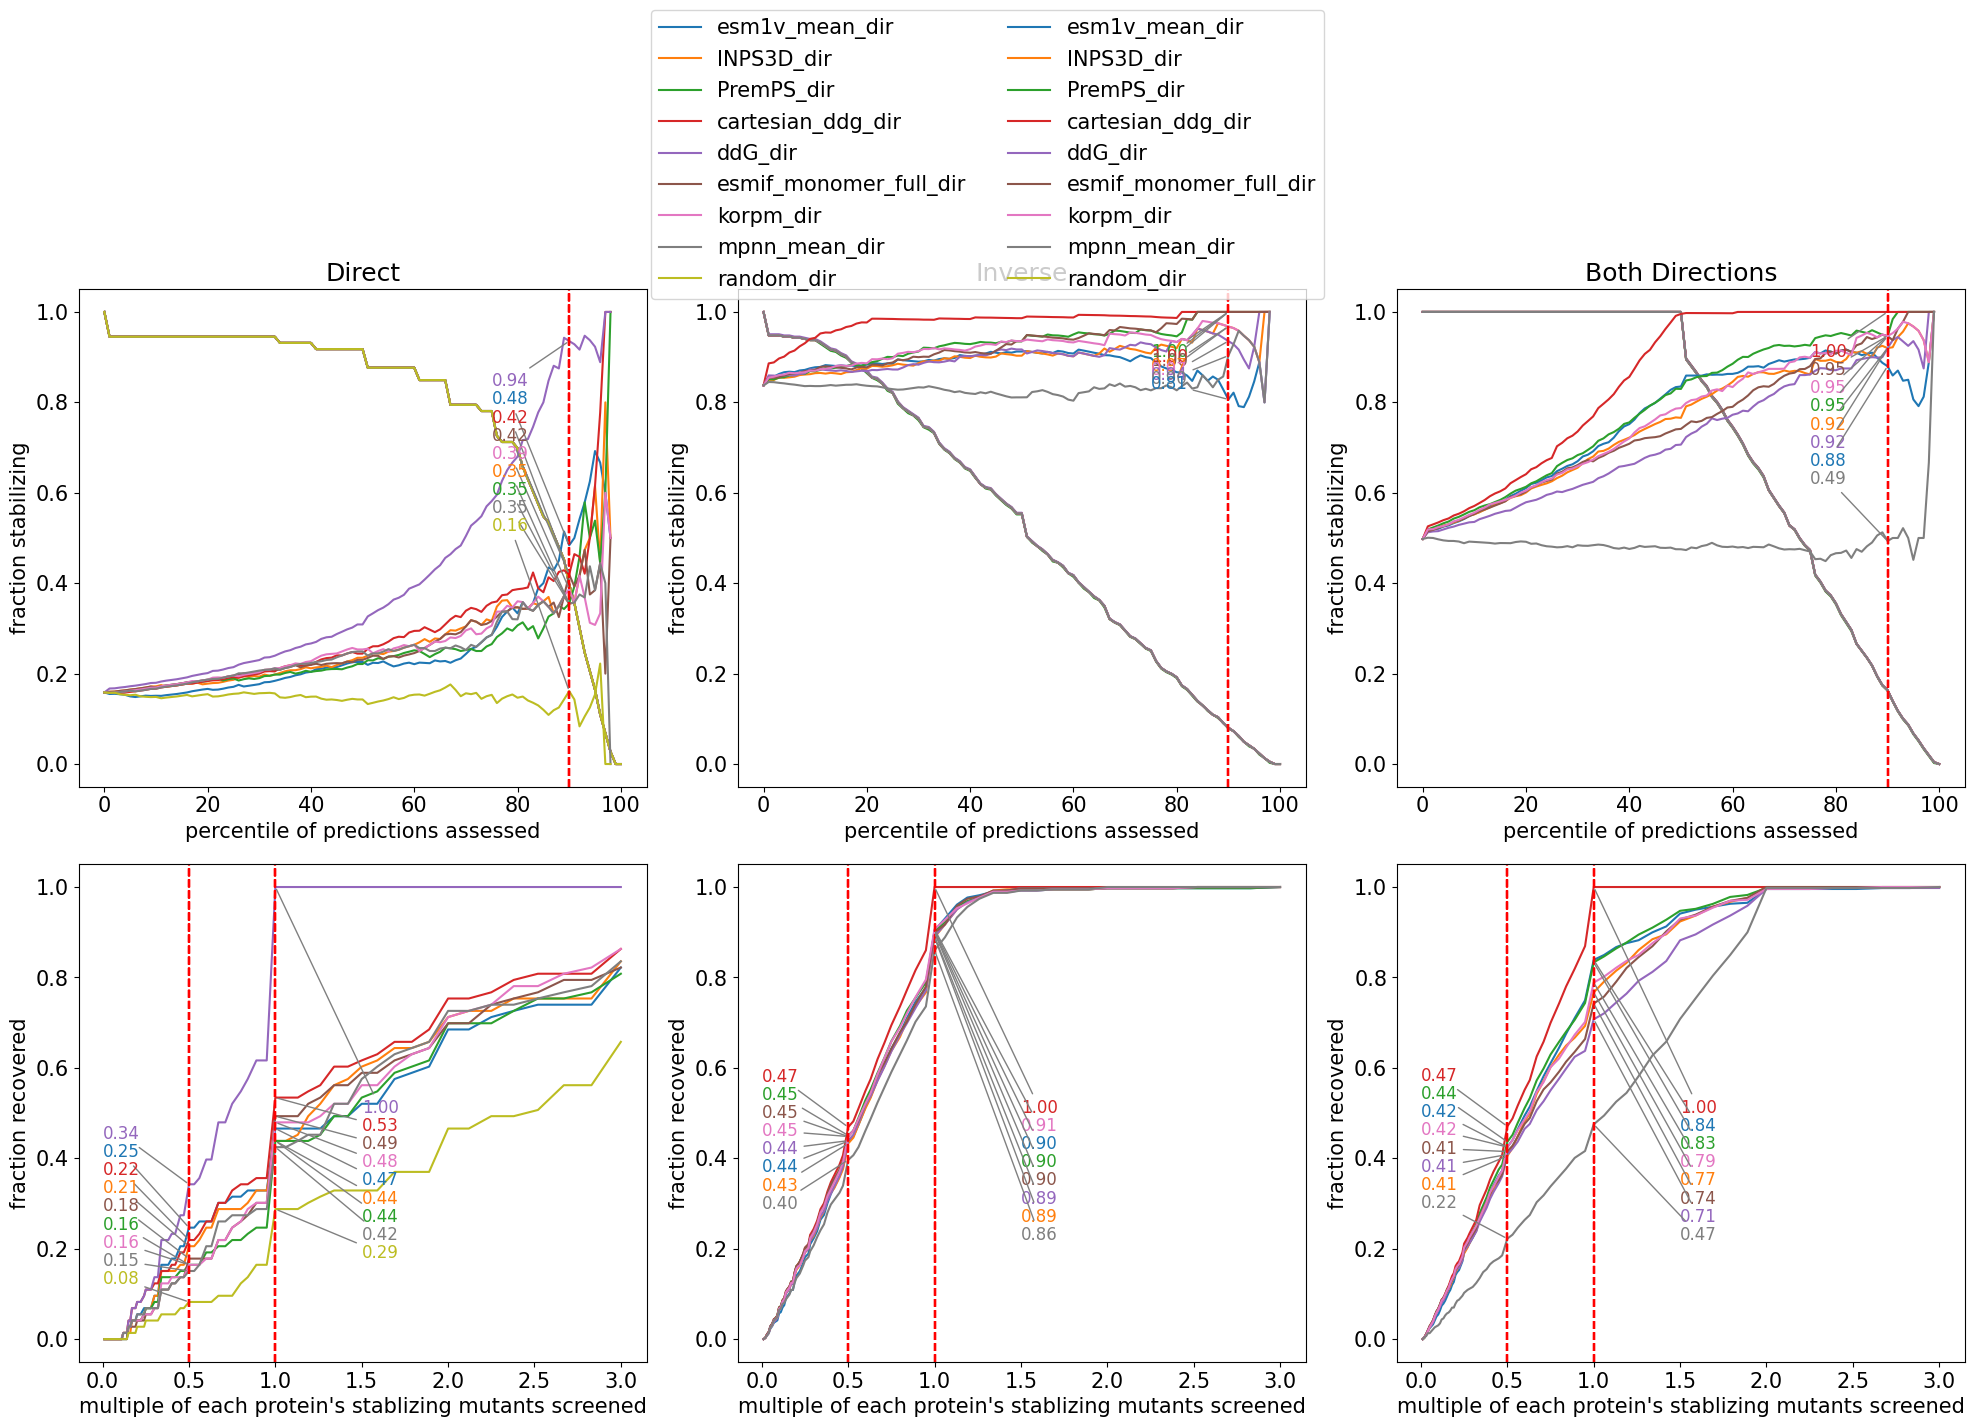

In [13]:
analysis_utils.recovery_curves_2(class_result, ['cartesian_ddg', 'INPS3D', 'mpnn_mean', 'esm1v_mean', 'PremPS', 'esmif_monomer_full', 'korpm', 'ddG', 'random'], 
    percentile_labels=[90], x_recovery_labels=[0.5, 1, 2], text_offset=(0.5, 0.1), spacing=0.04, directions=['dir', 'inv'])

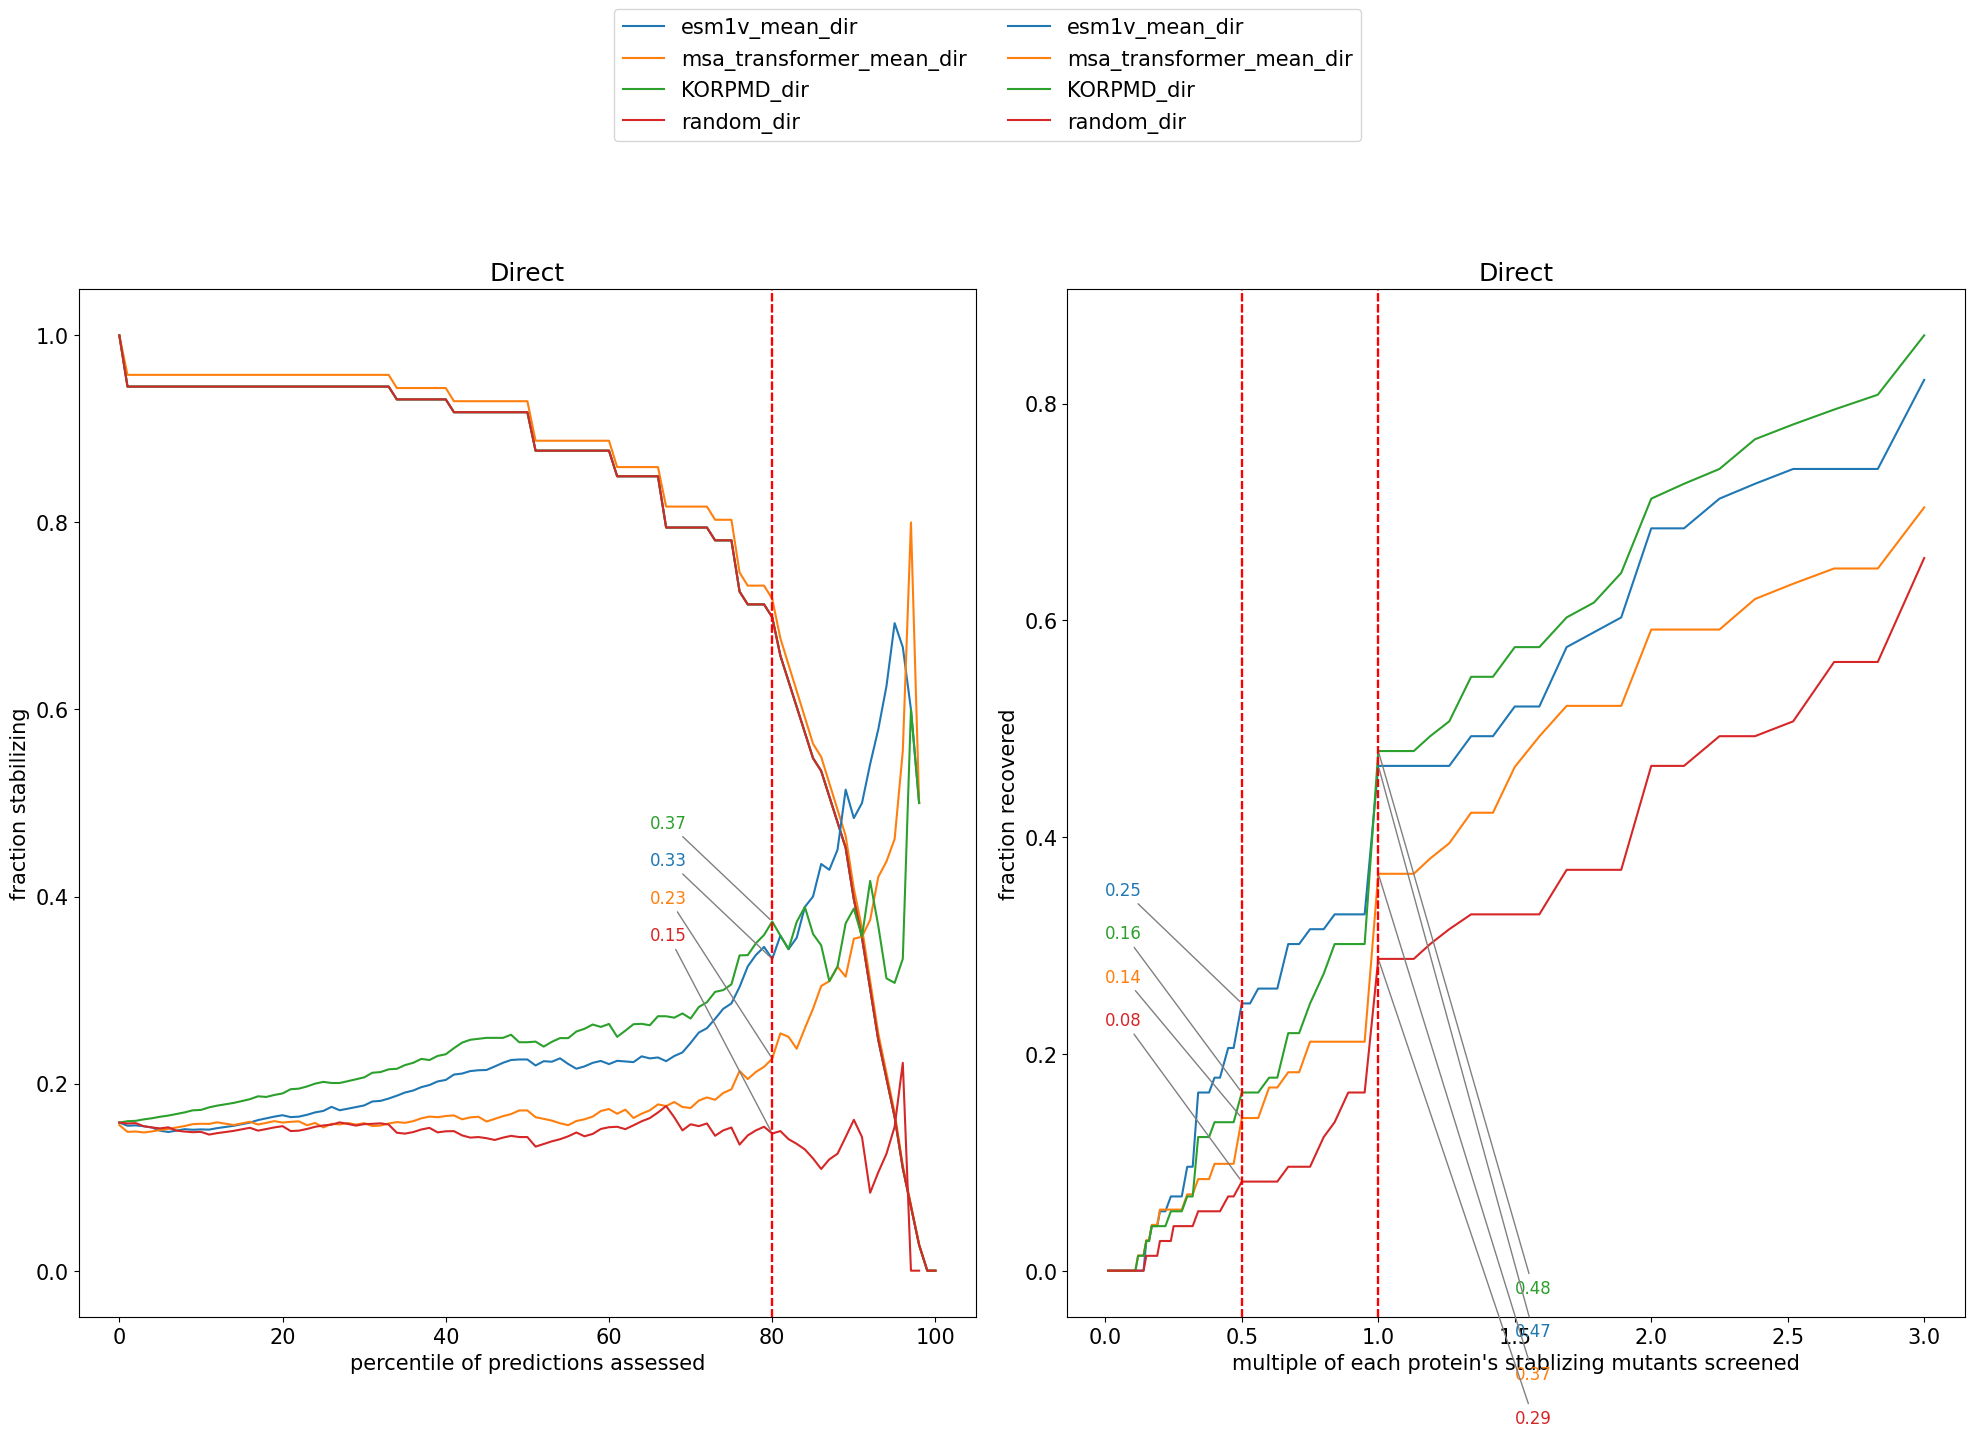

In [14]:
analysis_utils.recovery_curves_2(class_result, ['KORPMD', 'esm1v_mean', 'msa_transformer_mean', 'tranception_red', 'random'], 
    percentile_labels=[80], x_recovery_labels=[0.5, 1, 2], text_offset=(0.5, -0.1), spacing=0.04, directions=['dir'])

korpm_dir


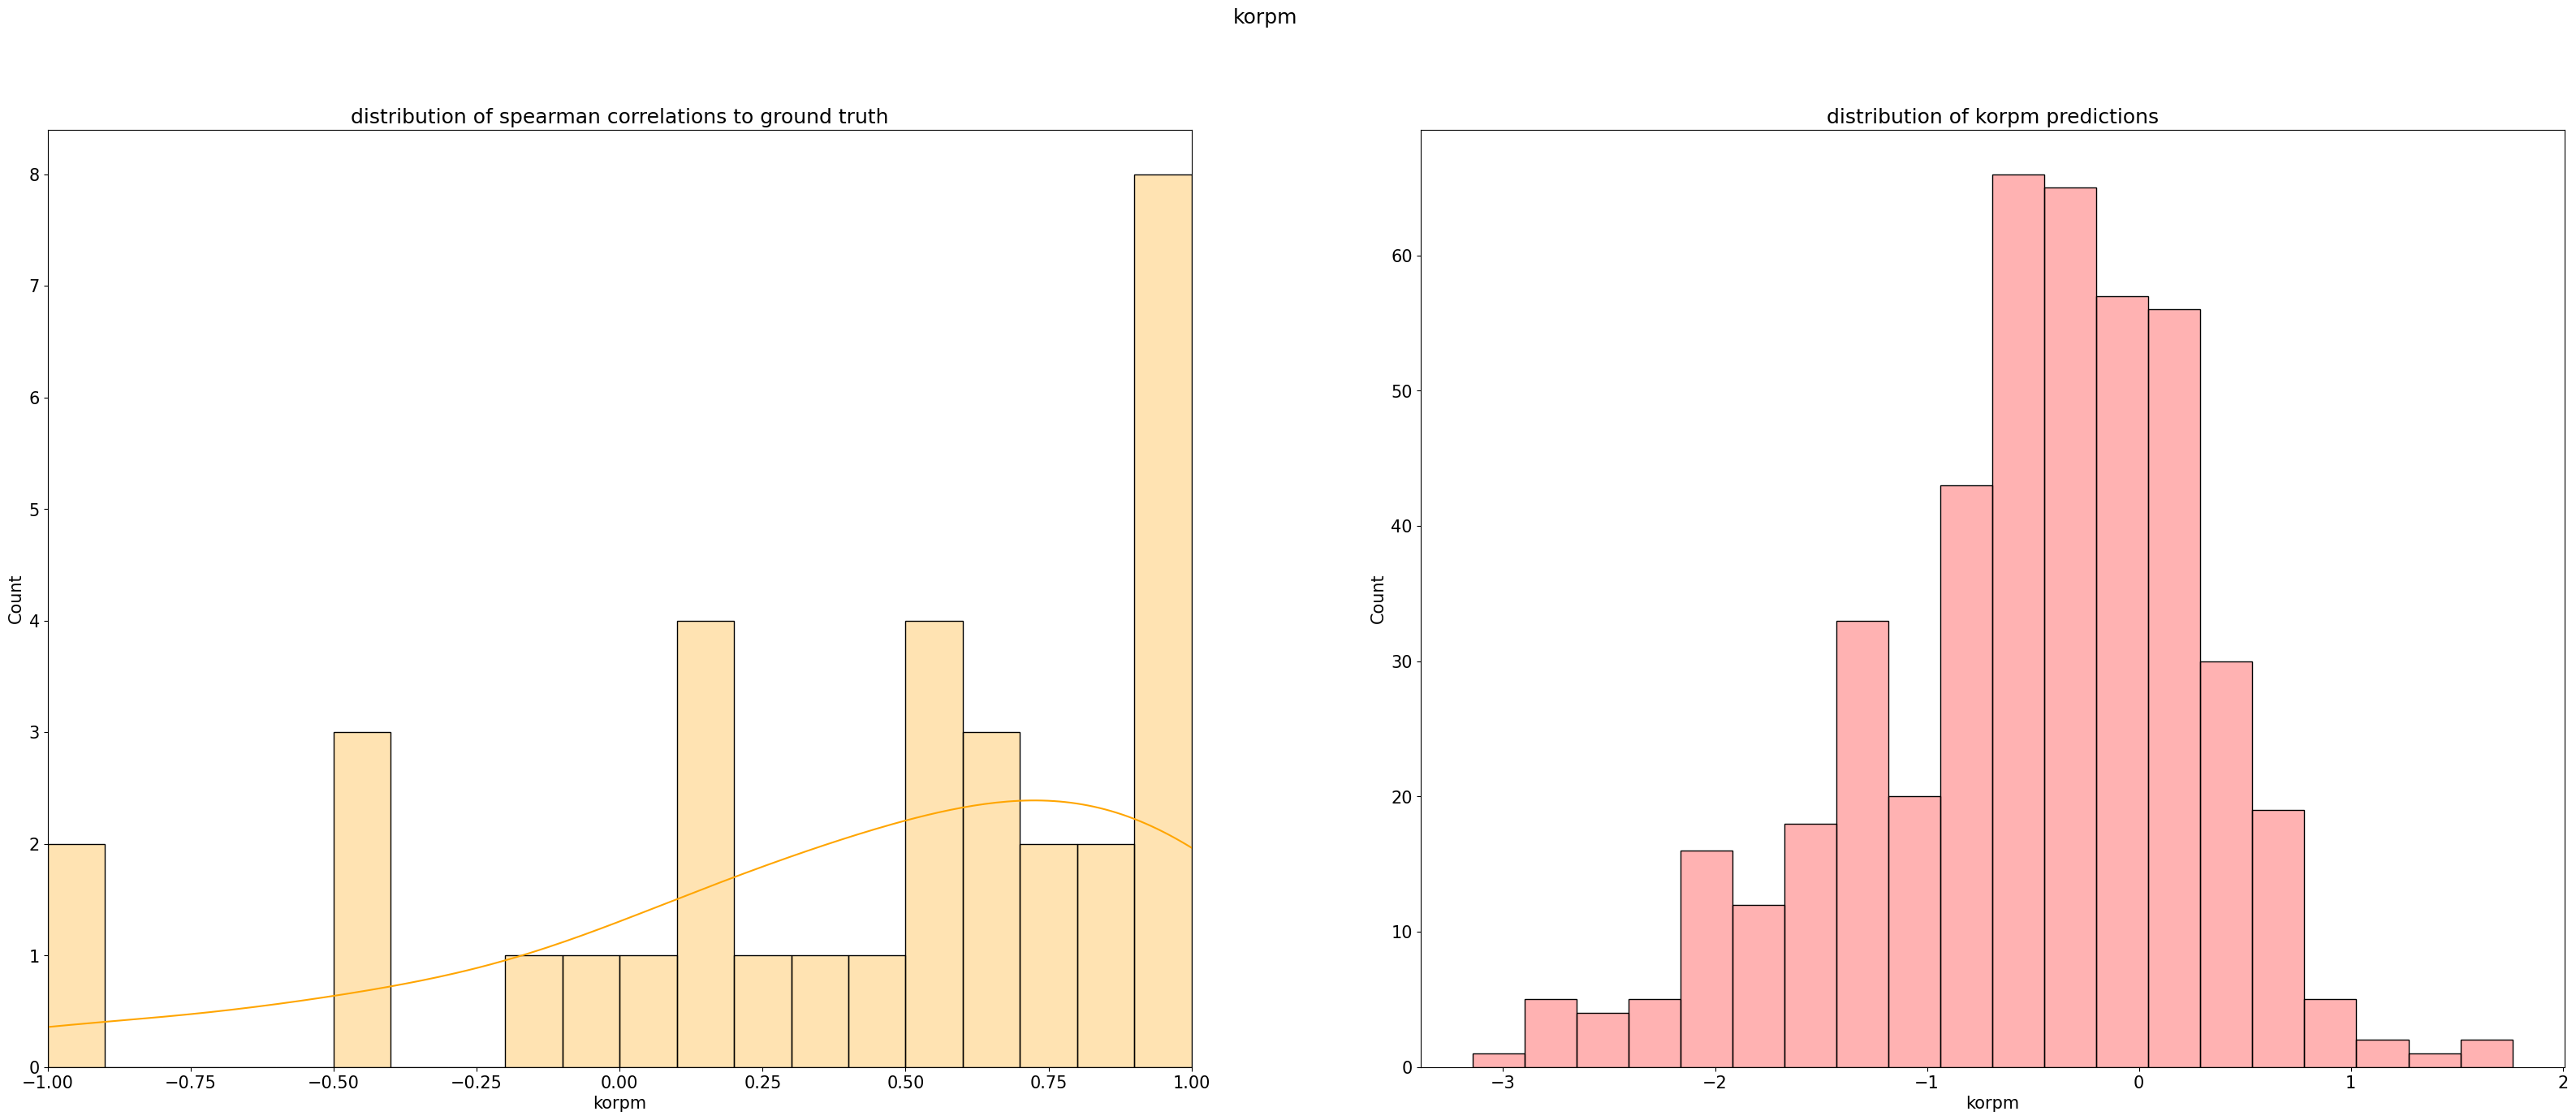

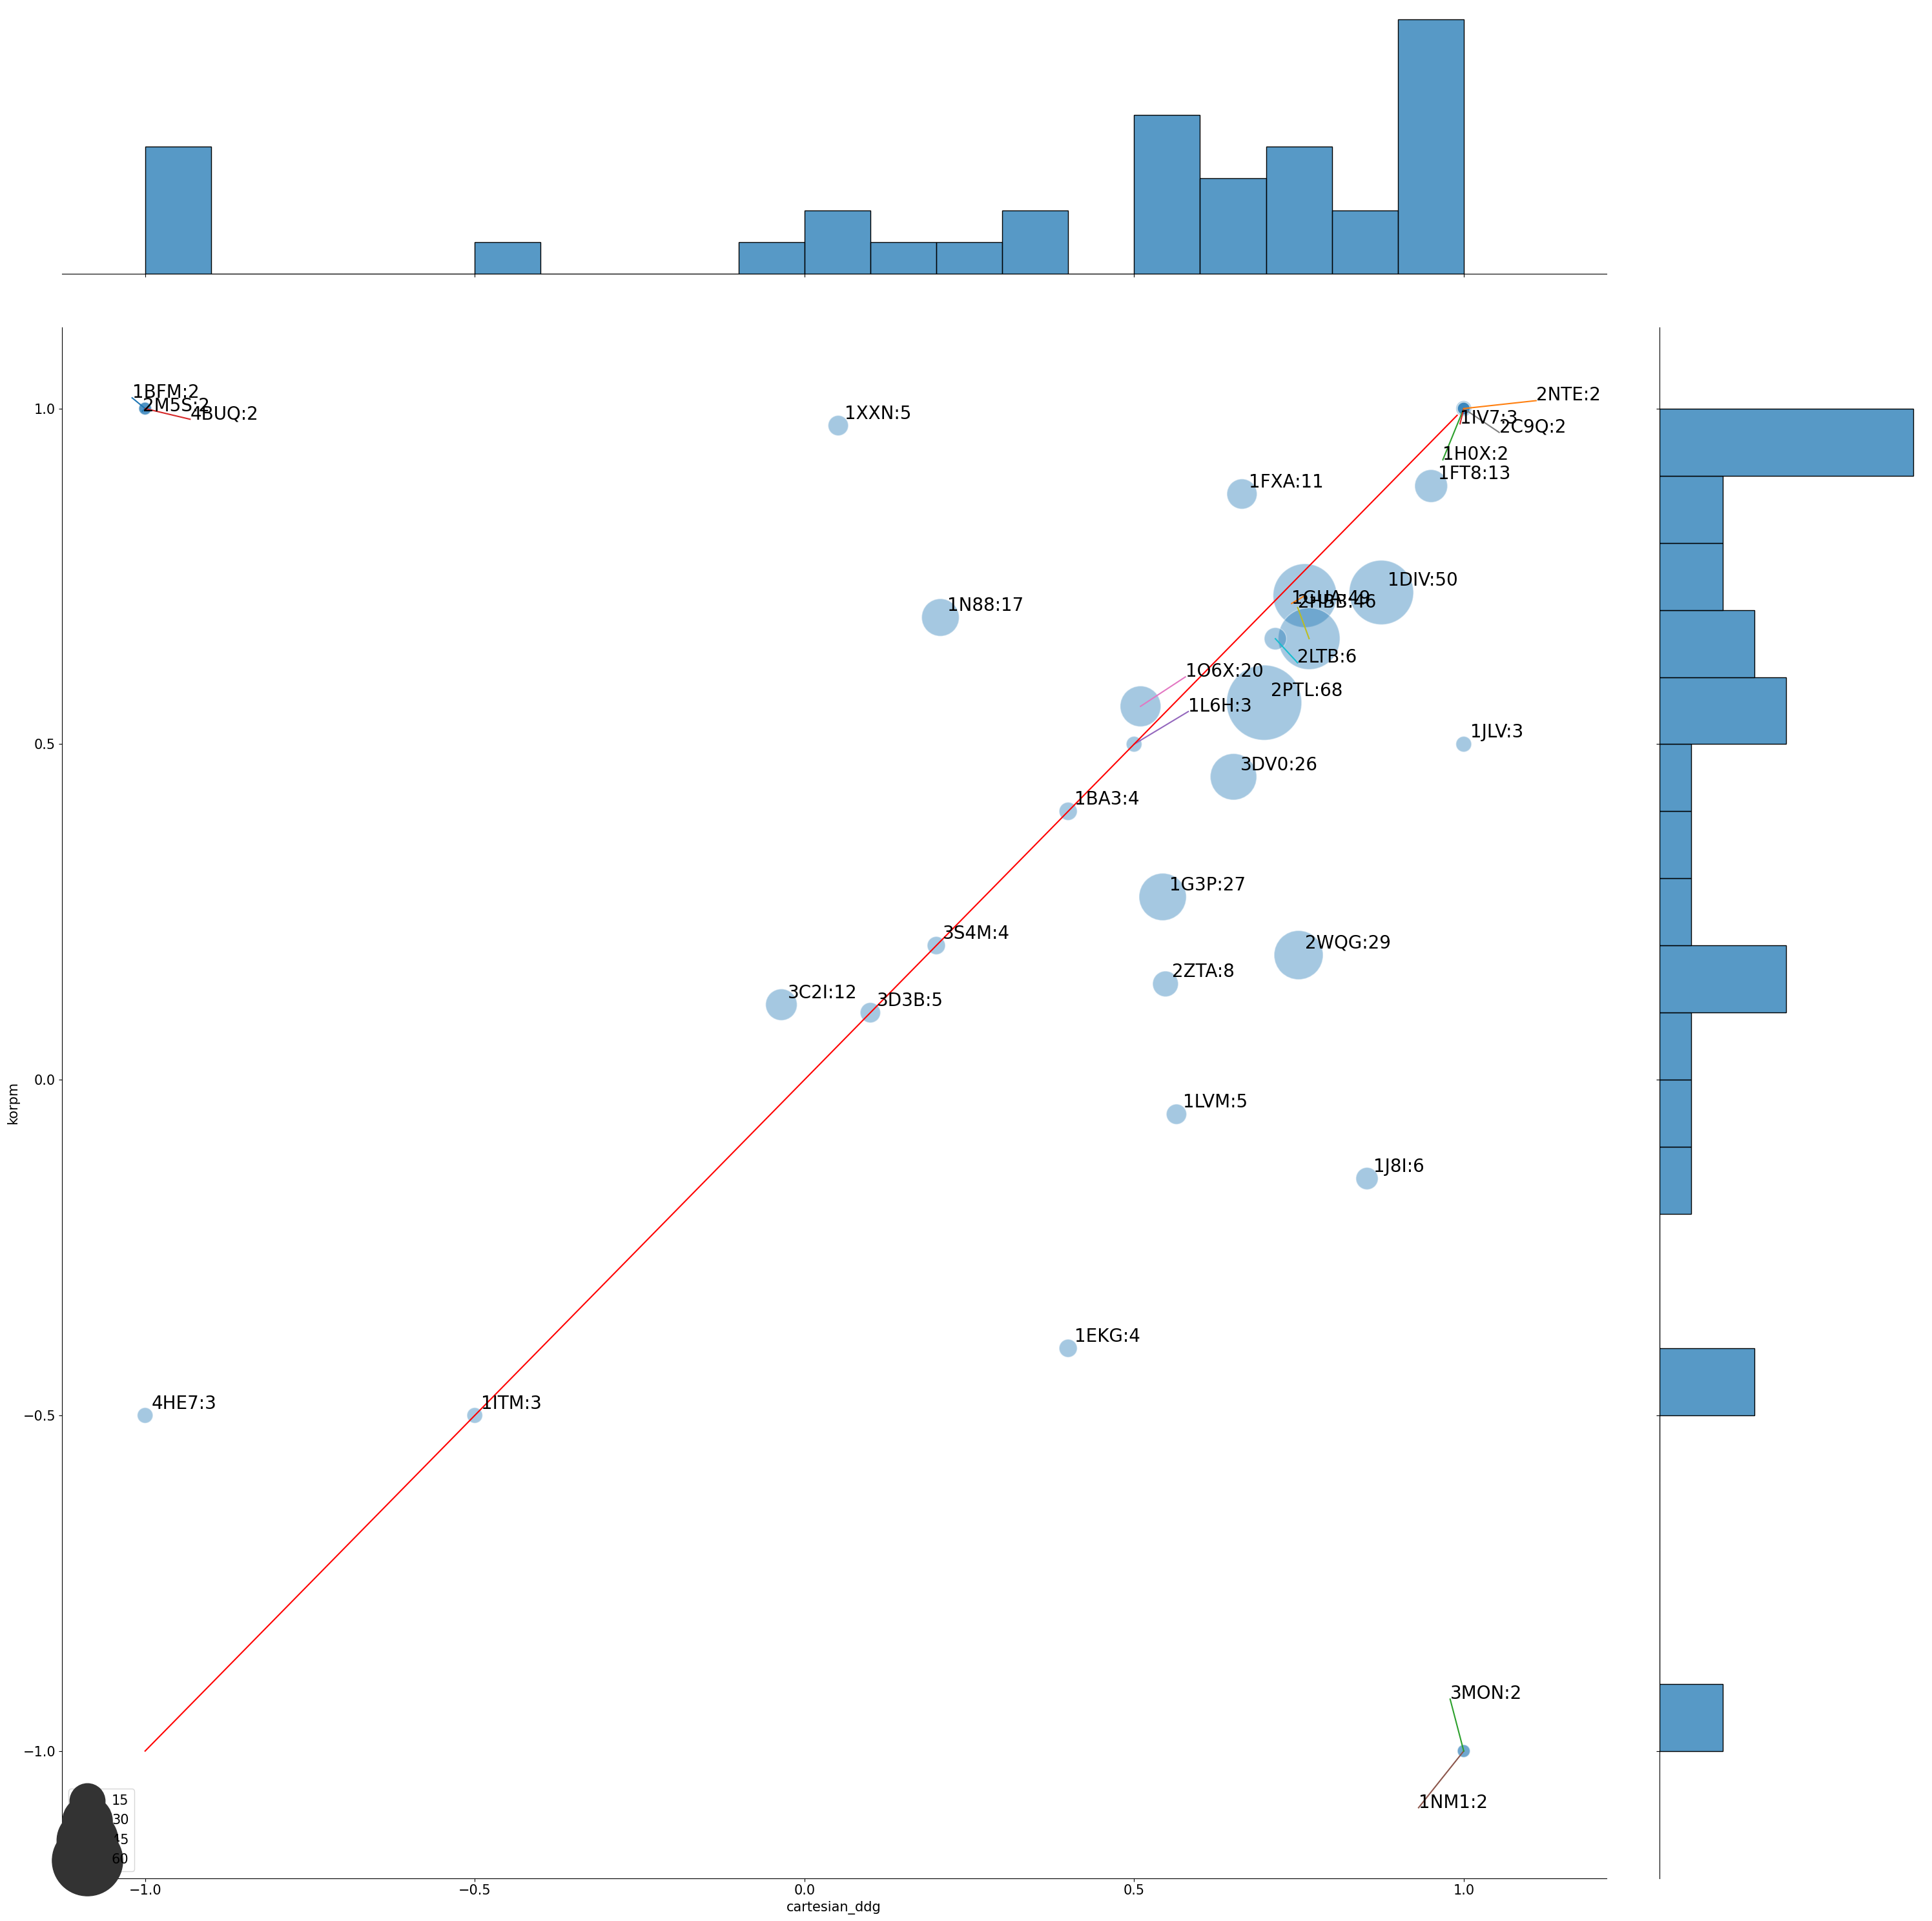

n_total  n_proteins  avg_spearman  weighted_spearman  \
direction model                                                                 
dir       korpm            460.0        34.0      0.399025           0.444771   
          cartesian_ddg    460.0        34.0      0.416668           0.520715   

                         ungrouped_spearman  
direction model                              
dir       korpm                    0.547762  
          cartesian_ddg            0.632916

In [15]:
score_1 = 'korpm_dir'
score_2 = 'cartesian_ddg_dir'
analysis_utils.correlations_2(db_complete, score_1, score_name_2=score_2, min_obs=1, corr='spearman', plot=True, out=True, direction='dir')

In [16]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    assert not os.path.exists(saveloc)
    if cols is None:
        cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    if not stacked:
        db_stacked = stack_frames(db_complete)
    else:
        db_stacked = db_complete
    db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])

    df_summ = analysis_utils.compute_stats_bidirectional(db_stacked.drop(['code'], axis=1), stacked=True, stats=()).reset_index().set_index(['direction', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [17]:
zs_feats = ['delta_kdh', 'delta_vol', 'delta_chg']

db_ens = db_complete.copy(deep=True)
for zs in zs_feats:
    db_ens[zs+'_dir'] = db_ens[zs]
    db_ens[zs+'_inv'] = -db_ens[zs]

print(len(db_ens))
db_ens['random_dir'] = np.random.rand(len(db_ens)) - 0.5
db_ens['random_inv'] = np.random.rand(len(db_ens)) - 0.5
db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
db_ens

461


ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1BA3_457D        -0.447964         0.447964    -0.230352     0.297794   
1BA3_485D        -0.000271         0.000271    -0.040138     0.058415   
1BA3_485K         0.006583        -0.006583     0.201055    -0.153260   
1BA3_485M         0.079617        -0.079617     0.230963    -0.235092   
...                    ...              ...          ...          ...   
4HE7_19G         -0.914432         0.914432    -0.728433     0.865697   
4HE7_19K          0.026103        -0.026103    -0.345831     0.496220   
5JXB_25G         -0.000839         0.000839    -0.134107     0.134107   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1BA3_457D         -1.2          1.4       -1.4        1.4    -1.757    -0.005   
1BA3_485D         -0.1          0.1       -0.7        0.6    -0.252     0.522   
1BA3_485K         -0.1          0.2       -0.9        0.9     0.358    -0.220   
1BA3_485M          0.0          0.0        0.0       -0.1     0.287     0.507   
...                ...          ...        ...        ...       ...       ...   
4HE7_19G          -0.4          0.9       -1.3        1.2    -0.021     0.150   
4HE7_19K          -0.3          0.5       -1.1        1.0    -0.518     0.128   
5JXB_25G          -0.3          0.0       -0.7        0.4     0.254    -0.833   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   

           ...  code           neff  random_dir  random_inv  delta_kdh_dir  \
uid        ...                                                               
1A0F_11A   ...  1A0F   46810.256843   -0.046432   -0.081878            2.6   
1BA3_457D  ...  1BA3  196081.822466    0.443130    0.022485           -0.3   
1BA3_485D  ...  1BA3  196081.822466   -0.067146   -0.450989           -0.3   
1BA3_485K  ...  1BA3  196081.822466    0.171806   -0.454637           -0.7   
1BA3_485M  ...  1BA3  196081.822466   -0.087232   -0.325504            5.1   
...        ...   ...            ...         ...         ...            ...   
4HE7_19G   ...  4HE7       1.000000    0.292276   -0.489524           -2.2   
4HE7_19K   ...  4HE7       1.000000    0.252545   -0.298940           -5.7   
5JXB_25G   ...  5JXB     186.248966   -0.279140    0.212015            3.1   
5JXB_25P   ...  5JXB     186.248966   -0.011908    0.304482            1.9   
5OAQ_199H  ...  5OAQ     151.512613   -0.277374   -0.388828           -1.9   

           delta_kdh_inv  delta_vol_dir  delta_vol_inv  delta_chg_dir  \
uid                                                                     
1A0F_11A            -2.6          -0.60           0.60              0   
1BA3_457D            0.3          -1.88           1.88             -1   
1BA3_485D            0.3          -1.88           1.88             -1   
1BA3_485K            0.7           0.11          -0.11              1   
1BA3_485M           -5.1          -0.23           0.23              0   
...                  ...            ...            ...            ...   
4HE7_19G             2.2          -1.00           1.00              0   
4HE7_19K             5.7           3.77          -3.77              1   
5JXB_25G            -3.1          -2.78           2.78              1   
5JXB_25P            -1.9          -0.06           0.06              1   
5OAQ_199H            1.9          -1.81           1.81              0   

           delta_chg_inv  
uid            

In [18]:
models = [c for c in db_ens.columns if ('_dir' in c or '_inv' in c) and not ('DDG_' in c or 'random' in c or 'MUT_D' in c or 'PDB' in c or 'ddG' in c)]
#models = [c for c in db_ens.columns if ('_dir' in c or '_inv' in c) and ('SAAFEC' in c or 'Dynamut' in c or 'mpnn_mean' in c)]
dfm = db_ens.copy(deep=True)#.T.drop_duplicates().T
dfm = dfm[models + ['ddG_dir', 'ddG_inv']]
dfm2 = dfm.copy(deep=True)
dfm

ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1BA3_457D        -0.447964         0.447964    -0.230352     0.297794   
1BA3_485D        -0.000271         0.000271    -0.040138     0.058415   
1BA3_485K         0.006583        -0.006583     0.201055    -0.153260   
1BA3_485M         0.079617        -0.079617     0.230963    -0.235092   
...                    ...              ...          ...          ...   
4HE7_19G         -0.914432         0.914432    -0.728433     0.865697   
4HE7_19K          0.026103        -0.026103    -0.345831     0.496220   
5JXB_25G         -0.000839         0.000839    -0.134107     0.134107   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1BA3_457D         -1.2          1.4       -1.4        1.4    -1.757    -0.005   
1BA3_485D         -0.1          0.1       -0.7        0.6    -0.252     0.522   
1BA3_485K         -0.1          0.2       -0.9        0.9     0.358    -0.220   
1BA3_485M          0.0          0.0        0.0       -0.1     0.287     0.507   
...                ...          ...        ...        ...       ...       ...   
4HE7_19G          -0.4          0.9       -1.3        1.2    -0.021     0.150   
4HE7_19K          -0.3          0.5       -1.1        1.0    -0.518     0.128   
5JXB_25G          -0.3          0.0       -0.7        0.4     0.254    -0.833   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   

           ...  mpnn_mean_inv  cartesian_ddg_dir  delta_kdh_dir  \
uid        ...                                                    
1A0F_11A   ...       3.149201           2.605333            2.6   
1BA3_457D  ...       3.695237          -5.387333           -0.3   
1BA3_485D  ...      -1.656078          -0.105333           -0.3   
1BA3_485K  ...      -3.148897           0.447000           -0.7   
1BA3_485M  ...       0.753876          -1.237000            5.1   
...        ...            ...                ...            ...   
4HE7_19G   ...       0.361660          -1.934333           -2.2   
4HE7_19K   ...      -0.866244           1.579000           -5.7   
5JXB_25G   ...      -1.865401           1.105333            3.1   
5JXB_25P   ...      -1.331108         -17.355333            1.9   
5OAQ_199H  ...       3.039710          -3.910667           -1.9   

           delta_kdh_inv  delta_vol_dir  delta_vol_inv  delta_chg_dir  \
uid                                                                     
1A0F_11A            -2.6          -0.60           0.60              0   
1BA3_457D            0.3          -1.88           1.88             -1   
1BA3_485D            0.3          -1.88           1.88             -1   
1BA3_485K            0.7           0.11          -0.11              1   
1BA3_485M           -5.1          -0.23           0.23              0   
...                  ...            ...            ...            ...   
4HE7_19G             2.2          -1.00           1.00              0   
4HE7_19K             5.7           3.77          -3.77              1   
5JXB_25G            -3.1          -2.78           2.78              1   
5JXB_25P            -1.9          -0.06           0.06              1   
5OAQ_199H            1.9          -1.81           1.81              0   

           delta_chg_inv  ddG_dir  ddG_inv  
uid                                         
1A0F_11A               0   -1.800    1.800  
1BA3_457D              1   -1.745    1.745  
1BA3_

In [19]:
weights = [1, 0.5, 0.2]
weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1[-4:] == model2[-4:] and model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
dfm

ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1BA3_457D        -0.447964         0.447964    -0.230352     0.297794   
1BA3_485D        -0.000271         0.000271    -0.040138     0.058415   
1BA3_485K         0.006583        -0.006583     0.201055    -0.153260   
1BA3_485M         0.079617        -0.079617     0.230963    -0.235092   
...                    ...              ...          ...          ...   
4HE7_19G         -0.914432         0.914432    -0.728433     0.865697   
4HE7_19K          0.026103        -0.026103    -0.345831     0.496220   
5JXB_25G         -0.000839         0.000839    -0.134107     0.134107   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1BA3_457D         -1.2          1.4       -1.4        1.4    -1.757    -0.005   
1BA3_485D         -0.1          0.1       -0.7        0.6    -0.252     0.522   
1BA3_485K         -0.1          0.2       -0.9        0.9     0.358    -0.220   
1BA3_485M          0.0          0.0        0.0       -0.1     0.287     0.507   
...                ...          ...        ...        ...       ...       ...   
4HE7_19G          -0.4          0.9       -1.3        1.2    -0.021     0.150   
4HE7_19K          -0.3          0.5       -1.1        1.0    -0.518     0.128   
5JXB_25G          -0.3          0.0       -0.7        0.4     0.254    -0.833   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   

           ...  delta_chg_inv + tranception_inv * 0.2  \
uid        ...                                          
1A0F_11A   ...                               0.153434   
1BA3_457D  ...                               1.649700   
1BA3_485D  ...                               1.546837   
1BA3_485K  ...                              -1.578807   
1BA3_485M  ...                               0.076526   
...        ...                                    ...   
4HE7_19G   ...                              -0.236141   
4HE7_19K   ...                              -1.763963   
5JXB_25G   ...                              -1.491102   
5JXB_25P   ...                              -1.417035   
5OAQ_199H  ...                               0.330664   

           delta_chg_inv + mpnn_mean_inv * 1  \
uid                                            
1A0F_11A                            1.358996   
1BA3_457D                           3.169395   
1BA3_485D                           0.860107   
1BA3_485K                          -2.933630   
1BA3_485M                           0.325325   
...                                      ...   
4HE7_19G                            0.156070   
4HE7_19K                           -1.948581   
5JXB_25G                           -2.379754   
5JXB_25P                           -2.149187   
5OAQ_199H                           1.311746   

           delta_chg_inv + mpnn_mean_inv * 0.5  \
uid                                              
1A0F_11A                              0.679498   
1BA3_457D                             2.372080   
1BA3_485D                             1.217436   
1BA3_485K                            -2.254198   
1BA3_485M                             0.162663   
...                                        ...   
4HE7_19G                              0.078035   
4HE7_19K                             -1.761673   
5JXB_25G                             -1.977260   
5JXB_25P                             -1.861976   
5OAQ_199H                             0.

In [20]:
dfm_stacked = analysis_utils.stack_frames(dfm)
dfm_stacked['code'] = dfm_stacked.reset_index()['uid'].str[:4]

# takes a long time to compute and has already been doen
#d1 = get_summary_df(dfm_stacked, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stacked=True, stats=()) 

d1 = pd.read_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv')).set_index(['direction', 'model_type', 'model', 'class'])

In [21]:
supp2 = d1.xs('combined')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'ausrc', 'aumrc', 'antisymmetry', 'bias']].reset_index().drop(['model_type', 'class'], axis=1).set_index('model')
supp2

auprc  mean_stabilization  \
model                                                          
ACDC-NN + ACDC-NN-Seq * 0.2     0.884276            1.041989   
ACDC-NN + ACDC-NN-Seq * 0.5     0.884661            1.037911   
ACDC-NN + ACDC-NN-Seq * 1       0.884660            1.036698   
ACDC-NN + DDGun * 0.2           0.892495            1.096299   
ACDC-NN + DDGun * 0.5           0.893525            1.088127   
...                                  ...                 ...   
tranception + mpnn_30_00 * 0.5  0.865615            1.181623   
tranception + mpnn_30_00 * 1    0.875482            1.163778   
tranception + mpnn_mean * 0.2   0.849587            1.172197   
tranception + mpnn_mean * 0.5   0.863093            1.197584   
tranception + mpnn_mean * 1     0.873388            1.191107   

                                net_stabilization  weighted_ndcg  \
model                                                              
ACDC-NN + ACDC-NN-Seq * 0.2               477.231       0.913778   
ACDC-NN + ACDC-NN-Seq * 0.5               476.401       0.913041   
ACDC-NN + ACDC-NN-Seq * 1                 473.771       0.916377   
ACDC-NN + DDGun * 0.2                     473.601       0.914500   
ACDC-NN + DDGun * 0.5                     471.159       0.913318   
...                                           ...            ...   
tranception + mpnn_30_00 * 0.5            535.275       0.936576   
tranception + mpnn_30_00 * 1              523.700       0.942967   
tranception + mpnn_mean * 0.2             534.522       0.936488   
tranception + mpnn_mean * 0.5             535.320       0.938046   
tranception + mpnn_mean * 1               522.896       0.943269   

                                weighted_spearman     ausrc     aumrc  \
model                                                                   
ACDC-NN + ACDC-NN-Seq * 0.2              0.542629  0.770158  0.459923   
ACDC-NN + ACDC-NN-Seq * 0.5              0.548281  0.771027  0.460215   
ACDC-NN + ACDC-NN-Seq * 1                0.552388  0.774002  0.460736   
ACDC-NN + DDGun * 0.2                    0.567938  0.779078  0.461754   
ACDC-NN + DDGun * 0.5                    0.567785  0.779933  0.462203   
...                                           ...       ...       ...   
tranception + mpnn_30_00 * 0.5           0.676551  0.782138  0.465554   
tranception + mpnn_30_00 * 1             0.689382  0.787572  0.467998   
tranception + mpnn_mean * 0.2            0.681568  0.777393  0.463762   
tranception + mpnn_mean * 0.5            0.677610  0.781420  0.465196   
tranception + mpnn_mean * 1              0.689752  0.784884  0.466695   

                                antisymmetry      bias  
model                                                   
ACDC-NN + ACDC-NN-Seq * 0.2        -0.986372 -0.011576  
ACDC-NN + ACDC-NN-Seq * 0.5        -0.991201 -0.011576  
ACDC-NN + ACDC-NN-Seq * 1          -0.995036 -0.011576  
ACDC-NN + DDGun * 0.2              -0.983537 -0.022514  
ACDC-NN + DDGun * 0.5              -0.982877 -0.037709  
...                                      ...       ...  
tranception + mpnn_30_00 * 0.5     -0.936597 -0.072558  
tranception + mpnn_30_00 * 1       -0.847520 -0.145115  
tranception + mpnn_mean * 0.2      -0.984671 -0.045745  
tranception + mpnn_mean * 0.5      -0.926132 -0.114363  
tranception + mpnn_mean * 1        -0.821656 -0.228726  

[4034 rows x 9 columns]

In [22]:
d4 = d1.reset_index()
d4.loc[d4['model']=='random']

Empty DataFrame
Columns: [direction, model_type, model, class, n, tp, fp, tn, fn, sensitivity, specificity, precision, pred_positives_ratio, accuracy, f1_score, MCC, auroc, auprc, n_stable, mean_stabilization, net_stabilization, mean_stable_pred, mean_t1s, ndcg, mean_ndcg, weighted_ndcg, spearman, mean_spearman, weighted_spearman, mean_auprc, weighted_auprc, 0$, stab_0$, 1$, stab_1$, 2$, stab_2$, 3$, stab_3$, 4$, stab_4$, 5$, stab_5$, 6$, stab_6$, 7$, stab_7$, 8$, stab_8$, 9$, stab_9$, 10$, stab_10$, 11$, stab_11$, 12$, stab_12$, 13$, stab_13$, 14$, stab_14$, 15$, stab_15$, 16$, stab_16$, 17$, stab_17$, 18$, stab_18$, 19$, stab_19$, 20$, stab_20$, 21$, stab_21$, 22$, stab_22$, 23$, stab_23$, 24$, stab_24$, 25$, stab_25$, 26$, stab_26$, 27$, stab_27$, 28$, stab_28$, 29$, stab_29$, 30$, stab_30$, 31$, stab_31$, 32$, stab_32$, 33$, stab_33$, 34$, ...]
Index: []

[0 rows x 304 columns]

In [23]:
supp = d1.xs('dir')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'ausrc', 'aumrc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'ausrc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')
df4 = analysis_utils.get_stat_df(supp, 'mean_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)
print(len(df1))
print(len(df1))

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization'], df4['mean_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['ausrc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()
idx4 = df_merged.groupby('models')['mean_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3], df_merged.loc[idx4]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(16)
dd2 = df_merged_2.sort_values('ausrc', ascending=False).head(16)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(16)
dd4 = df_merged_2.sort_values('mean_stabilization', ascending=False).head(16)
dd = pd.concat([dd1, dd2, dd3, dd4]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization', 'Mean Stabilization']
#dd.to_csv('../../zeroshot suppl/s461_combos_direct.csv')
print(len(dd))
dd

ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer_full e
ddG esmif_multimer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer_full e
ddG esmif_multimer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS dd

Model 1              Model 2  Weight 2     wNDCG     AUPPC  \
684                  ddG                  ddG       0.0  1.000000  0.416336   
582      Rosetta_CartDDG          ESM-1V_mean       1.0  0.931028  0.296098   
588          ESM-1V_mean                KORPM       1.0  0.930481  0.286265   
722                KORPM               MIF-ST       0.5  0.928310  0.285743   
28               ACDC-NN          ESM-1V_mean       0.5  0.927316  0.275400   
388              MAESTRO          ESM-1V_mean       1.0  0.926112  0.280795   
424          ESM-1V_mean             PopMusic       0.2  0.925704  0.291407   
548          ESM-1V_mean              SOL_ACC       0.2  0.924505  0.270943   
38    esmif_monomer_full              ACDC-NN       0.5  0.923867  0.281231   
606      Rosetta_CartDDG           MSA-T_mean       0.2  0.922551  0.275446   
668      Rosetta_CartDDG   esmif_monomer_full       1.0  0.922209  0.298550   
40   esmif_multimer_full              ACDC-NN       0.5  0.922176  0.273624   
396      Rosetta_CartDDG              MAESTRO       0.5  0.921997  0.296810   
598          ESM-1V_mean     ProteinMPNN_mean       0.5  0.921436  0.276010   
584          ESM-1V_mean   esmif_monomer_full       0.5  0.921128  0.272699   
680      Rosetta_CartDDG       ProteinMPNN_20       0.5  0.920423  0.305529   
466      Rosetta_CartDDG               PremPS       0.5  0.919268  0.310211   
150              DDGun3D               MIF-ST       1.0  0.907524  0.308517   
138      Rosetta_CartDDG              DDGun3D       0.2  0.913293  0.304084   
148                  MIF              DDGun3D       0.5  0.895255  0.304036   
432      Rosetta_CartDDG             PopMusic       0.2  0.918531  0.303533   
682      Rosetta_CartDDG     ProteinMPNN_mean       0.2  0.916222  0.303288   
98                 DDGun                  MIF       1.0  0.894002  0.302926   
100                DDGun               MIF-ST       0.5  0.906197  0.301848   
58                 DDGun                 DUET       0.5  0.883613  0.301511   
318      Rosetta_CartDDG      I-Mutant3.0-Seq       0.5  0.910119  0.300929   
276      Rosetta_CartDDG          I-Mutant3.0       0.2  0.916951  0.300779   
498      Rosetta_CartDDG           SAAFEC-Seq       0.2  0.916951  0.300779   
76                 DDGun                  SDM       0.2  0.886917  0.300546   
140   esmif_monomer_full              DDGun3D       0.5  0.907491  0.300342   
468               PremPS   esmif_monomer_full       1.0  0.917239  0.276530   
470  esmif_multimer_full               PremPS       0.5  0.904751  0.266945   
478               MIF-ST               PremPS       0.5  0.904370  0.284387   
370               INPS3D               MIF-ST       1.0  0.911253  0.289014   
476               PremPS                  MIF       0.2  0.903017  0.287048   
458          ESM-1V_mean               PremPS       0.2  0.910585  0.269041   
592          ESM-1V_mean                  MIF       0.5  0.916970  0.294287   
670      Rosetta_CartDDG  esmif_multimer_full       1.0  0.918898  0.296712   
482     ProteinMPNN_mean               PremPS       0.5  0.910519  0.285888   
52               ACDC-NN     ProteinMPNN_mean       0.5  0.915398  0.285003   
678      Rosetta_CartDDG               MIF-ST       0.2  0.919066  0.292935   
510           SAAFEC-Seq               MIF-ST       1.0  0.903642  0.290823   
288          I-Mutant3.0               MIF-ST       1.0  0.903642  0.290823   
48                MIF-ST              ACDC-NN       0.5  0.904745  0.291284   
460               PremPS           MSA-T_mean       0.5  0.902105  0.240916   
330               MIF-ST      I-Mutant3.0-Seq       0.5  0.899810  0.273178   
426             PopMusic           MSA-T_mean       1.0  0.897004  0.259907   
614           MSA-T_mean                 mCSM       0.5  0.896068  0.248393   
312      I-Mutant3.0-Seq           MSA-T_mean       1.0  0.892958  0.256091   
732                 mCSM               MIF-ST       1.0  0.902639  

In [24]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'ausrc', 'aumrc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'ausrc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['ausrc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(16)
dd2 = df_merged_2.sort_values('ausrc', ascending=False).head(16)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(16)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
FoldX ddG e
ThermoNet ddG e
ddG esmif_monomer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
FoldX ddG e
ThermoNet ddG e
ddG esmif_monomer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
Fol

Model 1           Model 2  Weight 2     wNDCG     AUPPC  \
594               ddG               ddG       0.0  1.000000  0.853722   
618             KORPM    ProteinMPNN_20       0.5  0.953748  0.787994   
438            PremPS  ProteinMPNN_mean       1.0  0.953738  0.805787   
436            PremPS    ProteinMPNN_20       1.0  0.953735  0.806188   
620             KORPM  ProteinMPNN_mean       0.5  0.952828  0.789697   
548             KORPM        MSA-T_mean       0.5  0.952308  0.795426   
528       ESM-1V_mean             KORPM       1.0  0.949717  0.797905   
428            PremPS             KORPM       1.0  0.949269  0.801664   
616             KORPM            MIF-ST       1.0  0.949183  0.787710   
142           DDGun3D  ProteinMPNN_mean       1.0  0.948286  0.804225   
138           DDGun3D            MIF-ST       1.0  0.948267  0.800866   
434            PremPS            MIF-ST       1.0  0.948077  0.799382   
48            ACDC-NN  ProteinMPNN_mean       1.0  0.947969  0.800984   
522             FoldX       ESM-1V_mean       1.0  0.947544  0.789170   
46     ProteinMPNN_20           ACDC-NN       0.5  0.946904  0.800785   
418            PremPS       ESM-1V_mean       1.0  0.946865  0.797348   
96              DDGun  ProteinMPNN_mean       1.0  0.945023  0.805947   
94     ProteinMPNN_20             DDGun       0.5  0.943463  0.803185   
432            PremPS               MIF       0.2  0.942322  0.801070   
140           DDGun3D    ProteinMPNN_20       1.0  0.942628  0.800410   
92             MIF-ST             DDGun       0.5  0.941231  0.799516   
68             PremPS             DDGun       0.2  0.939658  0.798843   
44            ACDC-NN            MIF-ST       1.0  0.946382  0.797738   
536       ESM-1V_mean    ProteinMPNN_20       1.0  0.942561  0.788750   
558  ProteinMPNN_mean        MSA-T_mean       1.0  0.942627  0.781889   
556    ProteinMPNN_20        MSA-T_mean       1.0  0.945691  0.781068   
532       ESM-1V_mean               MIF       0.5  0.934701  0.779300   
122       ESM-1V_mean           DDGun3D       0.5  0.942426  0.786701   
534       ESM-1V_mean            MIF-ST       0.5  0.934903  0.774681   
538       ESM-1V_mean  ProteinMPNN_mean       1.0  0.941346  0.788836   

     Net Stabilization  
594            601.828  
618            497.362  
438            533.997  
436            535.622  
620            494.410  
548            537.930  
528            541.193  
428            526.134  
616            499.533  
142            522.756  
138            526.408  
434            533.617  
48             533.751  
522            528.035  
46             529.062  
418            542.249  
96             507.340  
94             504.723  
432            529.937  
140            522.263  
92             511.317  
68             506.164  
44             535.644  
536            535.395  
558            533.785  
556            533.670  
532            533.553  
122            533.433  
534            532.834  
538            532.721

In [25]:
"""
#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization']])

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['ausrc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10)
dd2 = df_merged_2.sort_values('ausrc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
pd.concat([dd1, dd2, dd3]).drop_duplicates()
"""

"\n#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])\ndf_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization']])\n\ndf_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)\ndf_merged['models'] = df_merged['models'].apply(frozenset)\n\nidx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()\nidx2 = df_merged.groupby('models')['ausrc'].idxmax()\nidx3 = df_merged.groupby('models')['net_stabilization'].idxmax()\n\ndf_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()\n\ndd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10)\ndd2 = df_merged_2.sort_values('ausrc', ascending=False).head(10)\ndd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)\npd.concat([dd1, dd2, dd3]).drop_duplicates()\n"

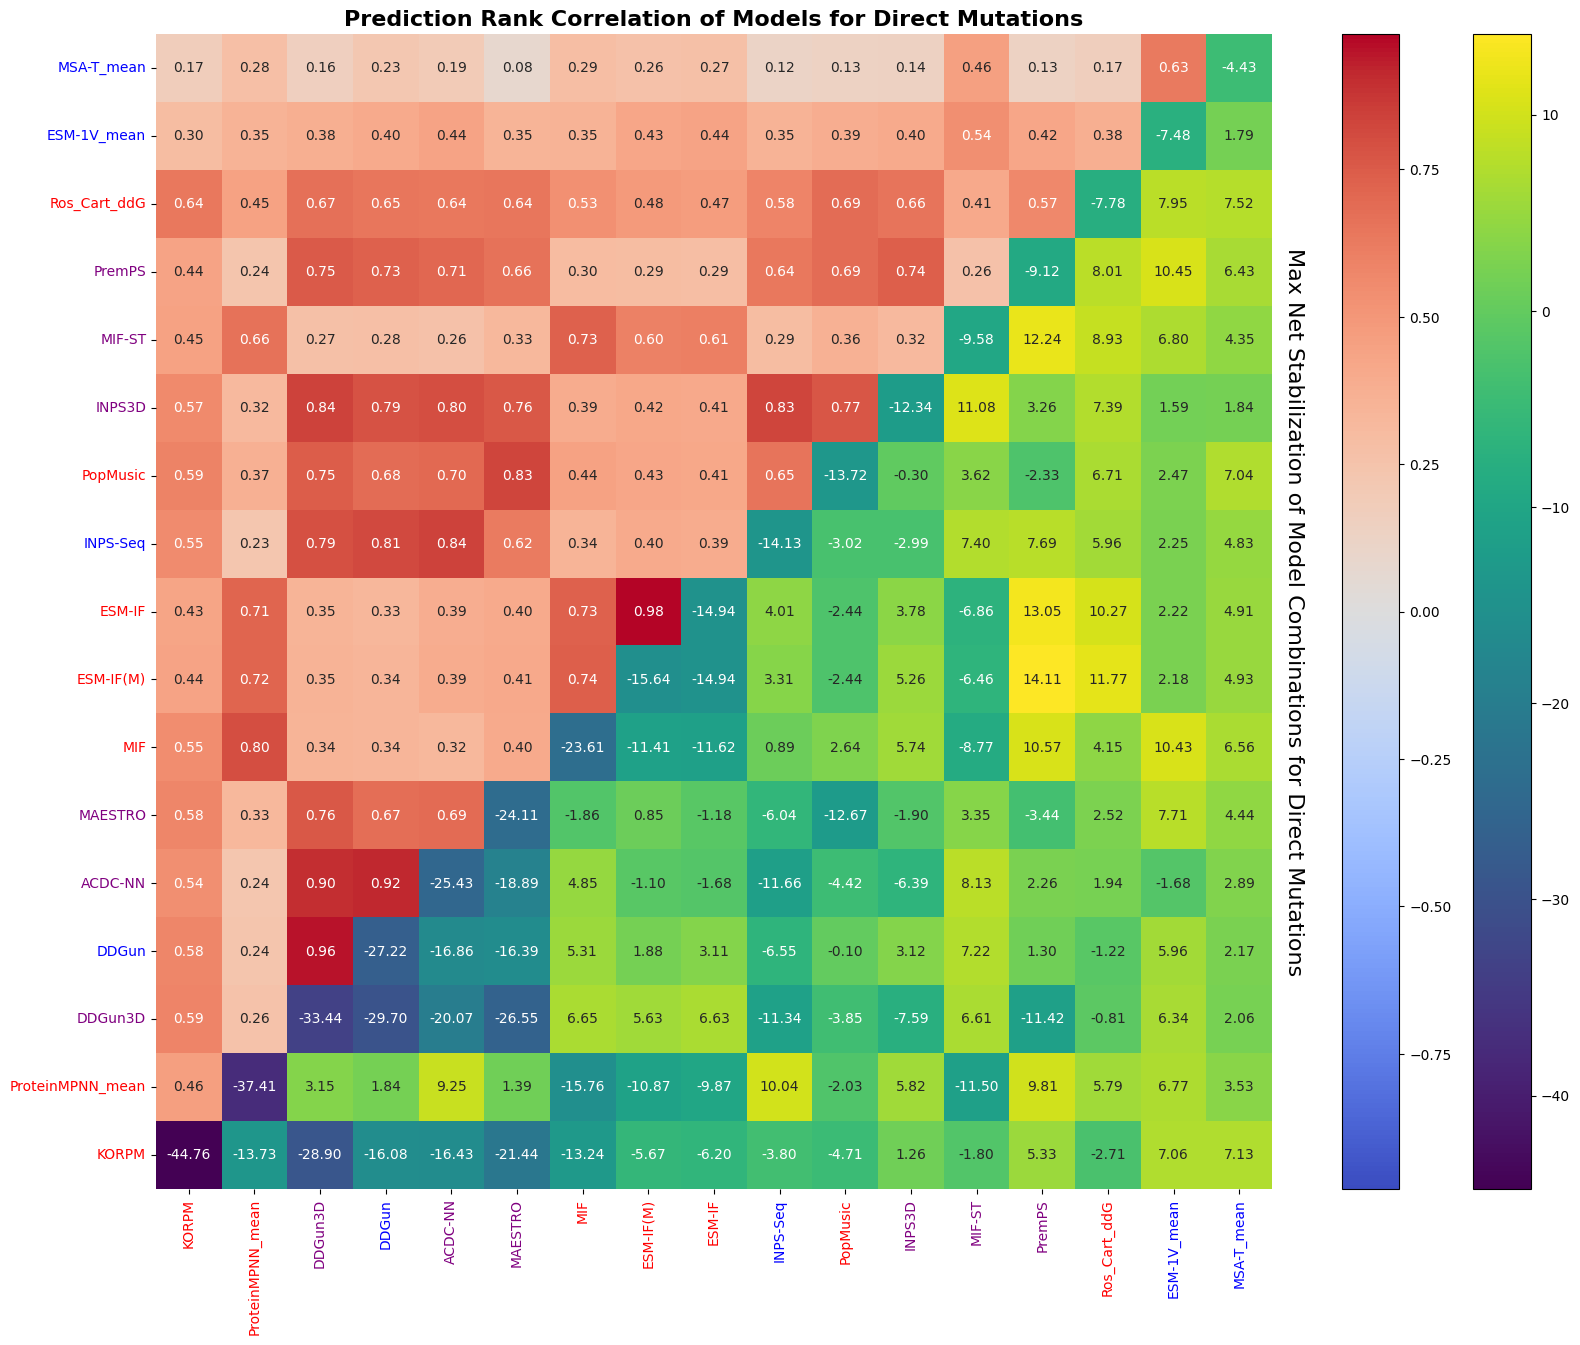

{'mif', 'INPS-Seq', 'cartesian_ddg', 'PopMusic', 'DDGun3D', 'esm1v_mean', 'PremPS', 'mpnn_mean', 'MAESTRO', 'DDGun', 'INPS3D', 'mifst', 'esmif_monomer_full', 'esmif_multimer_full', 'korpm', 'ACDC-NN', 'msa_transformer_mean'}


model1  weight1                model2  weight2  \
rank                                                                 
1                   PremPS      1.0    esmif_monomer_full      1.0   
2                   PremPS      1.0   esmif_multimer_full      1.0   
3                   PremPS      1.0                 mifst      1.0   
4       esmif_monomer_full      1.0         cartesian_ddg      0.5   
5                    mifst      1.0                INPS3D      0.5   
6                   PremPS      1.0                   mif      1.0   
7               esm1v_mean      1.0                PremPS      0.5   
8                      mif      1.0            esm1v_mean      0.5   
9      esmif_multimer_full      1.0         cartesian_ddg      0.5   
10                INPS-Seq      1.0             mpnn_mean      1.0   
11                  PremPS      1.0             mpnn_mean      1.0   
12                 ACDC-NN      1.0             mpnn_mean      1.0   
13                   mifst      1.0         cartesian_ddg      0.5   
14                 ACDC-NN      1.0                 mifst      1.0   
15           cartesian_ddg      1.0                PremPS      0.5   
16              esm1v_mean      1.0         cartesian_ddg      0.5   
17              esm1v_mean      1.0               MAESTRO      0.5   
18                INPS-Seq      1.0                PremPS      1.0   
19           cartesian_ddg      1.0  msa_transformer_mean      0.2   
20                   mifst      1.0              INPS-Seq      0.5   
21           cartesian_ddg      1.0                INPS3D      0.5   
22                   mifst      1.0                 DDGun      0.5   
23                   korpm      1.0  msa_transformer_mean      1.0   
24              esm1v_mean      1.0                 korpm      1.0   
25    msa_transformer_mean      1.0              PopMusic      0.5   
26              esm1v_mean      1.0                 mifst      1.0   
27              esm1v_mean      1.0             mpnn_mean      0.5   
28                PopMusic      1.0         cartesian_ddg      1.0   
29                 DDGun3D      1.0                   mif      1.0   
30     esmif_multimer_full      1.0               DDGun3D      0.5   

      net_stabilization      corr  
rank                               
1                14.106  0.293552  
2                13.046  0.288005  
3                12.242  0.264966  
4                11.774  0.484843  
5                11.080  0.315239  
6                10.575  0.302040  
7                10.446  0.423532  
8                10.429  0.352413  
9                10.274  0.474205  
10               10.036  0.234578  
11                9.812  0.239634  
12                9.252  0.235266  
13                8.929  0.406438  
14                8.127  0.262504  
15                8.007  0.569589  
16                7.953  0.380562  
17                7.712  0.350895  
18                7.694  0.638838  
19                7.523  0.166008  
20                7.399  0.293851  
21                7.395  0.655554  
22                7.221  0.280716  
23                7.130  0.173202  
24                7.056  0.297954  
25                7.040  0.131418  
26                6.802  0.540793  
27                6.766  0.354779  
28                6.711  0.686340  
29                6.652  0.344654  
30                6.631  0.348134

In [26]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 #'SOL_ACC': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'dir'
statistic = 'net_stabilization'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

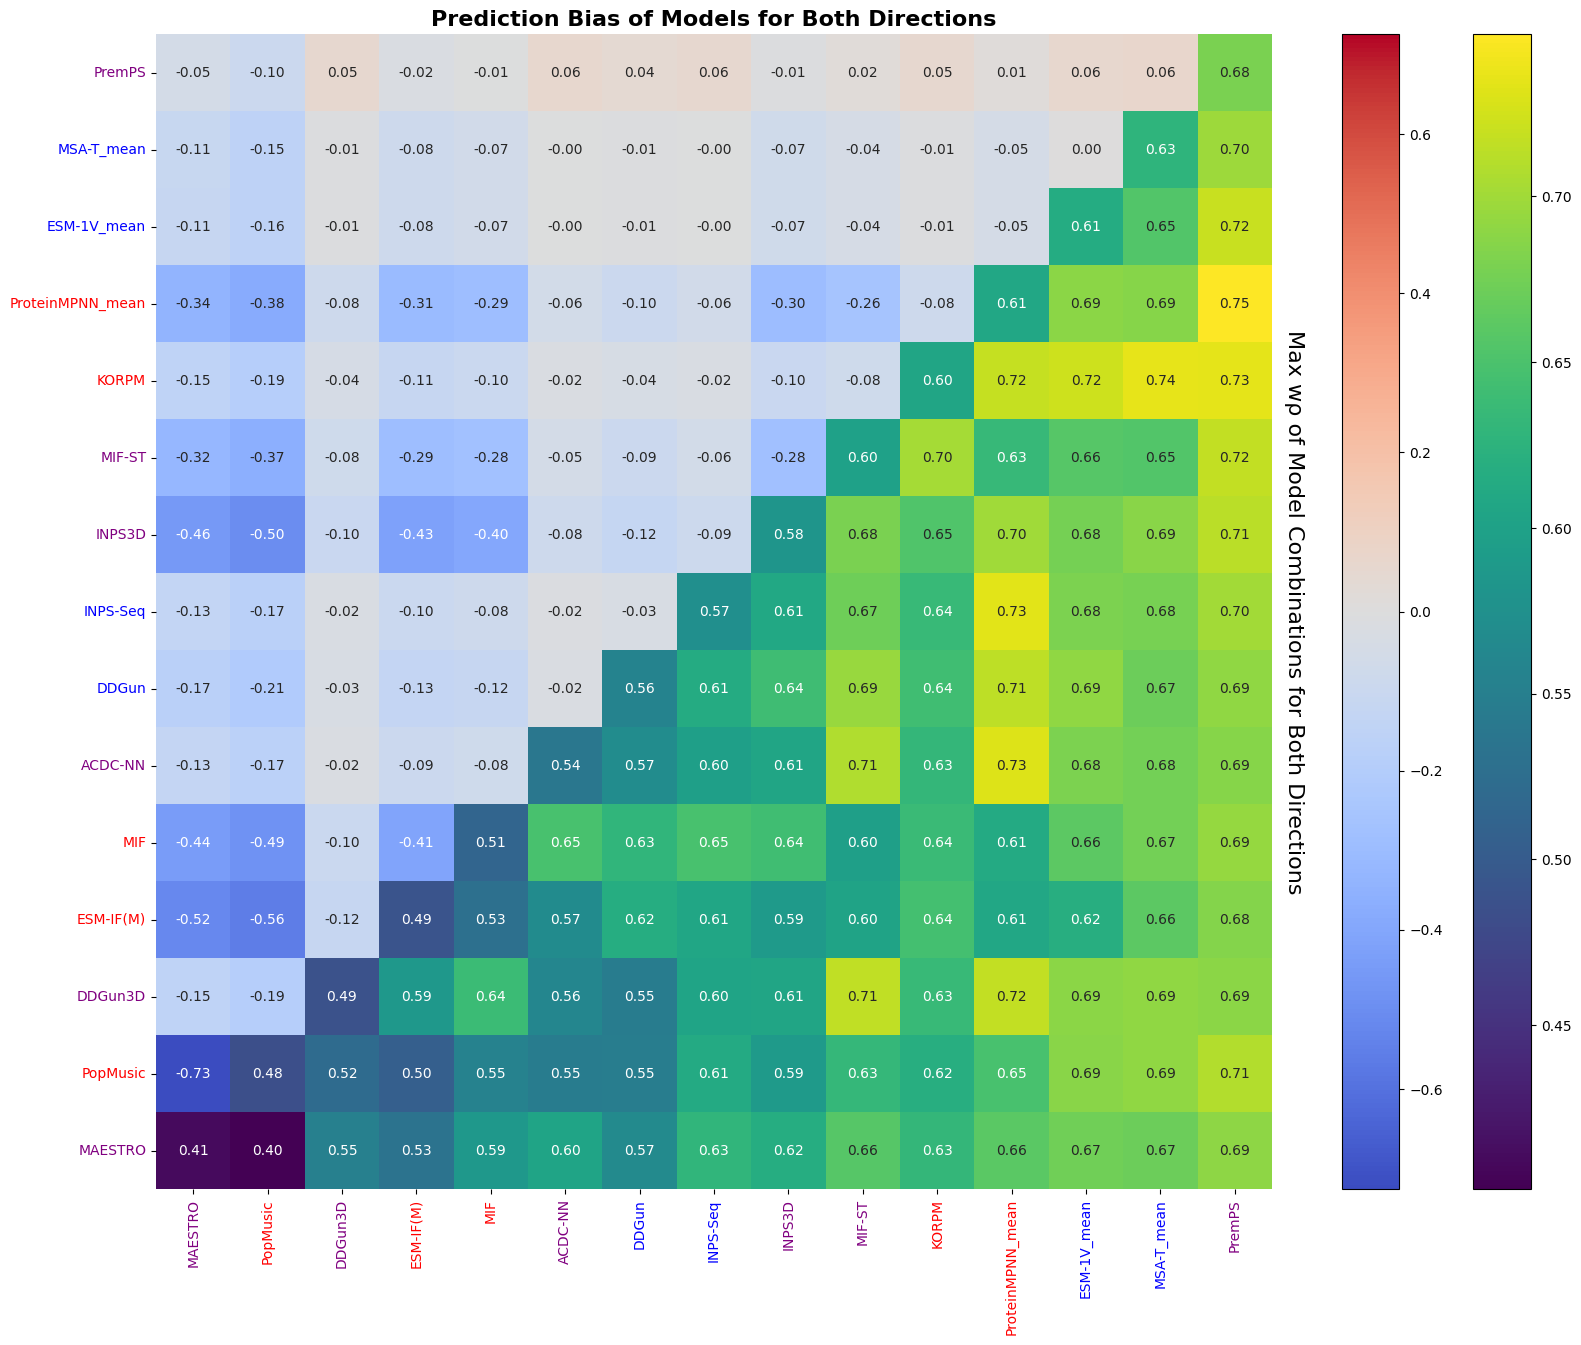

{'INPS-Seq', 'PopMusic', 'mif', 'mpnn_mean', 'DDGun3D', 'esm1v_mean', 'PremPS', 'DDGun', 'MAESTRO', 'INPS3D', 'mifst', 'korpm', 'msa_transformer_mean', 'ACDC-NN'}


model1  weight1                model2  weight2  \
rank                                                                 
1                   PremPS      1.0             mpnn_mean      1.0   
2                    korpm      1.0  msa_transformer_mean      0.5   
3                   PremPS      1.0                 korpm      1.0   
4                 INPS-Seq      1.0             mpnn_mean      1.0   
5                  ACDC-NN      1.0             mpnn_mean      1.0   
6               esm1v_mean      1.0                 korpm      1.0   
7                   PremPS      1.0            esm1v_mean      1.0   
8                    korpm      1.0             mpnn_mean      0.5   
9                  DDGun3D      1.0             mpnn_mean      1.0   
10                  PremPS      1.0                 mifst      1.0   
11                 DDGun3D      1.0                 mifst      0.5   
12                   DDGun      1.0             mpnn_mean      1.0   
13                  PremPS      1.0                INPS3D      0.5   
14                  PremPS      1.0              PopMusic      0.2   
15                 ACDC-NN      1.0                 mifst      0.5   
16                   korpm      1.0                 mifst      1.0   
17                  PremPS      1.0              INPS-Seq      0.5   
18                  INPS3D      1.0             mpnn_mean      1.0   
19                  PremPS      1.0  msa_transformer_mean      0.2   
20                   DDGun      1.0                 mifst      0.5   
21                  PremPS      1.0                   mif      1.0   
22                   DDGun      1.0            esm1v_mean      1.0   
23    msa_transformer_mean      1.0              PopMusic      0.5   
24                  PremPS      1.0                 DDGun      0.2   
25                 DDGun3D      1.0  msa_transformer_mean      0.5   
26                  PremPS      1.0               MAESTRO      0.2   
27              esm1v_mean      1.0               DDGun3D      0.5   
28                  PremPS      1.0               DDGun3D      0.5   
29              esm1v_mean      1.0             mpnn_mean      0.5   
30              esm1v_mean      1.0              PopMusic      0.5   

      weighted_spearman      corr  
rank                               
1              0.748832  0.607990  
2              0.735930  0.511250  
3              0.734227  0.645873  
4              0.733583  0.592158  
5              0.729955  0.574202  
6              0.721820  0.569713  
7              0.719600  0.793368  
8              0.718412  0.578372  
9              0.717517  0.499714  
10             0.716987  0.653144  
11             0.714844  0.516232  
12             0.714370  0.558285  
13             0.712172  0.757647  
14             0.708636  0.534252  
15             0.707496  0.595616  
16             0.702118  0.555394  
17             0.700079  0.850946  
18             0.698520  0.581779  
19             0.698127  0.744502  
20             0.694508  0.589432  
21             0.693910  0.500871  
22             0.691467  0.738425  
23             0.691012  0.376587  
24             0.690944  0.855744  
25             0.690636  0.574787  
26             0.690161  0.464799  
27             0.688895  0.671058  
28             0.688838  0.817173  
29             0.688761  0.694616  
30             0.687386  0.454733

In [27]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 #'SOL_ACC': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'weighted_spearman'
upper = 'bias'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

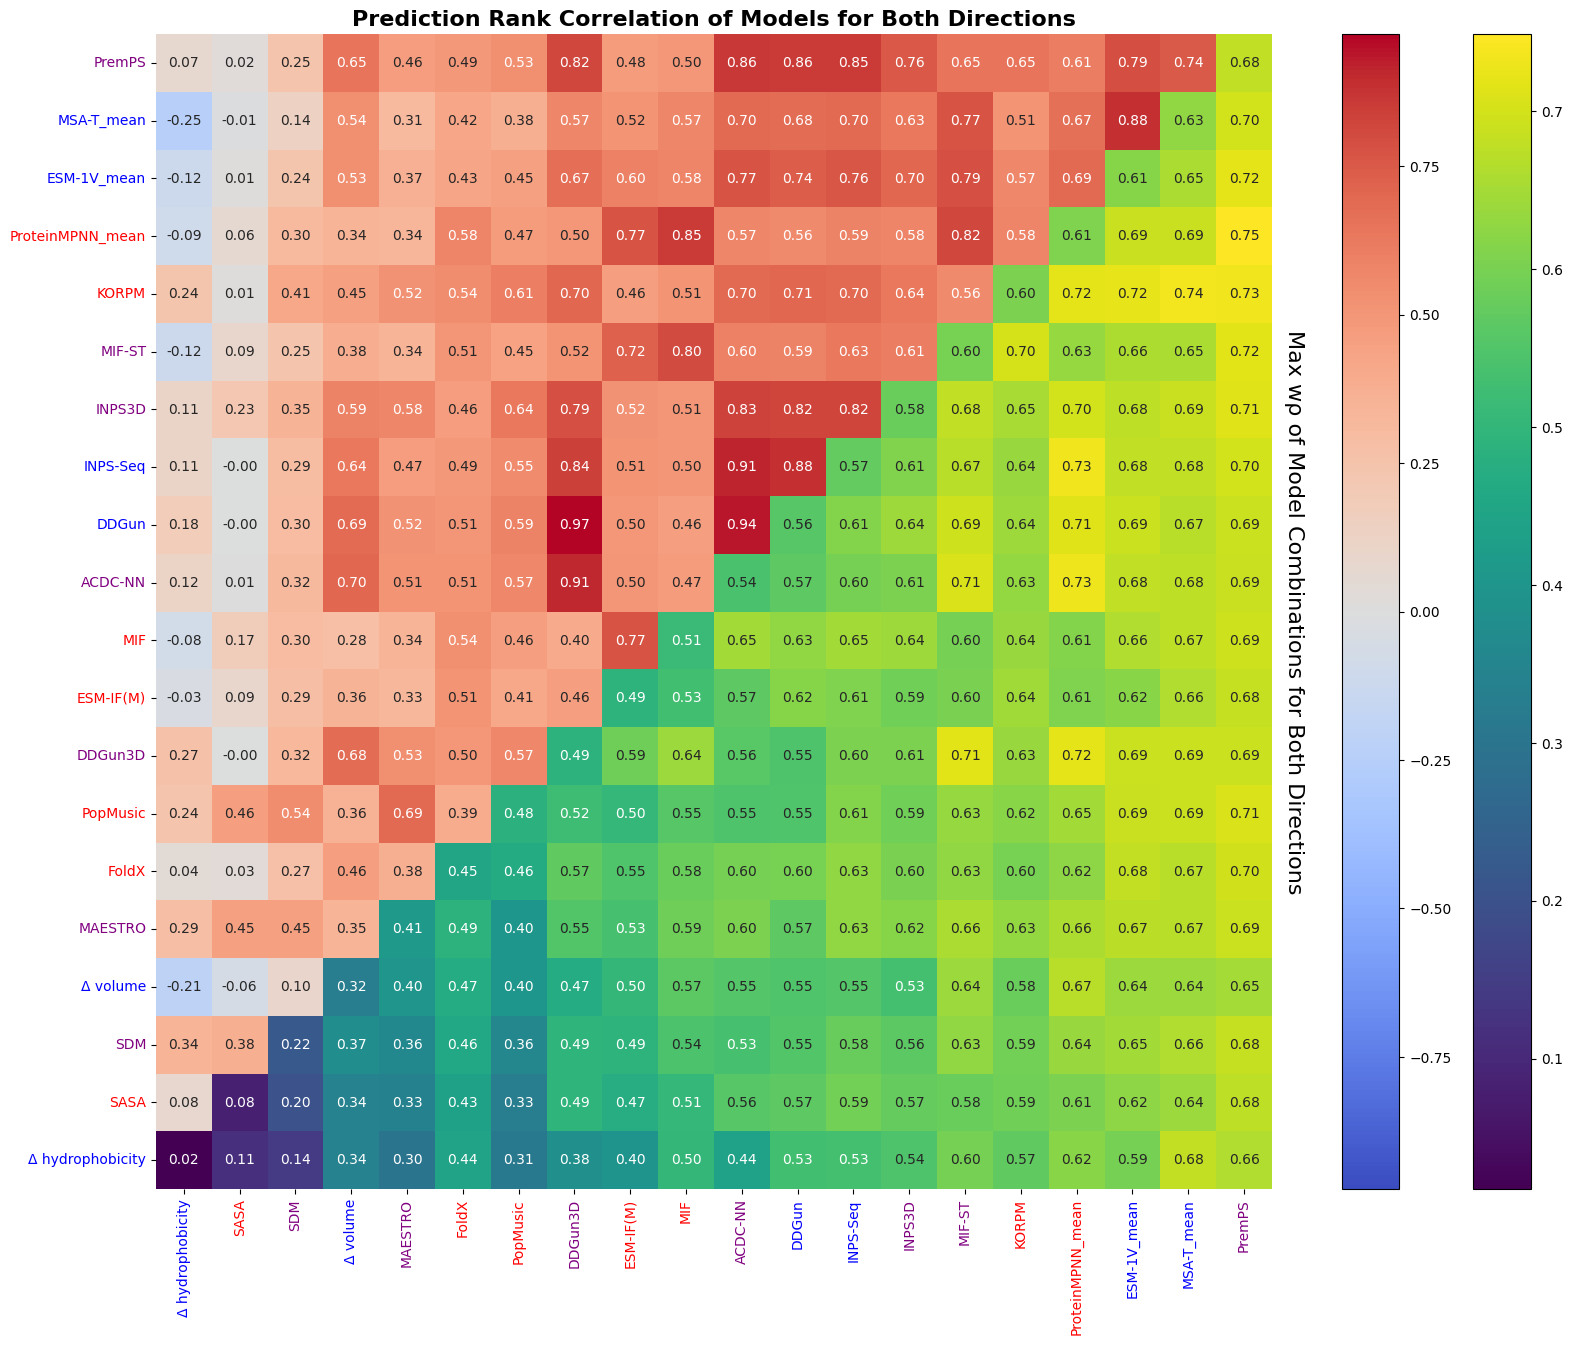

{'INPS-Seq', 'PopMusic', 'mif', 'mpnn_mean', 'DDGun3D', 'esm1v_mean', 'PremPS', 'DDGun', 'MAESTRO', 'INPS3D', 'mifst', 'FoldX', 'korpm', 'msa_transformer_mean', 'ACDC-NN'}


model1  weight1                model2  weight2  \
rank                                                                 
1                   PremPS      1.0             mpnn_mean      1.0   
2                    korpm      1.0  msa_transformer_mean      0.5   
3                   PremPS      1.0                 korpm      1.0   
4                 INPS-Seq      1.0             mpnn_mean      1.0   
5                  ACDC-NN      1.0             mpnn_mean      1.0   
6               esm1v_mean      1.0                 korpm      1.0   
7                   PremPS      1.0            esm1v_mean      1.0   
8                    korpm      1.0             mpnn_mean      0.5   
9                  DDGun3D      1.0             mpnn_mean      1.0   
10                  PremPS      1.0                 mifst      1.0   
11                 DDGun3D      1.0                 mifst      0.5   
12                   DDGun      1.0             mpnn_mean      1.0   
13                  PremPS      1.0                INPS3D      0.5   
14                  PremPS      1.0              PopMusic      0.2   
15                 ACDC-NN      1.0                 mifst      0.5   
16                   korpm      1.0                 mifst      1.0   
17                  PremPS      1.0              INPS-Seq      0.5   
18                  INPS3D      1.0             mpnn_mean      1.0   
19                  PremPS      1.0  msa_transformer_mean      0.2   
20                  PremPS      1.0                 FoldX      0.5   
21                   DDGun      1.0                 mifst      0.5   
22                  PremPS      1.0                   mif      1.0   
23                   DDGun      1.0            esm1v_mean      1.0   
24    msa_transformer_mean      1.0              PopMusic      0.5   
25                  PremPS      1.0                 DDGun      0.2   
26                 DDGun3D      1.0  msa_transformer_mean      0.5   
27                  PremPS      1.0               MAESTRO      0.2   
28              esm1v_mean      1.0               DDGun3D      0.5   
29                  PremPS      1.0               DDGun3D      0.5   
30              esm1v_mean      1.0             mpnn_mean      0.5   

      weighted_spearman      corr  
rank                               
1              0.748832  0.607990  
2              0.735930  0.511250  
3              0.734227  0.645873  
4              0.733583  0.592158  
5              0.729955  0.574202  
6              0.721820  0.569713  
7              0.719600  0.793368  
8              0.718412  0.578372  
9              0.717517  0.499714  
10             0.716987  0.653144  
11             0.714844  0.516232  
12             0.714370  0.558285  
13             0.712172  0.757647  
14             0.708636  0.534252  
15             0.707496  0.595616  
16             0.702118  0.555394  
17             0.700079  0.850946  
18             0.698520  0.581779  
19             0.698127  0.744502  
20             0.695626  0.487964  
21             0.694508  0.589432  
22             0.693910  0.500871  
23             0.691467  0.738425  
24             0.691012  0.376587  
25             0.690944  0.855744  
26             0.690636  0.574787  
27             0.690161  0.464799  
28             0.688895  0.671058  
29             0.688838  0.817173  
30             0.688761  0.694616

In [28]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'FoldX',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 'delta_kdh': 'blue',
                 'delta_vol': 'blue',
                 'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'weighted_spearman'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auppc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auppc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

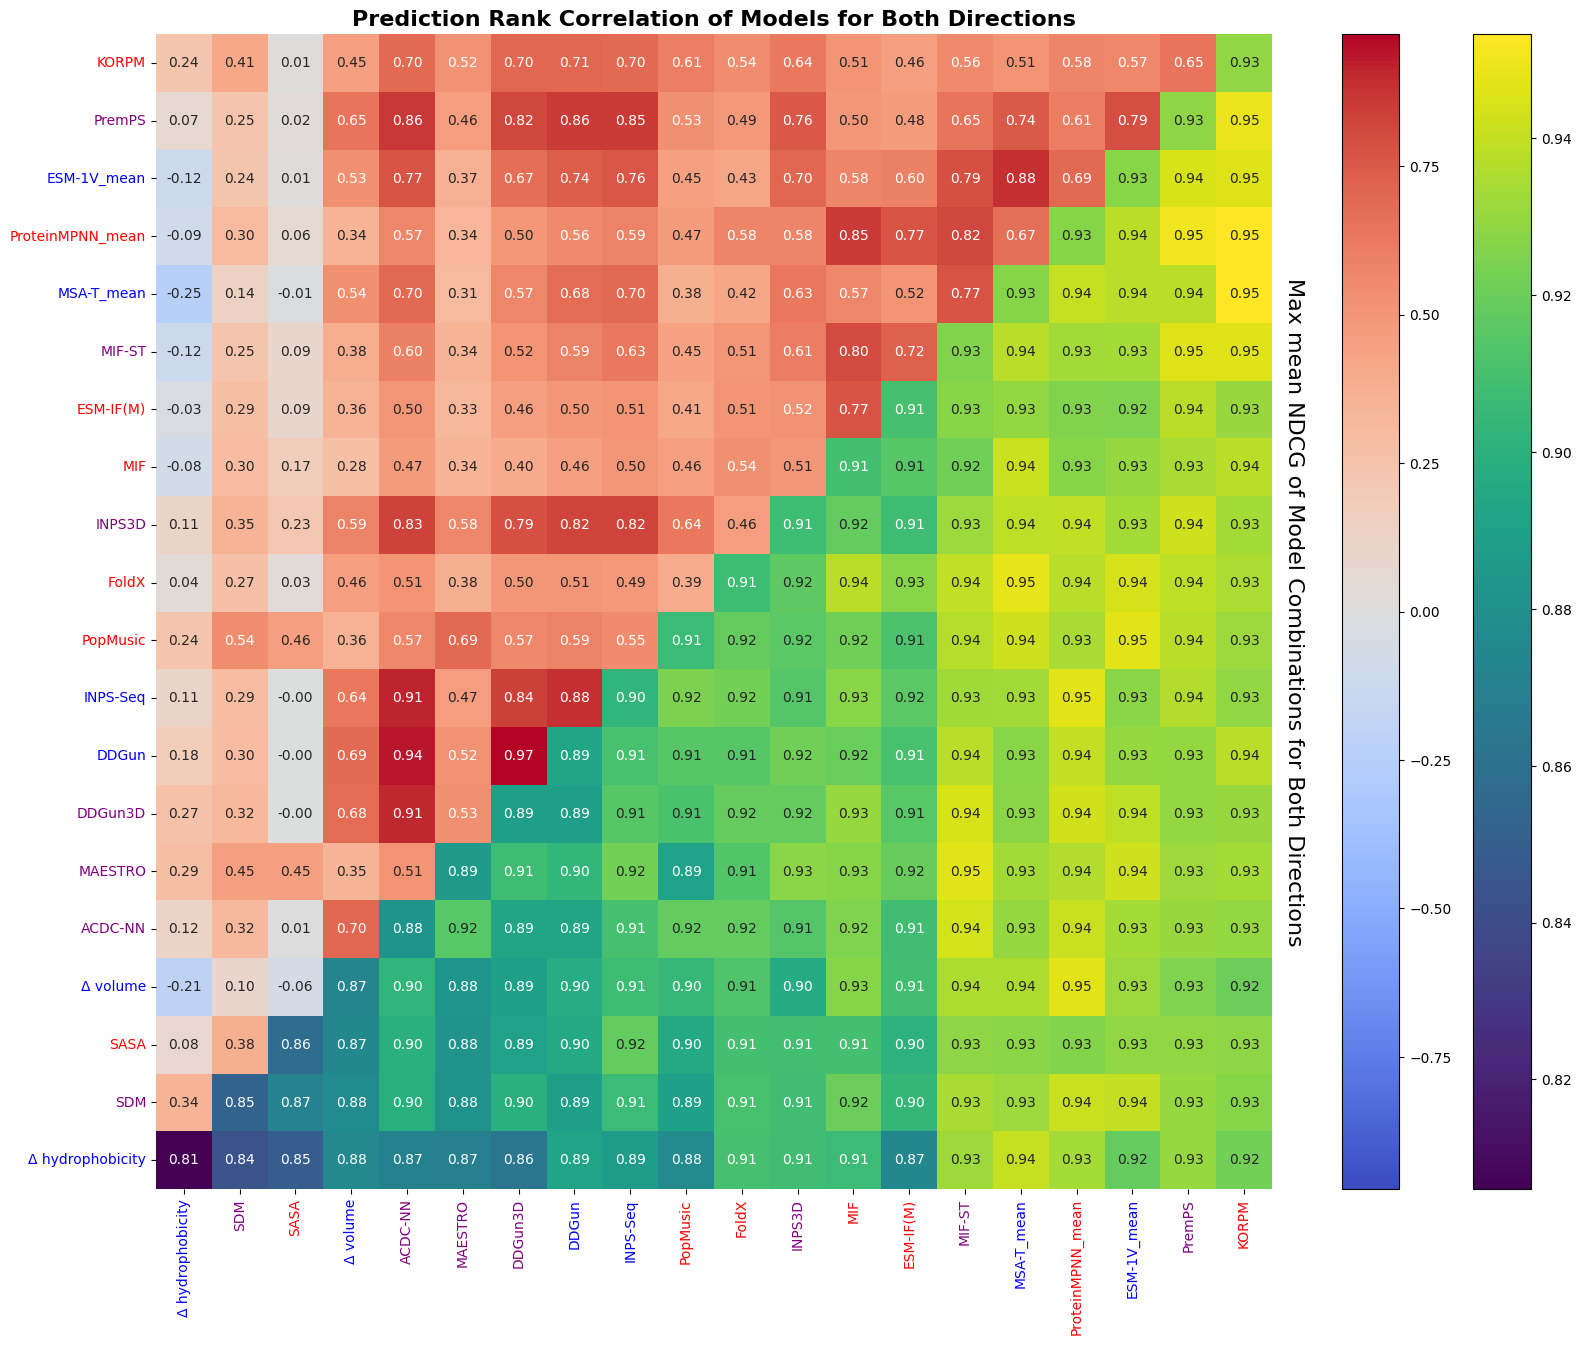

{'INPS-Seq', 'PopMusic', 'mif', 'mpnn_mean', 'DDGun3D', 'PremPS', 'esm1v_mean', 'DDGun', 'MAESTRO', 'INPS3D', 'mifst', 'SDM', 'delta_vol', 'delta_kdh', 'FoldX', 'korpm', 'msa_transformer_mean', 'ACDC-NN'}


model1  weight1                model2  weight2  mean_ndcg  \
rank                                                                            
1                    korpm      1.0             mpnn_mean      0.5   0.953325   
2                    korpm      1.0  msa_transformer_mean      0.5   0.952832   
3                   PremPS      1.0             mpnn_mean      1.0   0.949973   
4                   PremPS      1.0                 korpm      1.0   0.948276   
5                    FoldX      1.0  msa_transformer_mean      1.0   0.948017   
6                 INPS-Seq      1.0             mpnn_mean      1.0   0.946619   
7                mpnn_mean      1.0             delta_vol      0.5   0.946601   
8                    mifst      1.0               MAESTRO      0.5   0.946560   
9               esm1v_mean      1.0              PopMusic      0.5   0.946453   
10                   korpm      1.0                 mifst      1.0   0.946338   
11                  PremPS      1.0                 mifst      1.0   0.945636   
12                   korpm      1.0            esm1v_mean      0.5   0.945550   
13                 DDGun3D      1.0                 mifst      1.0   0.944476   
14              esm1v_mean      1.0                PremPS      0.5   0.944141   
15                   FoldX      1.0            esm1v_mean      1.0   0.943884   
16                   mifst      1.0               ACDC-NN      0.5   0.943248   
17                 DDGun3D      1.0             mpnn_mean      1.0   0.942807   
18                  PremPS      1.0                INPS3D      0.5   0.942371   
19              esm1v_mean      1.0               MAESTRO      0.5   0.941916   
20    msa_transformer_mean      1.0              PopMusic      0.5   0.941845   
21    msa_transformer_mean      1.0                   mif      0.5   0.941570   
22               mpnn_mean      1.0                   SDM      0.2   0.940749   
23                 ACDC-NN      1.0             mpnn_mean      1.0   0.940746   
24    msa_transformer_mean      1.0             delta_kdh      0.5   0.940585   
25               mpnn_mean      1.0  msa_transformer_mean      1.0   0.940259   
26              esm1v_mean      1.0                   SDM      0.5   0.939664   
27                   DDGun      1.0             mpnn_mean      1.0   0.939610   
28                   FoldX      1.0                 mifst      1.0   0.939364   
29                  INPS3D      1.0             mpnn_mean      1.0   0.938999   
30              esm1v_mean      1.0               DDGun3D      0.5   0.938519   

          corr  
rank            
1     0.578372  
2     0.511250  
3     0.607990  
4     0.645873  
5     0.424128  
6     0.592158  
7     0.343121  
8     0.344385  
9     0.454733  
10    0.555394  
11    0.653144  
12    0.569713  
13    0.516232  
14    0.793368  
15    0.431609  
16    0.595616  
17    0.499714  
18    0.757647  
19    0.367093  
20    0.376587  
21    0.569810  
22    0.304110  
23    0.574202  
24   -0.249320  
25    0.666909  
26    0.239339  
27    0.558285  
28    0.505465  
29    0.581779  
30    0.671058

In [29]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'FoldX',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 'delta_kdh': 'blue',
                 'delta_vol': 'blue',
                 'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'mean_ndcg'
upper = 'corr'

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

In [30]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

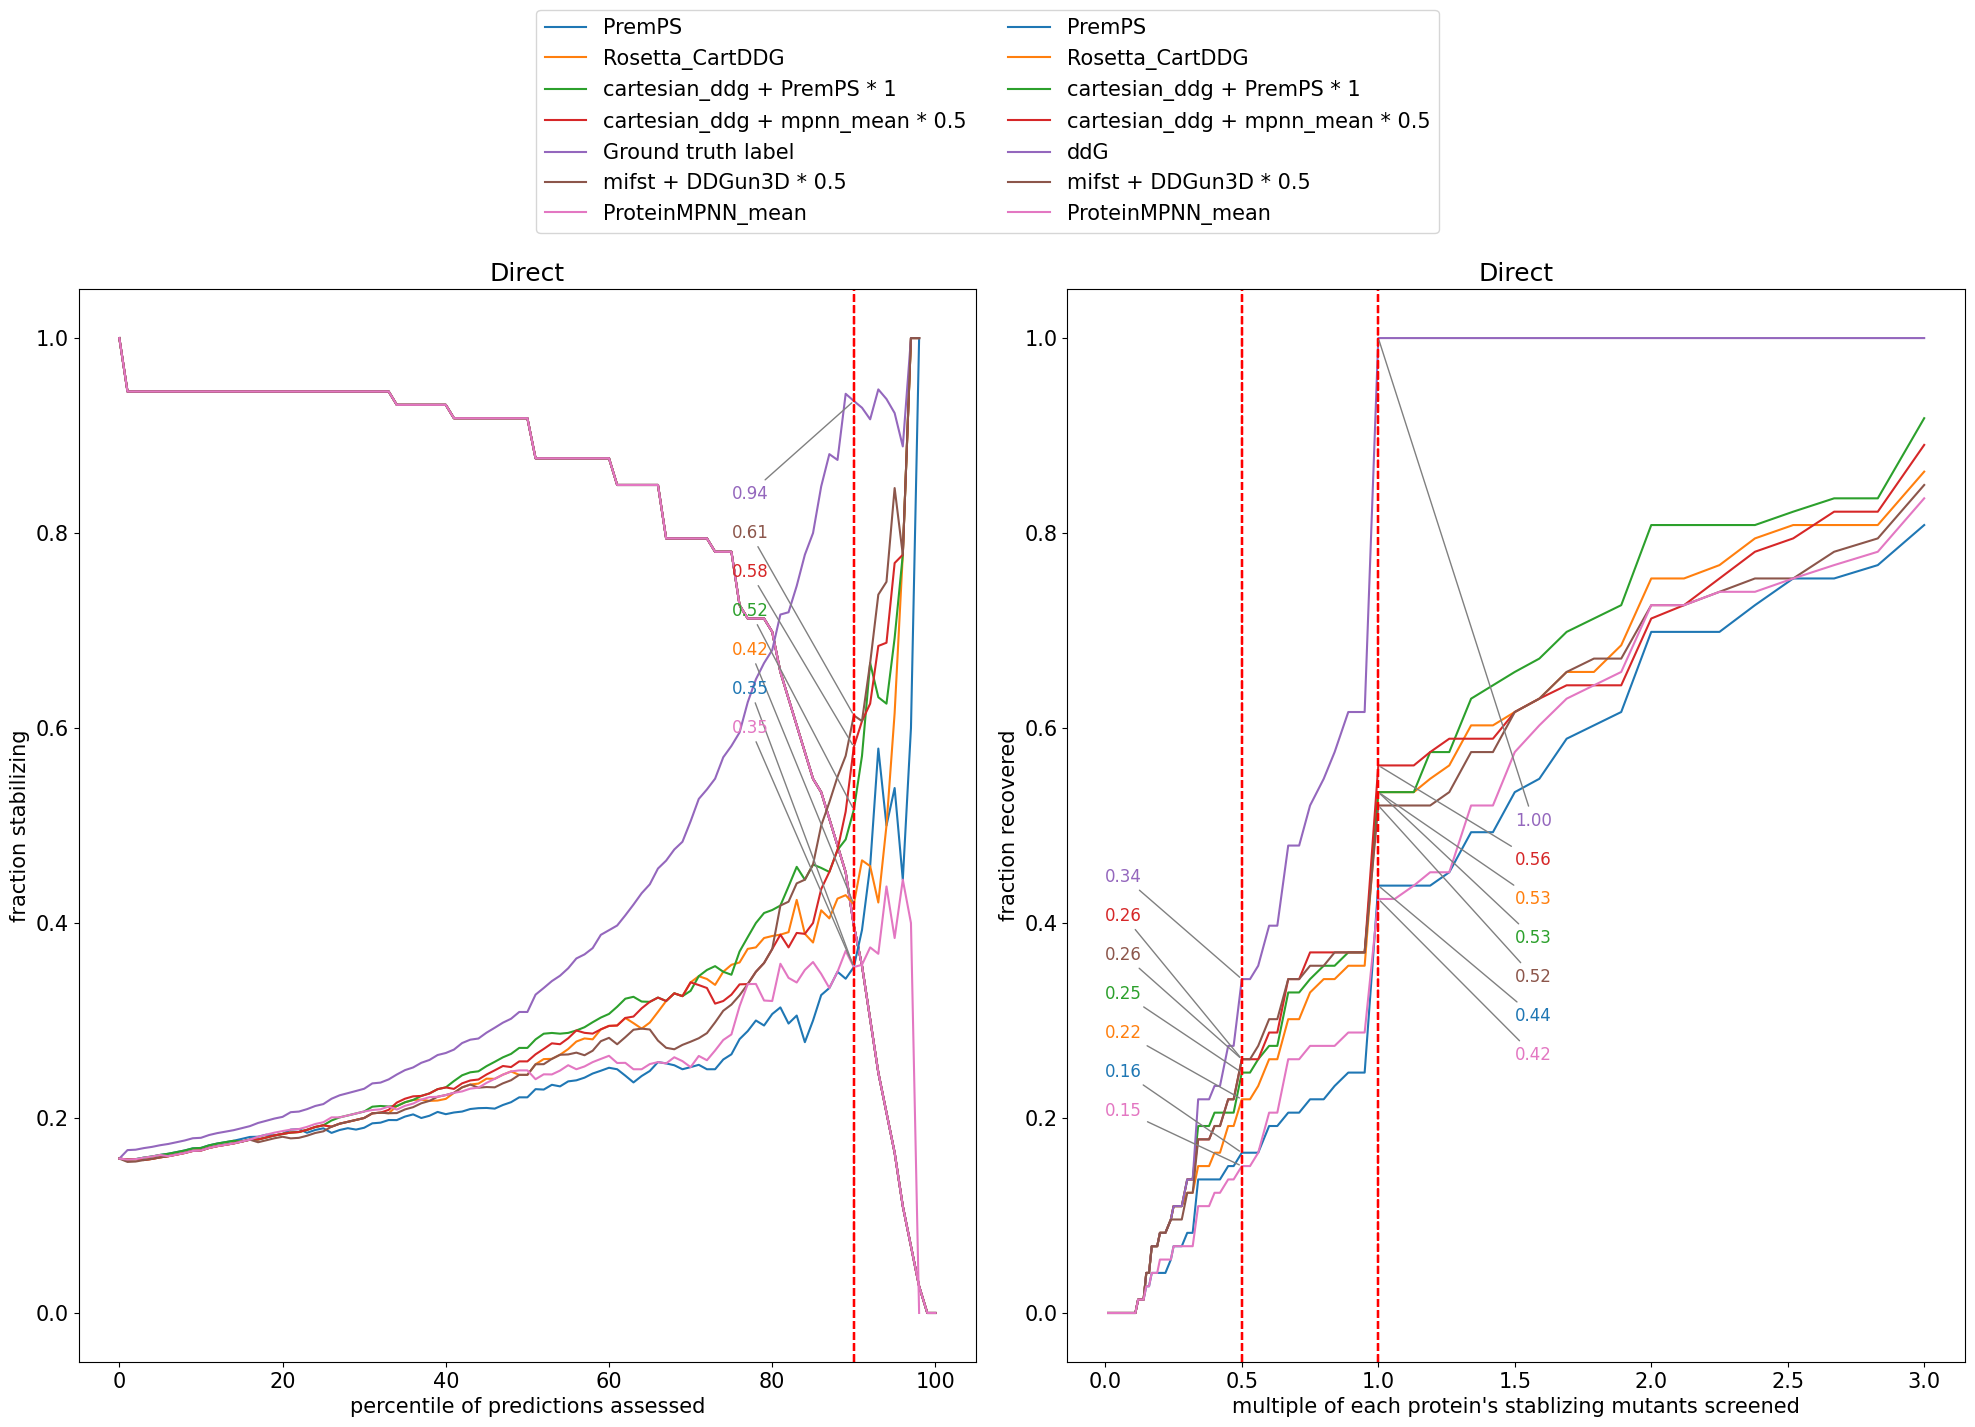

In [31]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'cartesian_ddg + PremPS * 1', 'mifst + DDGun3D * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'ddG'], #'esm1v_mean', 'PremPS', 'korpm', 'ddG', 'random', 'DDGun3D', 'INPS3D'
    percentile_labels=[90], x_recovery_labels=[0.5, 1], text_offset=(0.5, 0.1), spacing=0.04, directions=['dir'])

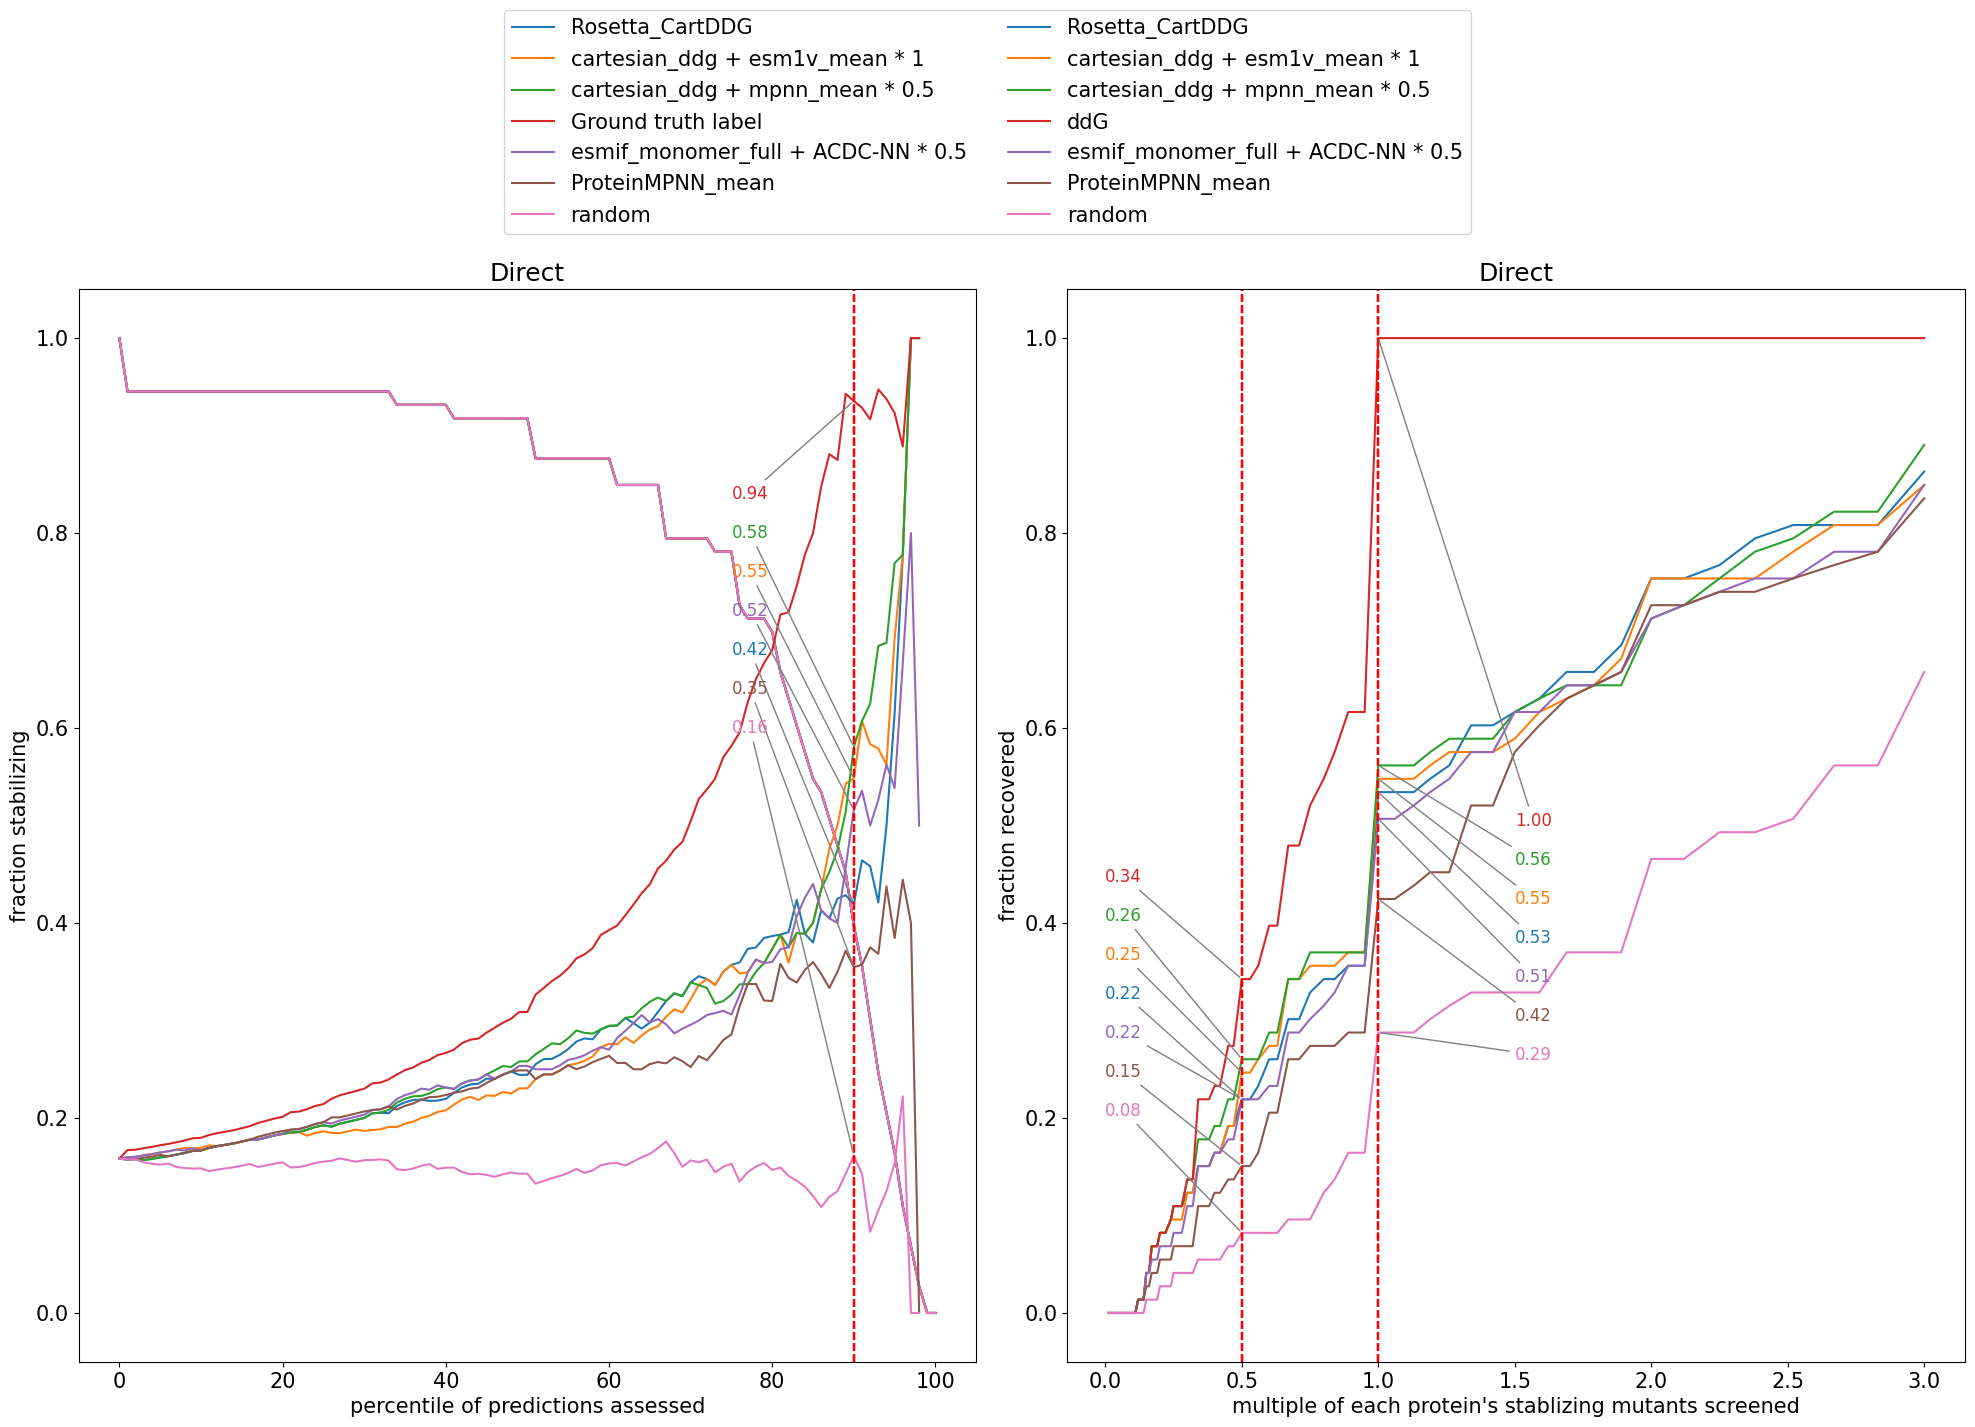

In [32]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'cartesian_ddg + esm1v_mean * 1', 'esmif_monomer_full + ACDC-NN * 0.5', 'mpnn_mean', 'cartesian_ddg', 'ddG', 'random'], #'esm1v_mean', 'PremPS', 'korpm', 'ddG', 'random', 'DDGun3D', 'INPS3D'
    percentile_labels=[90], x_recovery_labels=[0.5, 1], text_offset=(0.5, 0.1), spacing=0.04, directions=['dir'])

In [33]:
#analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'INPS3D', 'DDGun3D', 'esm1v_mean', 'cartesian_ddg', 'korpm', 'ddG', 'random'], #'esm1v_mean', 'PremPS', 'korpm', 'ddG', 'random', 'DDGun3D', 'INPS3D'
#    percentile_labels=[90], x_recovery_labels=[0.5, 1], text_offset=(0.5, 0.1), spacing=0.045, directions=['dir', 'inv'])

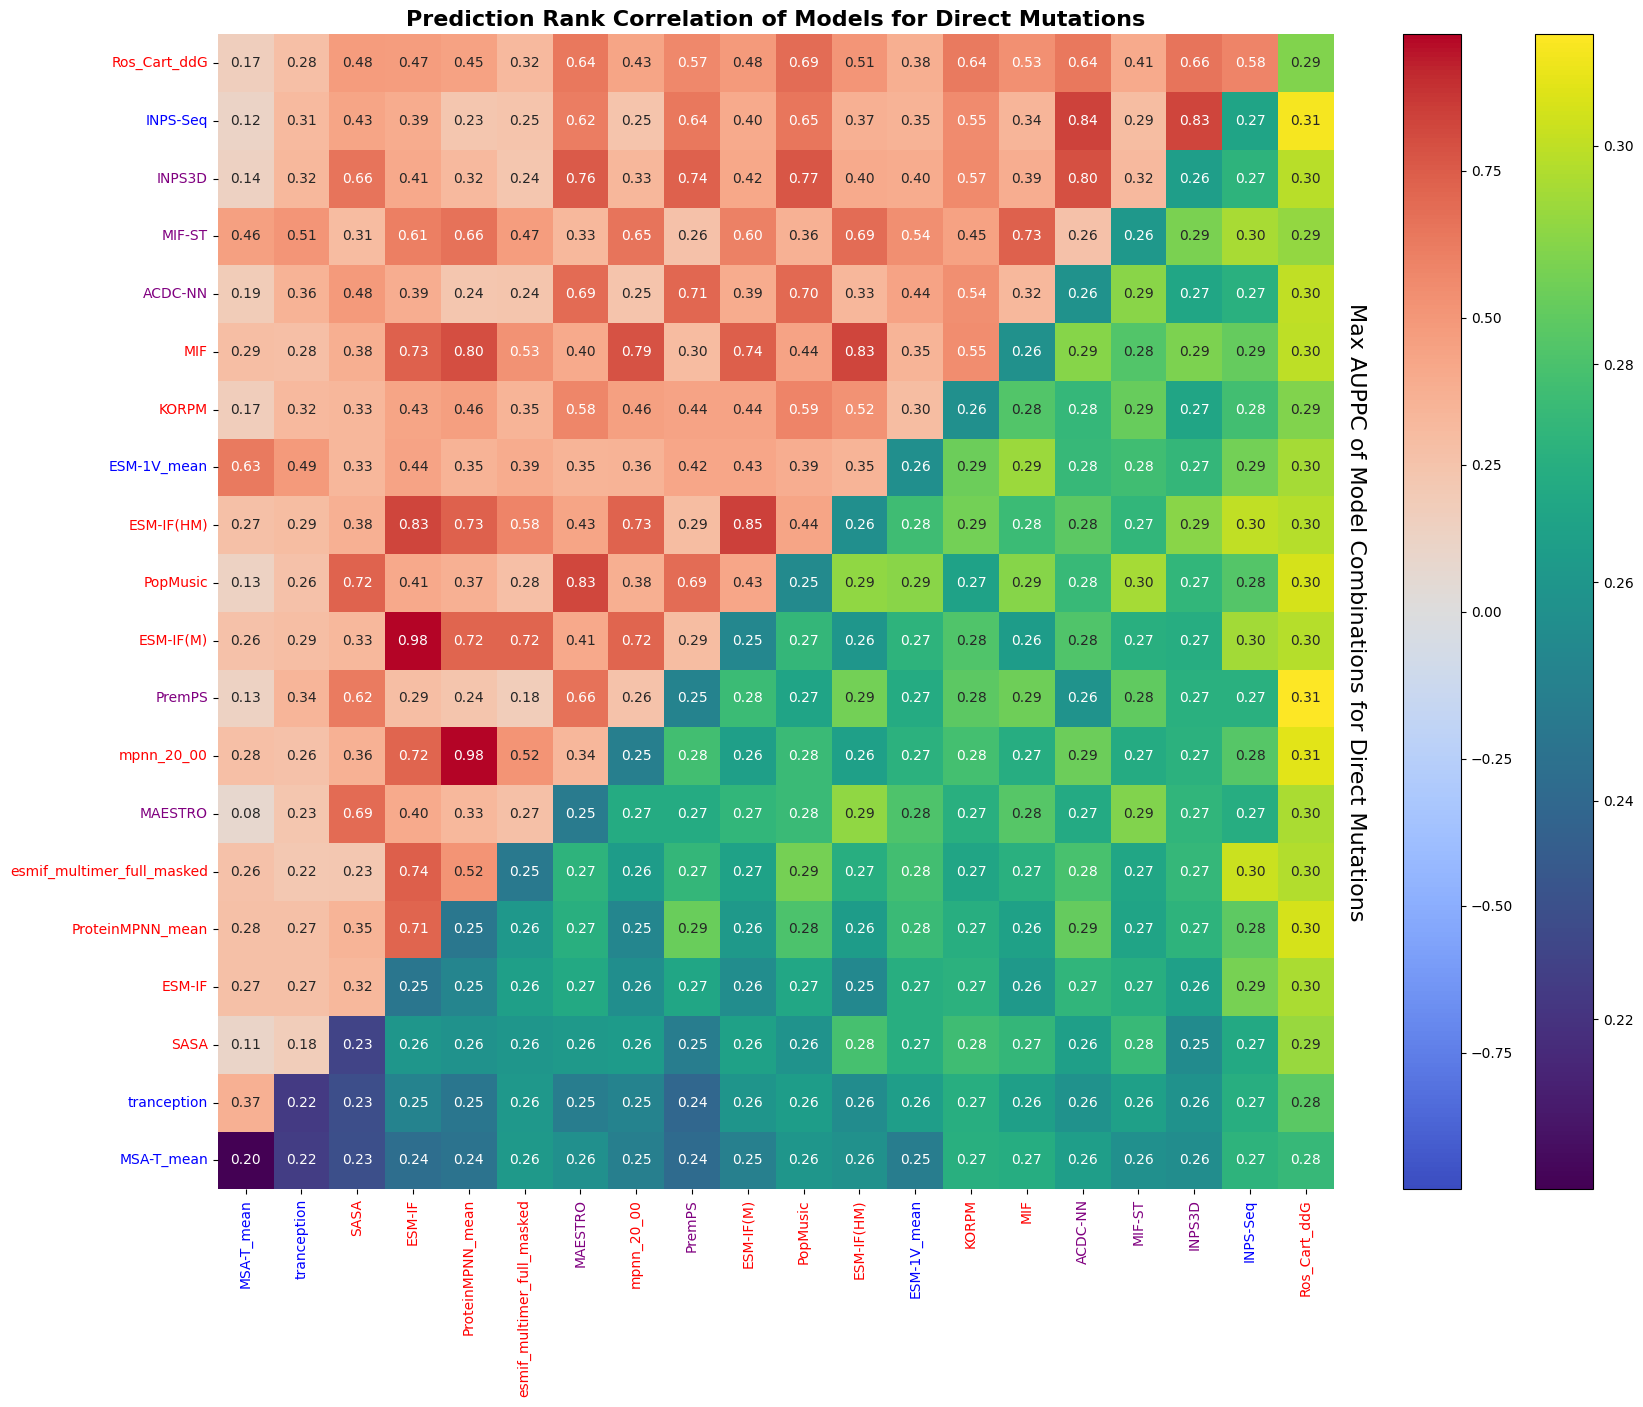

{'esmif_monomer', 'cartesian_ddg', 'INPS-Seq', 'PopMusic', 'mif', 'mpnn_20_00', 'PremPS', 'mpnn_mean', 'MAESTRO', 'esm1v_mean', 'esmif_multimer_full_masked', 'SOL_ACC', 'INPS3D', 'mifst', 'esmif_monomer_full', 'esmif_multimer_full', 'ACDC-NN'}


model1  weight1                      model2  weight2  \
rank                                                                     
1                 PremPS      1.0               cartesian_ddg      1.0   
2          cartesian_ddg      1.0                    INPS-Seq      0.5   
3          cartesian_ddg      1.0                  mpnn_20_00      0.5   
4          cartesian_ddg      1.0                    PopMusic      0.5   
5          cartesian_ddg      1.0                   mpnn_mean      0.5   
6               INPS-Seq      1.0  esmif_multimer_full_masked      0.5   
7               INPS-Seq      1.0               esmif_monomer      1.0   
8          cartesian_ddg      1.0                     ACDC-NN      0.5   
9          cartesian_ddg      1.0                         mif      0.2   
10         cartesian_ddg      1.0                      INPS3D      0.5   
11         cartesian_ddg      1.0          esmif_monomer_full      0.5   
12         cartesian_ddg      1.0               esmif_monomer      0.2   
13         cartesian_ddg      1.0  esmif_multimer_full_masked      0.5   
14         cartesian_ddg      1.0                     MAESTRO      0.5   
15         cartesian_ddg      1.0         esmif_multimer_full      0.5   
16              INPS-Seq      1.0                       mifst      0.5   
17         cartesian_ddg      1.0                  esm1v_mean      0.2   
18              PopMusic      1.0                       mifst      1.0   
19    esmif_monomer_full      1.0                    INPS-Seq      0.5   
20                   mif      1.0                  esm1v_mean      0.5   
21         cartesian_ddg      1.0                     SOL_ACC      0.2   
22         cartesian_ddg      1.0                       mifst      0.2   
23              PopMusic      1.0               esmif_monomer      1.0   
24         esmif_monomer      1.0                     MAESTRO      0.5   
25         esmif_monomer      1.0                      INPS3D      0.5   
26              PopMusic      1.0                  esm1v_mean      1.0   
27               ACDC-NN      1.0                       mifst      1.0   
28               ACDC-NN      1.0                         mif      1.0   
29              PopMusic      1.0                         mif      1.0   
30         cartesian_ddg      1.0               cartesian_ddg      0.0   

         ausrc      corr  
rank                      
1     0.310211  0.569589  
2     0.308807  0.583659  
3     0.305529  0.433732  
4     0.303533  0.686340  
5     0.303288  0.447594  
6     0.301620  0.250753  
7     0.300278  0.372338  
8     0.300221  0.639492  
9     0.299806  0.531008  
10    0.298807  0.655554  
11    0.298550  0.484843  
12    0.298226  0.508268  
13    0.298206  0.318826  
14    0.296810  0.643816  
15    0.296712  0.474205  
16    0.296242  0.293851  
17    0.296098  0.380562  
18    0.295978  0.362126  
19    0.295346  0.404000  
20    0.294287  0.352413  
21    0.294035  0.482826  
22    0.292935  0.406438  
23    0.292686  0.436719  
24    0.292468  0.431204  
25    0.291480  0.403168  
26    0.291407  0.385235  
27    0.291284  0.262504  
28    0.291197  0.322828  
29    0.290842  0.444223  
30    0.290207  1.000000

In [34]:
'INPS-Seq', 'PremPS', 'mif', 'esm1v_mean', 'esmif_monomer_full', 'KORPMD', 'mpnn_mean', 'msa_transformer_mean', 'tranception_red', 
'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'CartddgD', 'SDM', 'tranception', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'

custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 #'DDGun': 'blue',
                 #'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 'tranception': 'blue',
                 'esmif_monomer': 'red',
                 'esmif_multimer_full': 'red',
                 'esmif_monomer_full': 'red',
                 'korpm': 'red',
                 'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_20_00': 'red',
                 'mpnn_mean': 'red',
                 'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'dir'
statistic = 'ausrc'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out

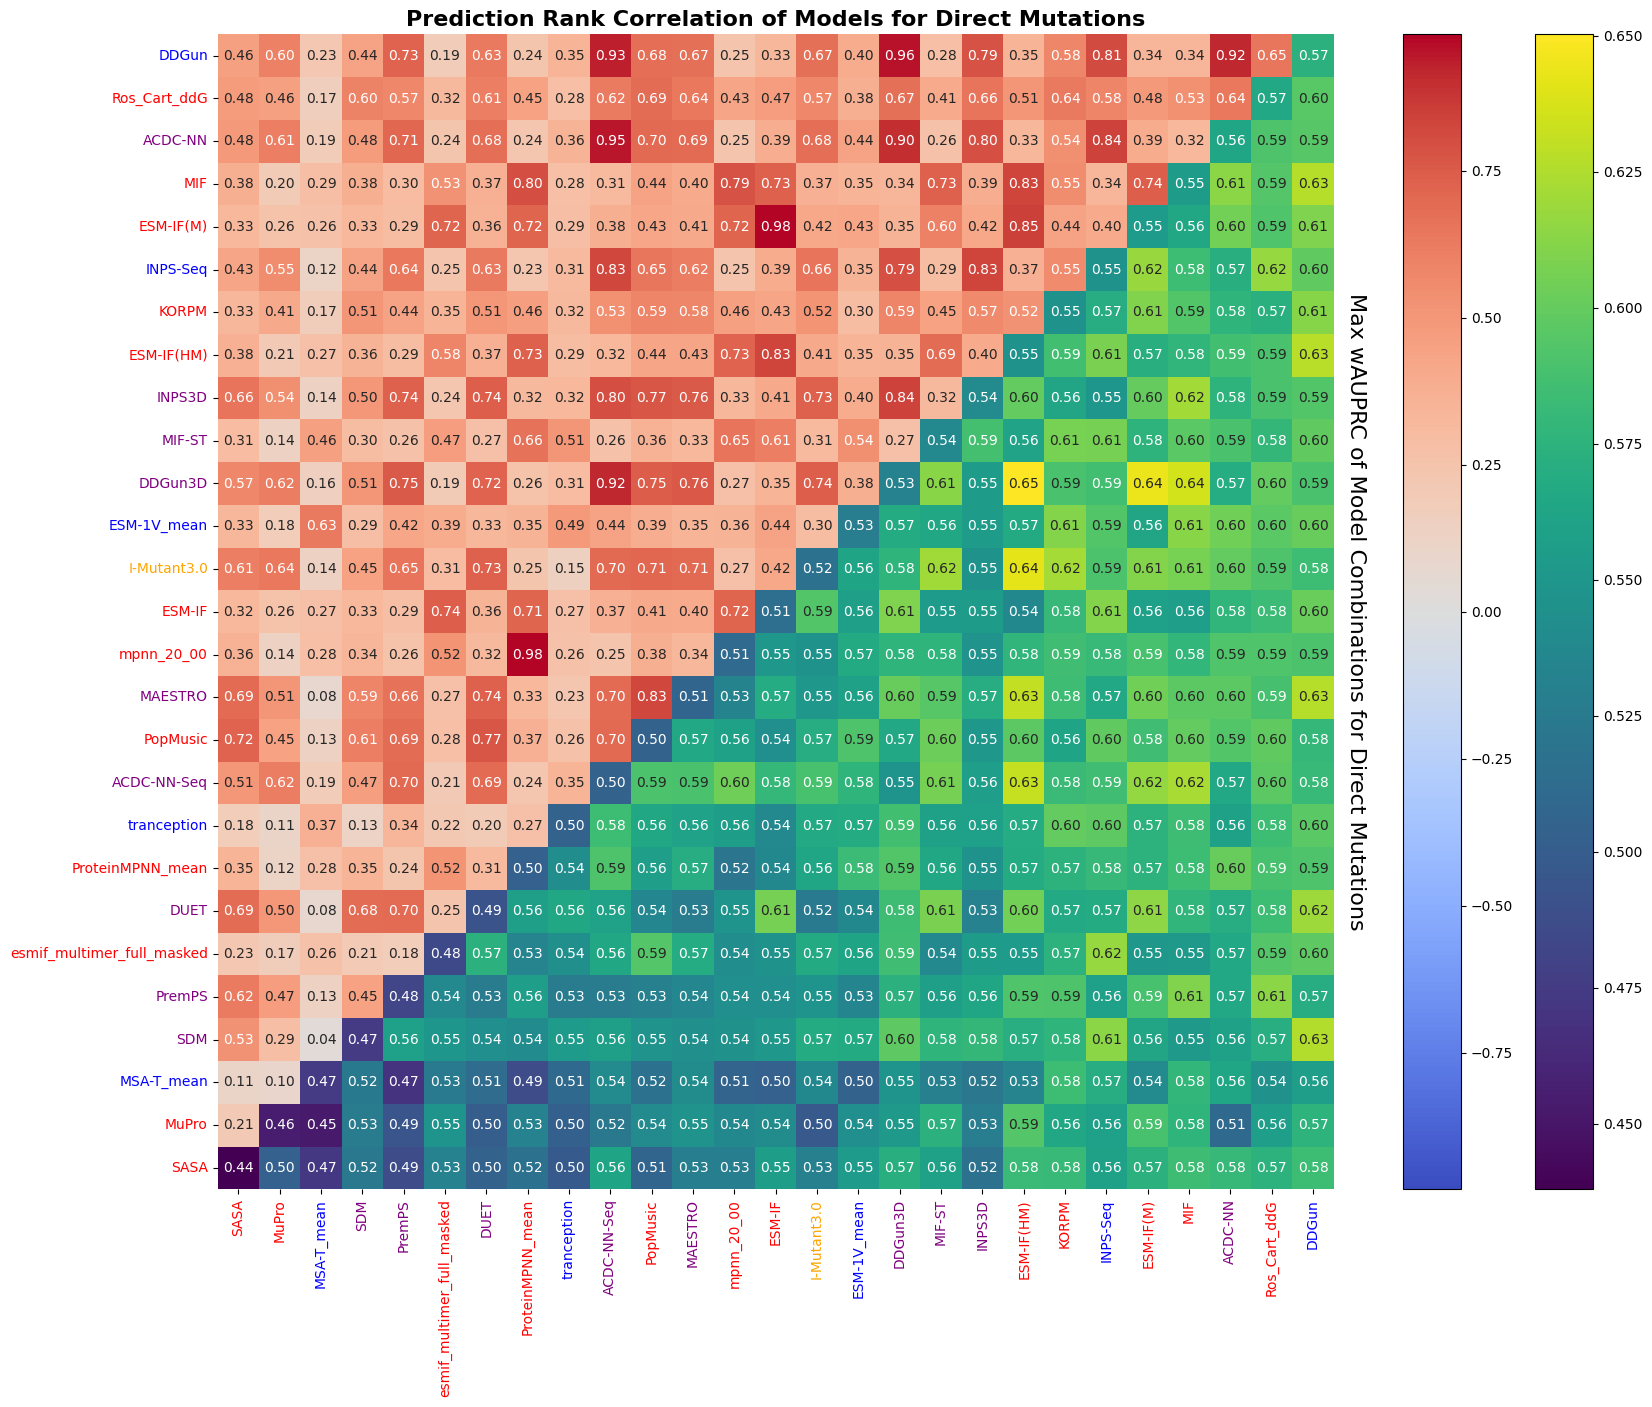

{'INPS3D', 'mifst', 'SDM', 'DUET', 'MAESTRO', 'esmif_monomer', 'INPS-Seq', 'esm1v_mean', 'esmif_monomer_full', 'cartesian_ddg', 'esmif_multimer_full_masked', 'ACDC-NN-Seq', 'I-Mutant3.0', 'ACDC-NN', 'mif', 'DDGun3D', 'PremPS', 'DDGun', 'esmif_multimer_full', 'korpm'}


model1  weight1                      model2  weight2  \
rank                                                                     
1                DDGun3D      1.0               esmif_monomer      1.0   
2                DDGun3D      1.0          esmif_monomer_full      1.0   
3          esmif_monomer      1.0                 I-Mutant3.0      0.5   
4                DDGun3D      1.0                         mif      1.0   
5          esmif_monomer      1.0                 ACDC-NN-Seq      0.5   
6          esmif_monomer      1.0                     MAESTRO      0.5   
7          esmif_monomer      1.0                       DDGun      0.5   
8                  DDGun      1.0                     MAESTRO      1.0   
9                  DDGun      1.0                         mif      1.0   
10                 DDGun      1.0                         SDM      0.5   
11           ACDC-NN-Seq      1.0                         mif      1.0   
12           I-Mutant3.0      1.0                       korpm      0.5   
13                   mif      1.0                      INPS3D      0.5   
14           I-Mutant3.0      1.0                       mifst      1.0   
15                 DDGun      1.0                        DUET      1.0   
16    esmif_monomer_full      1.0                    INPS-Seq      0.5   
17              INPS-Seq      1.0  esmif_multimer_full_masked      0.5   
18              INPS-Seq      1.0               cartesian_ddg      1.0   
19    esmif_monomer_full      1.0                 ACDC-NN-Seq      0.5   
20                  DUET      1.0          esmif_monomer_full      1.0   
21                PremPS      1.0               cartesian_ddg      1.0   
22               ACDC-NN      1.0                         mif      1.0   
23              INPS-Seq      1.0                         SDM      0.5   
24                   mif      1.0                  esm1v_mean      0.5   
25               DDGun3D      1.0                       mifst      1.0   
26                 korpm      1.0                       DDGun      0.5   
27    esmif_monomer_full      1.0                 I-Mutant3.0      0.5   
28                 korpm      1.0                  esm1v_mean      0.5   
29              INPS-Seq      1.0         esmif_multimer_full      1.0   
30    esmif_monomer_full      1.0                       korpm      0.5   

      weighted_auprc      corr  
rank                            
1           0.650229  0.352891  
2           0.644253  0.353248  
3           0.641394  0.406586  
4           0.635953  0.344654  
5           0.631769  0.324104  
6           0.631039  0.431204  
7           0.627158  0.348253  
8           0.626426  0.673964  
9           0.626337  0.337738  
10          0.625655  0.438455  
11          0.622321  0.312970  
12          0.621641  0.515830  
13          0.620537  0.390429  
14          0.619757  0.311531  
15          0.618916  0.633858  
16          0.617861  0.404000  
17          0.616863  0.250753  
18          0.616768  0.583659  
19          0.615434  0.380043  
20          0.614282  0.362396  
21          0.613435  0.569589  
22          0.613395  0.322828  
23          0.613194  0.440106  
24          0.612431  0.352413  
25          0.612281  0.273023  
26          0.611875  0.580973  
27          0.611255  0.421901  
28          0.611162  0.297954  
29          0.611110  0.392268  
30          0.610219  0.443332

In [35]:
{'DUET', 'INPS3D', 'INPS-Seq', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 
'mpnn_mean', 'tranception_red', 'MuPro', 'MAESTRO', 'mifst', 'korpm', 'esmif_monomer', 'SDM', 'tranception', 'mpnn_20_00', 
'esmif_multimer_full', 'ACDC-NN-Seq', 'I-Mutant3.0'}


custom_colors = {'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 'tranception': 'blue',
                 'esmif_monomer': 'red',
                 'esmif_multimer_full': 'red',
                 'esmif_monomer_full': 'red',
                 'korpm': 'red',
                 'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_20_00': 'red',
                 'mpnn_mean': 'red',
                 'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'dir'
statistic = 'weighted_auprc'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out

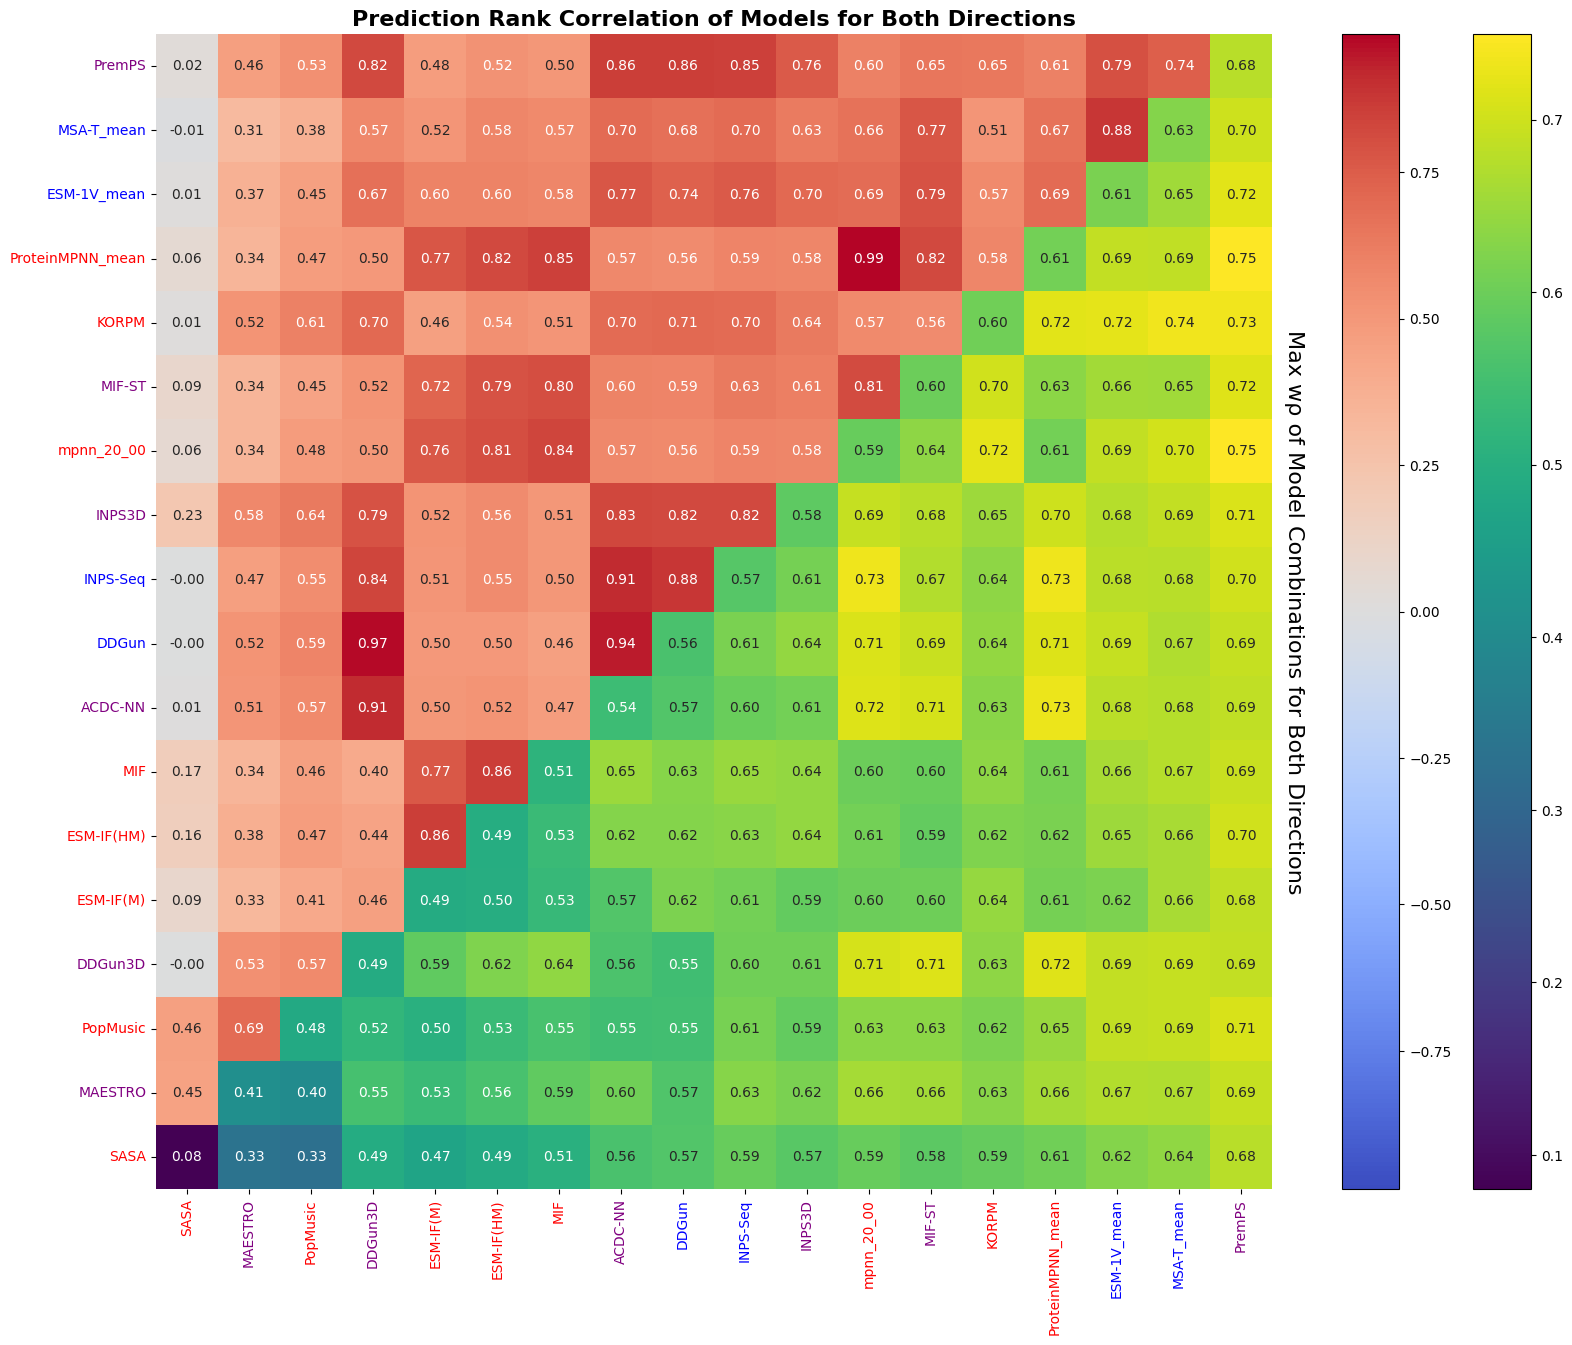

{'esmif_monomer', 'INPS-Seq', 'PopMusic', 'mpnn_20_00', 'mpnn_mean', 'DDGun3D', 'esm1v_mean', 'PremPS', 'DDGun', 'mif', 'INPS3D', 'mifst', 'korpm', 'msa_transformer_mean', 'ACDC-NN'}


model1  weight1                model2  weight2  weighted_spearman  \
rank                                                                          
1         PremPS      1.0            mpnn_20_00      1.0           0.749527   
2         PremPS      1.0             mpnn_mean      1.0           0.748832   
3          korpm      1.0  msa_transformer_mean      0.5           0.735930   
4         PremPS      1.0                 korpm      1.0           0.734227   
5       INPS-Seq      1.0             mpnn_mean      1.0           0.733583   
6       INPS-Seq      1.0            mpnn_20_00      1.0           0.731743   
7        ACDC-NN      1.0             mpnn_mean      1.0           0.729955   
8     esm1v_mean      1.0                 korpm      1.0           0.721820   
9          korpm      1.0            mpnn_20_00      0.5           0.720982   
10        PremPS      1.0            esm1v_mean      1.0           0.719600   
11         korpm      1.0             mpnn_mean      0.5           0.718412   
12       DDGun3D      1.0             mpnn_mean      1.0           0.717517   
13        PremPS      1.0                 mifst      1.0           0.716987   
14       ACDC-NN      1.0            mpnn_20_00      1.0           0.715325   
15       DDGun3D      1.0                 mifst      0.5           0.714844   
16         DDGun      1.0             mpnn_mean      1.0           0.714370   
17        PremPS      1.0                INPS3D      0.5           0.712172   
18         DDGun      1.0            mpnn_20_00      1.0           0.710676   
19        PremPS      1.0              PopMusic      0.2           0.708636   
20       ACDC-NN      1.0                 mifst      0.5           0.707496   
21       DDGun3D      1.0            mpnn_20_00      1.0           0.706798   
22    mpnn_20_00      1.0  msa_transformer_mean      1.0           0.702825   
23         korpm      1.0                 mifst      1.0           0.702118   
24        PremPS      1.0         esmif_monomer      1.0           0.701121   
25        PremPS      1.0              INPS-Seq      0.5           0.700079   
26        INPS3D      1.0             mpnn_mean      1.0           0.698520   
27        PremPS      1.0  msa_transformer_mean      0.2           0.698127   
28         DDGun      1.0                 mifst      0.5           0.694508   
29        PremPS      1.0                   mif      1.0           0.693910   
30         DDGun      1.0            esm1v_mean      1.0           0.691467   

          corr  
rank            
1     0.602636  
2     0.607990  
3     0.511250  
4     0.645873  
5     0.592158  
6     0.589786  
7     0.574202  
8     0.569713  
9     0.569813  
10    0.793368  
11    0.578372  
12    0.499714  
13    0.653144  
14    0.574726  
15    0.516232  
16    0.558285  
17    0.757647  
18    0.562303  
19    0.534252  
20    0.595616  
21    0.503960  
22    0.664261  
23    0.555394  
24    0.524625  
25    0.850946  
26    0.581779  
27    0.744502  
28    0.589432  
29    0.500871  
30    0.738425

In [36]:
custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 'esmif_monomer': 'red',
                 'esmif_multimer_full': 'red',
                 'esmif_monomer_full': 'red',
                 'korpm': 'red',
                 'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_20_00': 'red',
                 'mpnn_mean': 'red',
                 'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'weighted_spearman'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

UnboundLocalError: local variable 'top_1_stab' referenced before assignment

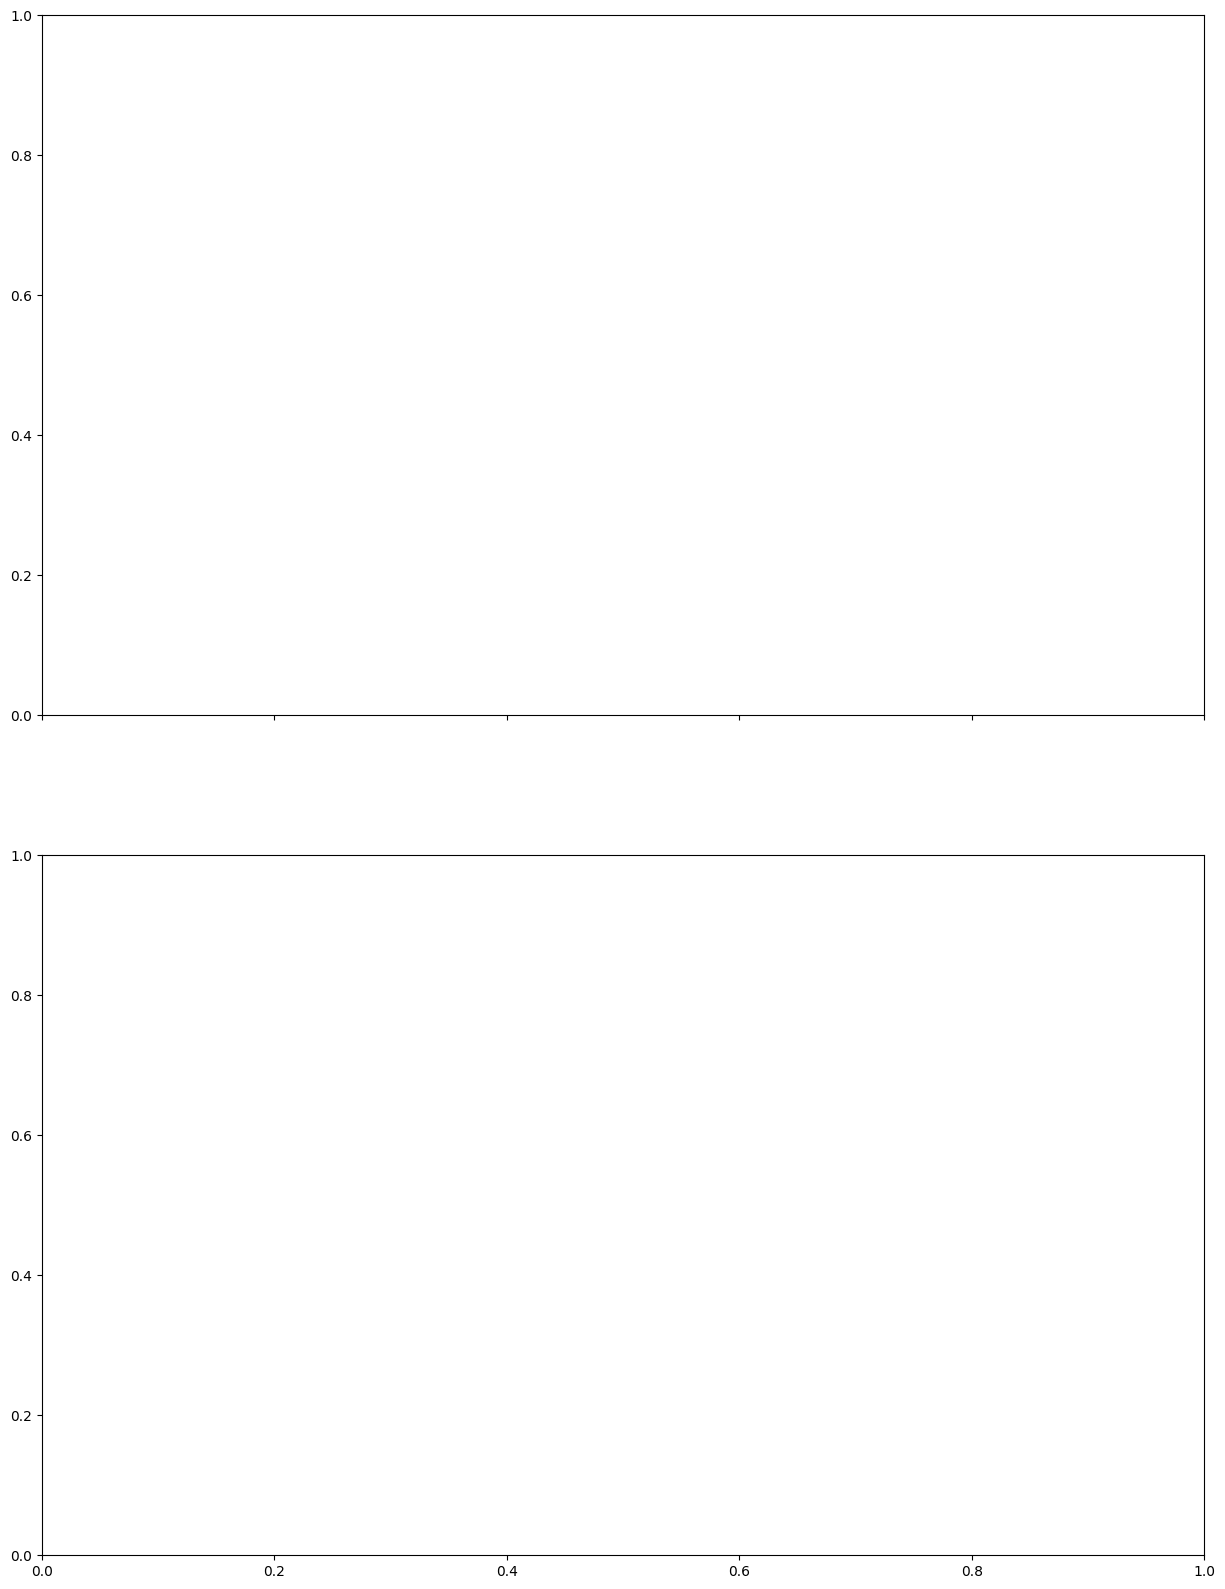

In [37]:
db_nona = db_complete.dropna(subset=[col for col in db_complete.columns if any(substring+'_dir' in col for substring in custom_colors.keys())], how='any')
#db_nona = db_complete

#columns_to_check = [col for col in db_complete.columns if any(substring in col for substring in custom_colors.keys())]
#filtered_columns = db_complete[columns_to_check].dropna(how='any', axis=1)
#db_nona = pd.concat([db_complete.drop(columns=columns_to_check), filtered_columns], axis=1)

d = analysis_utils.compare_performance_2(db_nona.drop('code', axis=1),
                                         threshold_1 = 0.5, 
                                         threshold_2 = None, 
                                         split_col = 'direction_split', 
                                         split_col_2 = None, 
                                         direction = 'combined',
                                         statistic = 'auprc')

In [ ]:
d

NameError: name 'd' is not defined

In [ ]:
db_complete

ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1A7V_104H        -0.495499         0.495499    -0.333256     0.308649   
1A7V_13H          0.000000         0.000000    -0.155792     0.154150   
1A7V_20H         -0.002231         0.002231    -0.171187     0.144576   
1A7V_31H         -0.013802         0.013802    -0.160372     0.160372   
...                    ...              ...          ...          ...   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   
5VP3_128G        -0.701056         0.701056    -0.510884     0.537406   
5VP3_183T        -1.375923         1.375923    -0.657788     0.658870   
5VP3_39K         -0.406377         0.406377    -0.501640     0.528053   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1A7V_104H         -0.1          0.1       -0.5        0.5    -0.467     0.566   
1A7V_13H           0.3         -0.3        0.6       -0.7    -0.819     0.533   
1A7V_20H           0.3         -0.3        0.7       -0.7    -0.866     0.687   
1A7V_31H           0.1         -0.1        0.7       -0.7    -0.099     0.687   
...                ...          ...        ...        ...       ...       ...   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   
5VP3_128G         -0.8          0.8       -0.9        0.8    -1.163    -1.231   
5VP3_183T         -1.2          1.3       -1.3        1.2    -2.097    -0.135   
5VP3_39K          -1.0          1.0       -1.2        1.3    -0.803    -0.274   

           ...  from_proline  from_glycine  helix   bend   turn   coil  \
uid        ...                                                           
1A0F_11A   ...         False         False  False  False   True  False   
1A7V_104H  ...         False         False   True  False  False  False   
1A7V_13H   ...         False         False   True  False  False  False   
1A7V_20H   ...         False         False   True  False  False  False   
1A7V_31H   ...         False         False  False  False  False   True   
...        ...           ...           ...    ...    ...    ...    ...   
5JXB_25P   ...         False         False  False   True  False  False   
5OAQ_199H  ...         False         False  False  False  False  False   
5VP3_128G  ...         False         False   True  False  False  False   
5VP3_183T  ...         False         False   True  False  False  False   
5VP3_39K   ...         False         False   True  False  False  False   

           strand  xray_else_NMR  active_site          neff  
uid                                                          
1A0F_11A    False           True        False  11312.451628  
1A7V_104H   False           True        False   3970.041972  
1A7V_13H    False           True        False   3970.041972  
1A7V_20H    False           True        False   3970.041972  
1A7V_31H    False           True        False   3970.041972  
...           ...            ...          ...           ...  
5JXB_25P    False           True        False    112.986182  
5OAQ_199H    True           True        False    197.028468  
5VP3_128G   False           True        False   2051.798630  
5VP3_183T   False           True        False   2051.798630  
5VP3_39K    False           True        False   2051.798630  

[669 rows x 113 columns]

Average prediction for stabilized protein: -5.272661443210841
Average experimental value for predicted stabilized: 0.06032558139534879


n_expt_stable                          166.000000
P(pred_stable|stable) - sensitivity      0.132530
P(pred_stable|unstable) - FPR            0.042596
n_pred_stable                           43.000000
P(stable|pred_stable) - PPV              0.534884
P(stable|pred_unstable) - FOR            0.235390
dtype: float64

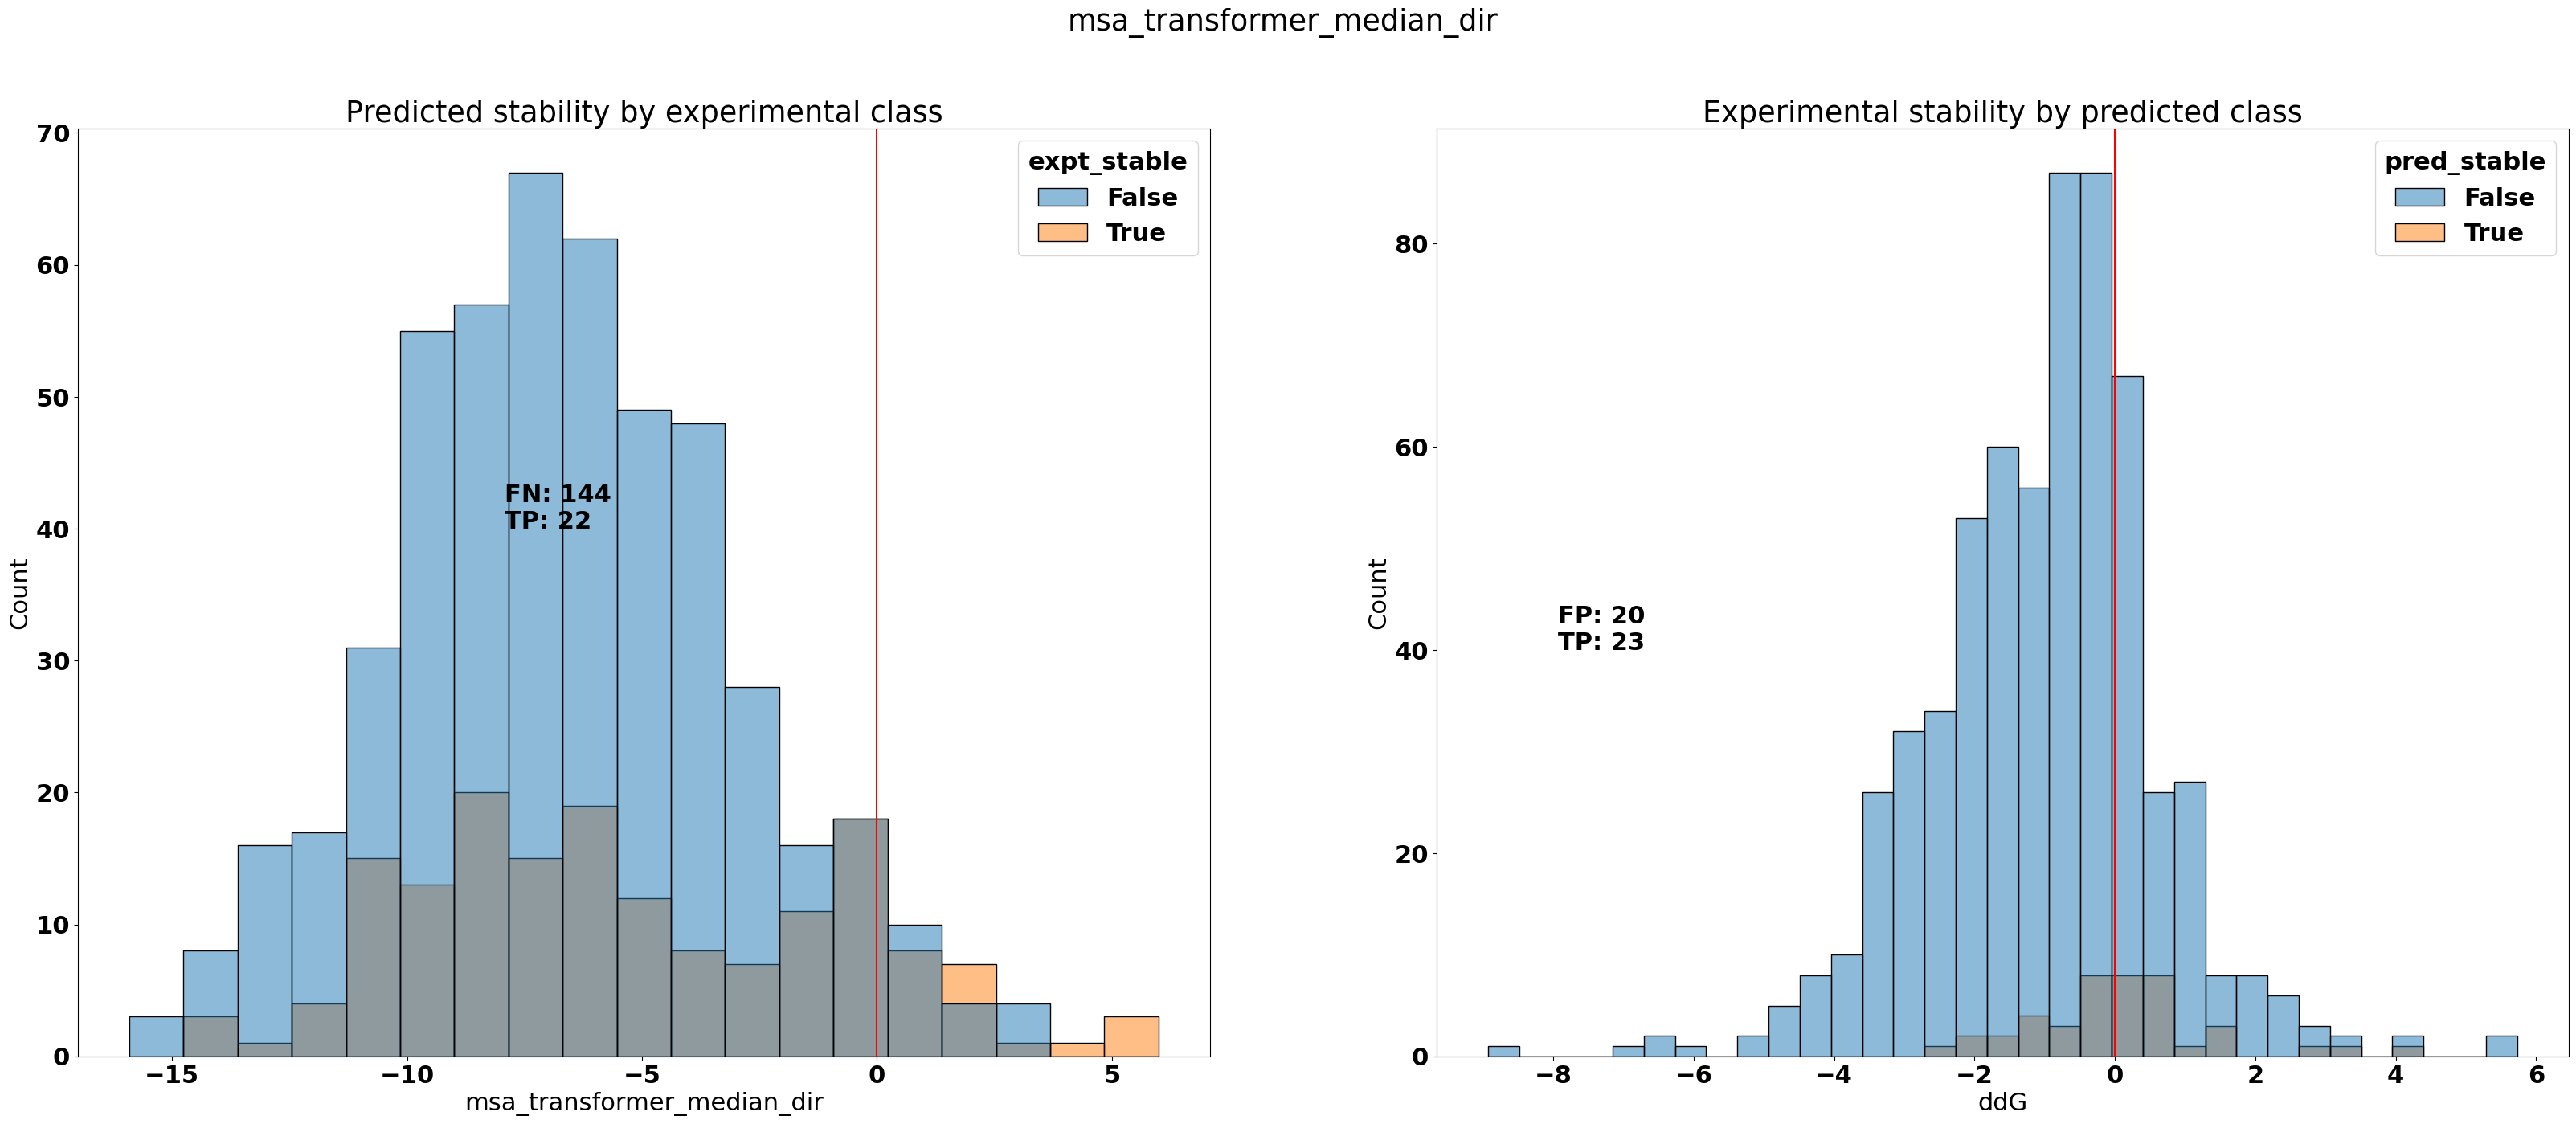

In [ ]:
def compare_stable_dists(db_complete, score_name, score_name_2=None, full=False, decision_threshold_ddg=0, decision_threshold_score=0):
    dbf = db_complete.copy(deep=True)

    if full:
        if '_dir' in score_name or '_inv' in score_name:
            score_name = score_name[:-4]
        if score_name_2 is not None and ('_dir' in score_name_2 or '_inv' in score_name_2):
            score_name_2 = score_name_2[:-4]
        dbf = stack_frames(dbf)

    dbf = dbf.loc[:, [score_name, 'ddG']]
    min_score = dbf[score_name].min() + 1
    min_ddg = dbf['ddG'].min() + 1

    df_out = pd.Series(index = ['n_expt_stable', 'P(pred_stable|stable) - sensitivity', 'P(pred_stable|unstable) - FPR',\
                                 'n_pred_stable', 'P(stable|pred_stable) - PPV', 'P(stable|pred_unstable) - FOR'], dtype=float)
    fig, axs = plt.subplots(1, 2, figsize=(40, 15))
    fig.suptitle(score_name)

    # separate all of the data based on whether or not it is (on median) stabilizing in experiment
    stable = dbf.loc[dbf['ddG'] > decision_threshold_ddg, :].dropna().copy()
    stable['expt_stable'] = True
    unstable = dbf.loc[dbf['ddG'] <= decision_threshold_ddg, :].dropna().copy()
    unstable['expt_stable'] = False
    to_plot = pd.concat([stable, unstable])

    # calculate statistics about predictions conditioned on ground truth
    df_out['n_expt_stable'] = len(stable)
    df_out['P(pred_stable|stable) - sensitivity'] = len(stable.loc[stable[score_name] >= decision_threshold_score]) / len(stable)
    df_out['P(pred_stable|unstable) - FPR'] = len(unstable.loc[unstable[score_name] >= decision_threshold_score]) / len(unstable)

    # plot the first histogram that shows predicted stability separated by ground truth class
    sns.histplot(ax=axs[0], data=to_plot, x=score_name, hue='expt_stable')
    left = len(stable.loc[stable[score_name] <= decision_threshold_score])
    right = len(stable.loc[stable[score_name] > decision_threshold_score])
    axs[0].annotate(f'FN: {left}\nTP: {right}', xy=(min_ddg,40))
    axs[0].axvline(x = decision_threshold_score, color = 'r', label = 'axvline - full height')
    axs[0].set_title(f'Predicted stability by experimental class')

    avg = stable[score_name].mean()
    print('Average prediction for stabilized protein:', avg)

    predicted_stable = dbf.loc[dbf[score_name] > decision_threshold_score, :].dropna().copy()
    predicted_stable['pred_stable'] = True
    predicted_unstable = dbf.loc[dbf[score_name] <= decision_threshold_score, :].dropna().copy()
    predicted_unstable['pred_stable'] = False
    to_plot = pd.concat([predicted_stable, predicted_unstable])

    df_out['n_pred_stable'] = len(predicted_stable)
    df_out['P(stable|pred_stable) - PPV'] = len(predicted_stable.loc[predicted_stable['ddG'] >= decision_threshold_ddg]) / len(predicted_stable)
    df_out['P(stable|pred_unstable) - FOR'] = len(predicted_unstable.loc[predicted_unstable['ddG'] >= decision_threshold_ddg]) / len(predicted_unstable)
    
    left = len(predicted_stable.loc[predicted_stable['ddG'] < decision_threshold_ddg])
    right = len(predicted_stable.loc[predicted_stable['ddG'] >= decision_threshold_ddg])
    sns.histplot(ax=axs[1], data=to_plot, x='ddG', hue='pred_stable')
    axs[1].annotate(f'FP: {left}\nTP: {right}', xy=(min_ddg,40))
    axs[1].axvline(x = decision_threshold_ddg, color = 'r', label = 'axvline - full height')
    axs[1].set_title(f'Experimental stability by predicted class')

    avg = predicted_stable['ddG'].mean()
    print('Average experimental value for predicted stabilized:', avg)

    return df_out

score_1 = 'msa_transformer_median_dir' 
db_complete = db_preds.join(ddgs, how='left')
compare_stable_dists(db_complete, score_1, decision_threshold_score=0)

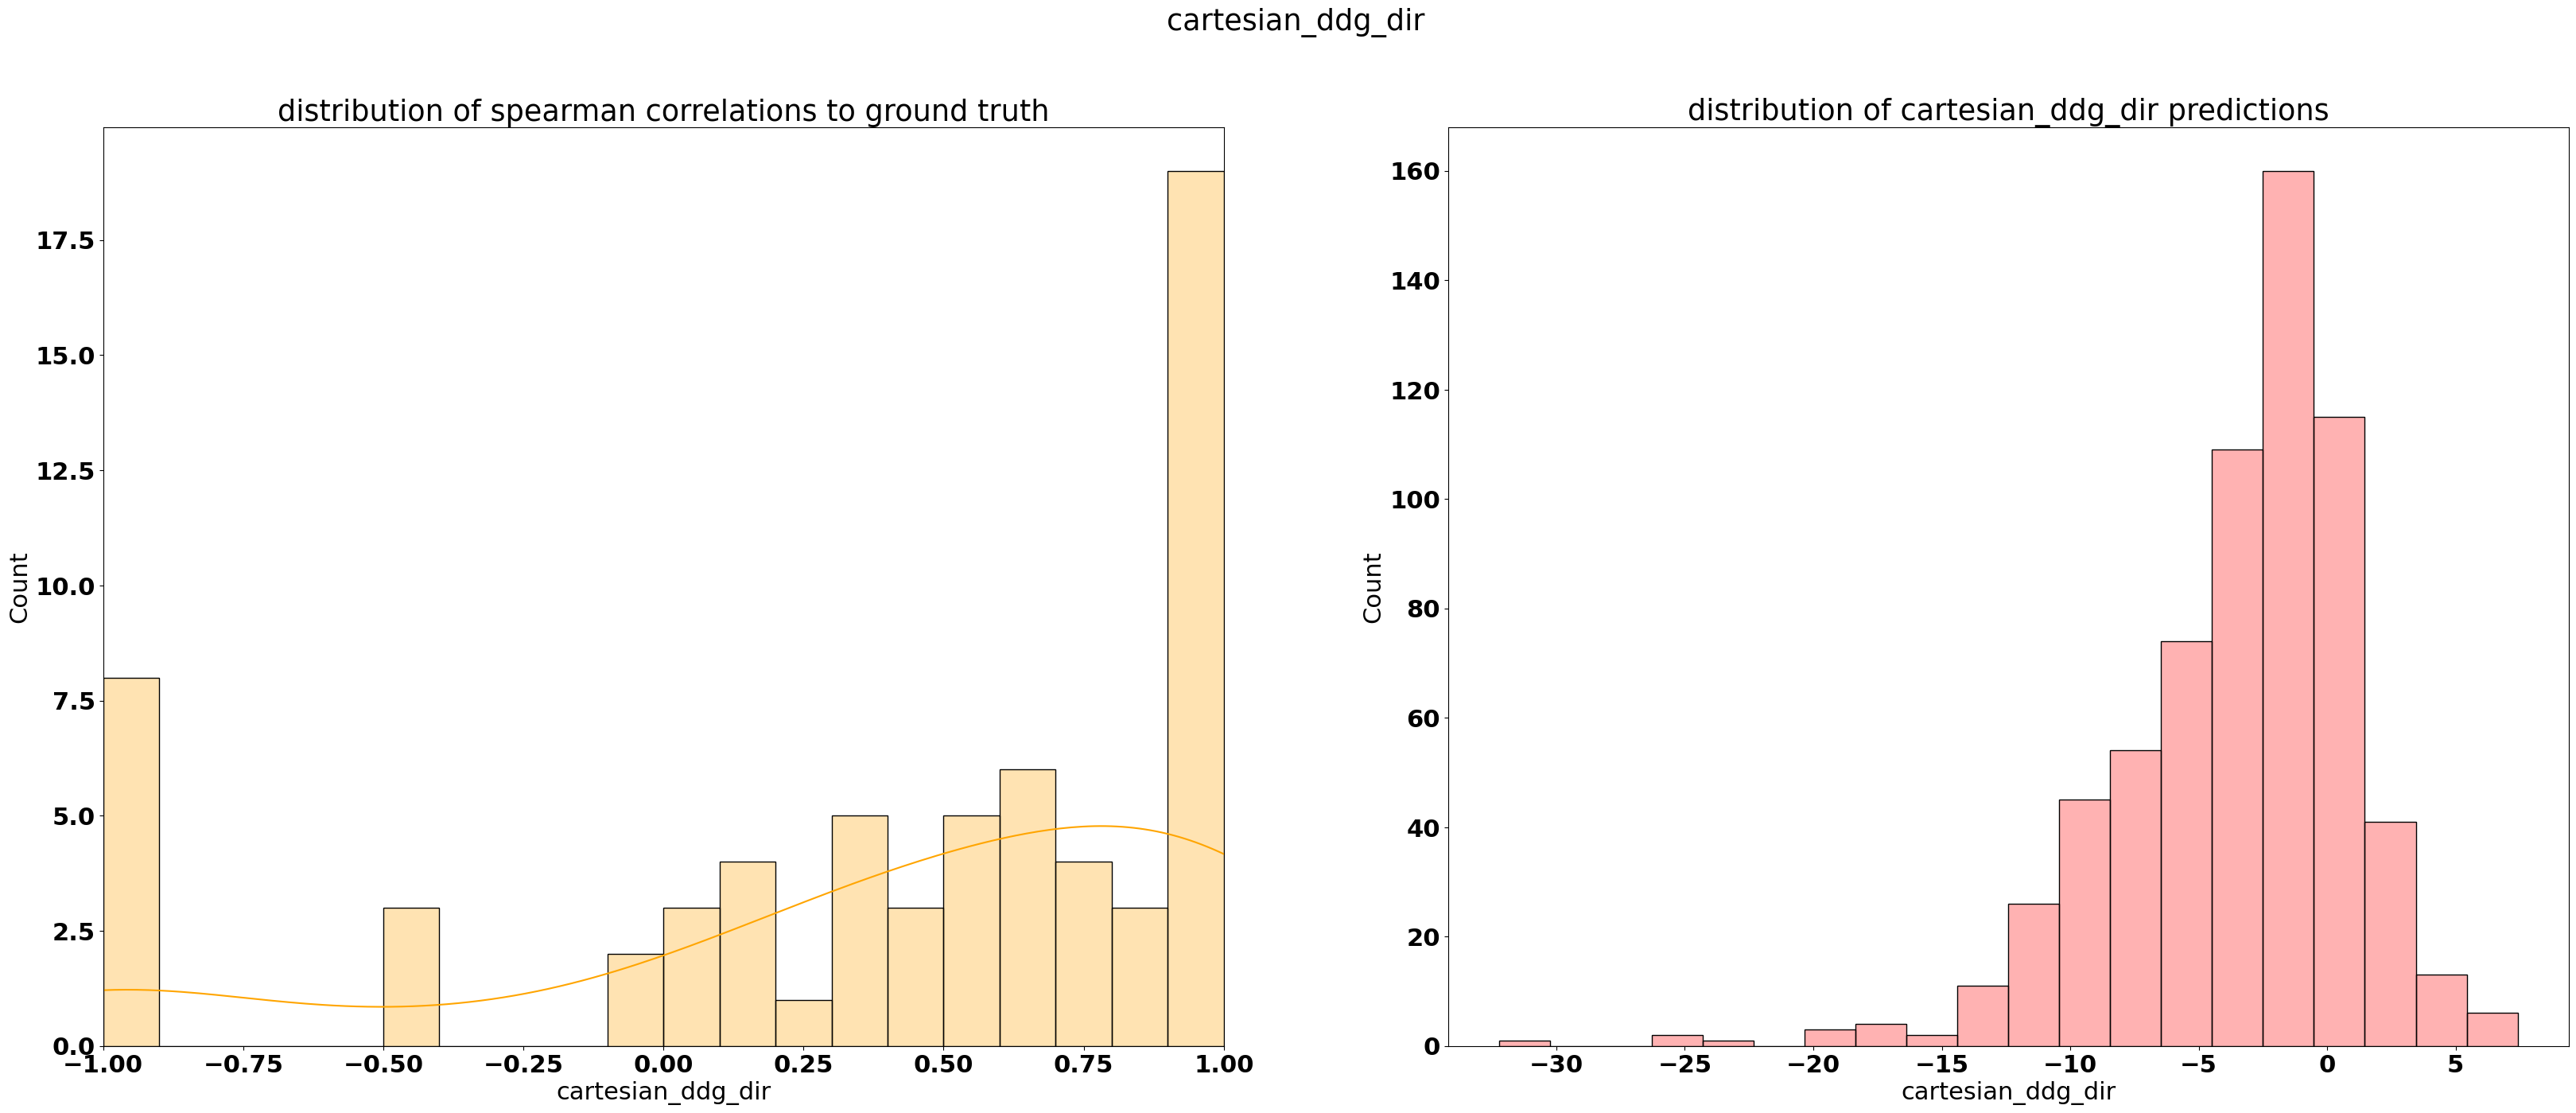

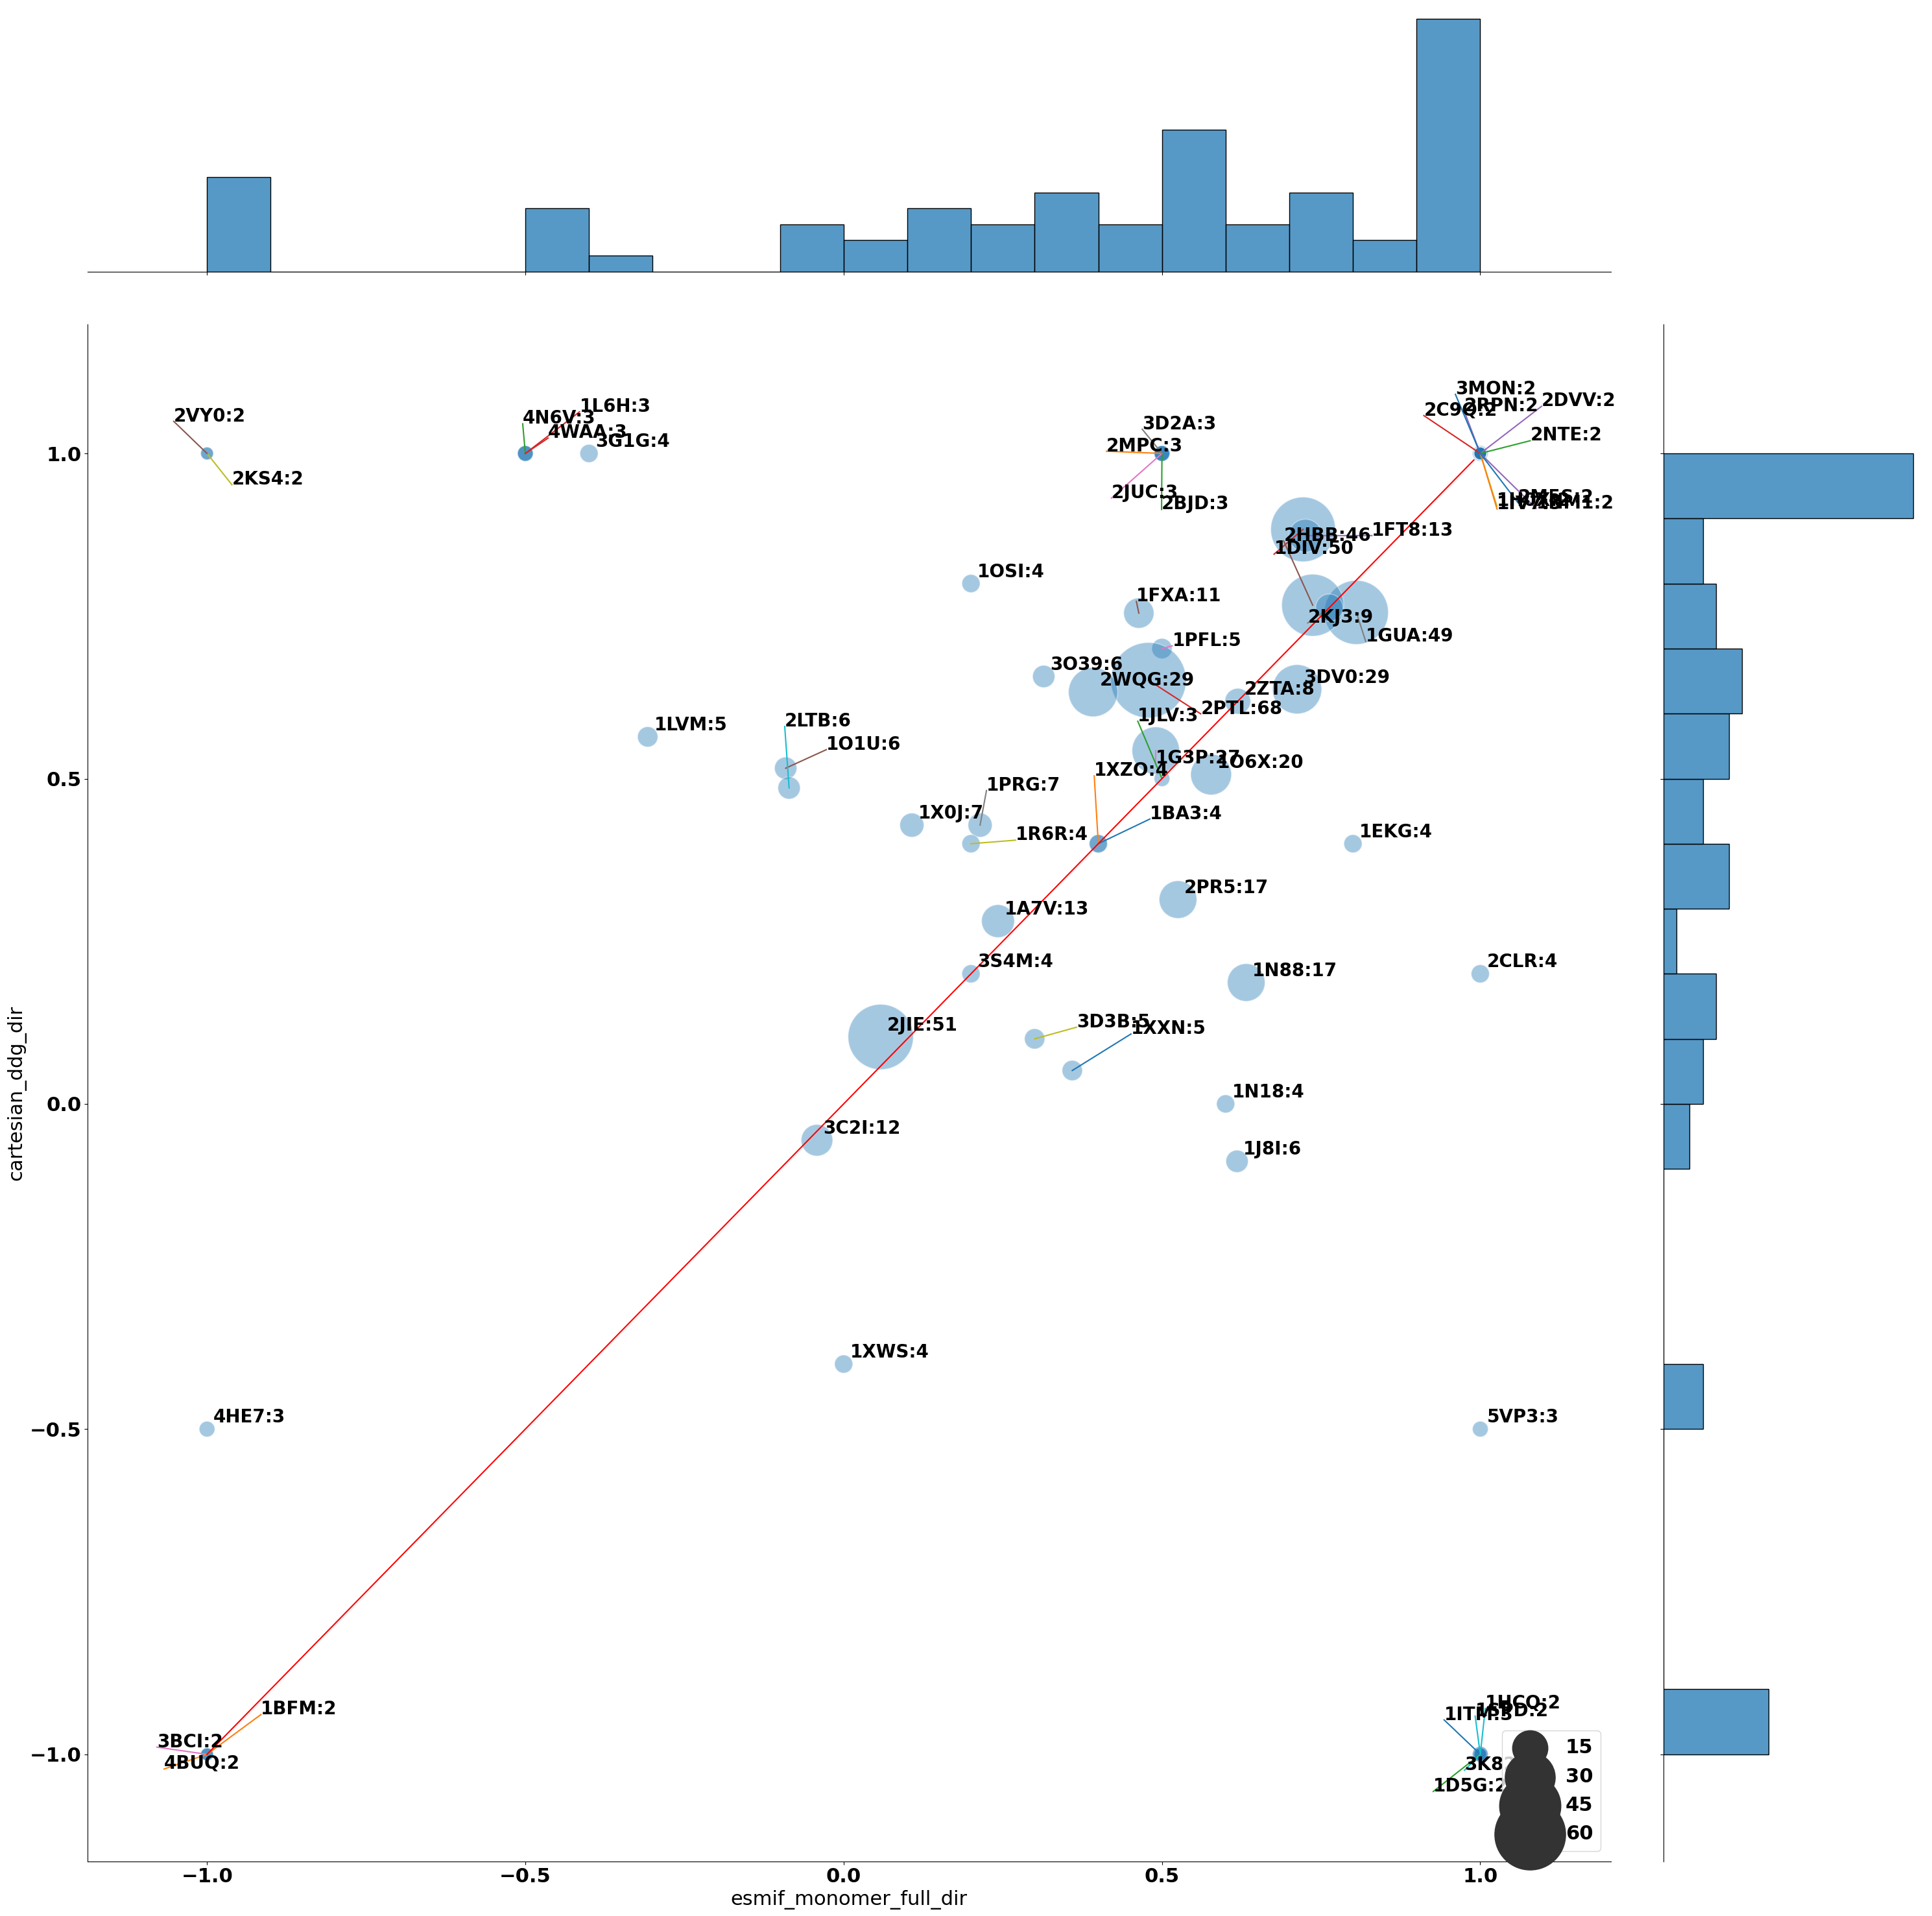

cartesian_ddg_dir  esmif_monomer_full_dir
n_total                    667.000000              667.000000
ungrouped_spearman           0.448400                0.367084
n_proteins                  66.000000               66.000000
avg_spearman                 0.393318                0.367105
weighted_spearman            0.450896                0.405830

In [ ]:
score_1 = 'cartesian_ddg_dir'
score_2 = 'esmif_monomer_full_dir'
db_complete = db_preds.join(ddgs, how='left')
correlations(db_complete, score_1, score_name_2=score_2, min_obs=2, corr='spearman', plot=True, out=True, full=False)

In [ ]:
#min_obs=2
#corrs = [correlations(dfm, col, min_obs=min_obs, corr='spearman', out=True, plot=False, group=True) for col in models + all_cols] #runtime=True
#d1 = pd.concat(corrs, axis=1)



n  \
direction model_type   model                                  class          
dir       evolutionary ACDC-NN-Seq_dir                               669.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           669.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           669.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             669.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           667.0   
...                                                                    ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        663.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        663.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        663.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        663.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        663.0   

                                                                       tp  \
direction model_type   model                                  class         
dir       evolutionary ACDC-NN-Seq_dir                               51.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           61.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           59.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             59.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           71.0   
...                                                                   ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        48.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        44.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        47.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        48.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        49.0   

                                                                       fp  \
direction model_type   model                                  class         
dir       evolutionary ACDC-NN-Seq_dir                               61.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           77.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           77.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             76.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           93.0   
...                                                                   ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        87.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        87.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        88.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        88.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        92.0   

                                                                        tn  \
direction model_type   model                                  class          
dir       evolutionary ACDC-NN-Seq_dir                               440.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           424.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           424.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             425.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           406.0   
...                                                                    ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        408.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        408.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        407.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        407.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        403.0   

                                       

index  n_total_ddG  \
1               DDGun_dir + esmif_monomer_dir * 0.6        642.0   
3              DDGun_dir + esmif_multimer_dir * 0.6        642.0   
25            DDGun3D_dir + esmif_monomer_dir * 0.6        667.0   
31               INPS3D_dir + esmif_monomer_dir * 1        667.0   
44        I-Mutant3.0_dir + esmif_monomer_dir * 0.6        667.0   
48           DDGun3D_dir + esmif_multimer_dir * 0.6        667.0   
57             INPS3D_dir + esmif_monomer_dir * 0.6        667.0   
65            PremPS_dir + esmif_multimer_dir * 0.2        666.0   
72             PremPS_dir + esmif_monomer_dir * 0.2        666.0   
86       esmif_monomer_dir + esm1v_median_dir * 0.2        669.0   
90           PopMusic_dir + esmif_monomer_dir * 0.6        666.0   
94                DDGun_dir + esmif_monomer_dir * 1        642.0   
97        esmif_monomer_dir + I-Mutant3.0_dir * 0.6        667.0   
98           INPS-Seq_dir + esmif_monomer_dir * 0.6        669.0   
102            INPS-Seq_dir + esmif_monomer_dir * 1        669.0   
105            esmif_monomer_dir + INPS3D_dir * 0.6        667.0   
106           ThermoNet_dir + esmif_monomer_dir * 1        669.0   
107           SOL_ACC_dir + esmif_monomer_dir * 0.2        666.0   
112          PopMusic_dir + esmif_monomer_dir * 0.2        666.0   
113      I-Mutant3.0_dir + esmif_multimer_dir * 0.6        667.0   
124       ACDC-NN-Seq_dir + esmif_monomer_dir * 0.6        669.0   
129           Dynamut_dir + esmif_monomer_dir * 0.6        669.0   
132             INPS3D_dir + esmif_multimer_dir * 1        667.0   
133             PopMusic_dir + mpnn_30_02_dir * 0.6        666.0   
134         ACDC-NN-Seq_dir + esmif_monomer_dir * 1        669.0   
137            MuPro_dir + esmif_multimer_dir * 0.6        669.0   
138              DDGun_dir + esmif_multimer_dir * 1        642.0   
139          esmif_monomer_dir + INPS-Seq_dir * 0.6        669.0   
143           INPS3D_dir + esmif_multimer_dir * 0.6        667.0   
144                  PopMusic_dir + mifst_dir * 0.2        666.0   
145            esmif_monomer_dir + PremPS_dir * 0.6        666.0   
149           MAESTRO_dir + esmif_monomer_dir * 0.6        669.0   
150      esmif_multimer_dir + I-Mutant3.0_dir * 0.6        667.0   
153          Dynamut_dir + esmif_multimer_dir * 0.6        669.0   
156              MuPro_dir + esmif_multimer_dir * 1        669.0   
158             SOL_ACC_dir + esmif_monomer_dir * 1        666.0   
159         INPS-Seq_dir + esmif_multimer_dir * 0.6        669.0   
160           esmif_monomer_dir + DDGun3D_dir * 0.6        667.0   
161           ACDC-NN_dir + esmif_monomer_dir * 0.2        669.0   
162          SOL_ACC_dir + esmif_multimer_dir * 0.2        666.0   
163         esmif_monomer_dir + ThermoNet_dir * 0.6        669.0   
167         PopMusic_dir + esmif_multimer_dir * 0.6        666.0   
169              PremPS_dir + monomer_ddg_dir * 0.2        605.0   
171      ACDC-NN-Seq_dir + esmif_multimer_dir * 0.6        669.0   
172           SOL_ACC_dir + esmif_monomer_dir * 0.6        666.0   
173  esmif_monomer_full_dir + tranception_dir * 0.6        663.0   
174            PremPS_dir + esmif_monomer_dir * 0.6        666.0   
175             INPS-Seq_dir + mpnn_30_02_dir * 0.6        669.0   
177               esmif_monomer_dir + SDM_dir * 0.6        669.0   
178           PremPS_dir + esmif_multimer_dir * 0.6        666.0   

     ungrouped_spearman_ddG  n_proteins_ddG  avg_spearman_ddG  \
1                  0.435928            65.0          0.473069   
3                  0.439269            65.0          0.469439   
25                 0.436368            66.0          0.419131   
31                 0.378720            66.0          0.447979   
44                 0.367666            66.0          0.433344   
48                 0.439964            66.0          0.430142   
57                 0.408902            66.0          0.421152   
65                 0.461127            66.0          0.40

In [ ]:
db_complete = db_preds.join(ddgs, how='left')
#print(db_complete.columns.drop('code'))
dfs = pd.concat([correlations(db_complete, s1, min_obs=2, corr='spearman', plot=False, out=False) for s1 in db_complete.columns.drop(['code', 'ddG'])], axis=1)
#dfs = pd.concat([dfs, correlations(db_complete, 'cartesian_ddg', score_name_2='mpnn', min_obs=2, corr='spearman', plot=False, out=False).drop('mpnn', axis=1)], axis=1)
df_feats = db_feats[['code', 'multimer']].groupby('code').first()
df_out = df_feats.join(dfs, how='inner')
df_out.to_csv('~/OneDrive/s669_correlations.csv')
df_out

df_out#.loc[('1DIV', 50)].tail(40)

#dfs.sort_values('weighted_spearman', ascending=False)

KeyError: "['ddG'] not found in axis"

In [ ]:
'mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'
model1 = 'mif_dir'
model2 = 'esmif_multimer_dir'
model3 = 'esm1v_median_dir'
weight = 1
weight2 = 0.5
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'] = (db_preds[model1] - db_preds[model1].mean()) / db_preds[model1].std()
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'] += (db_preds[model2] - db_preds[model2].mean()) / db_preds[model2].std() * weight
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'] += (db_preds[model3] - db_preds[model3].mean()) / db_preds[model3].std() * weight2

db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'] = (db_preds['mif_inv'] - db_preds['mif_inv'].mean()) / db_preds['mif_inv'].std()
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'] += (db_preds['esmif_monomer_masked_inv'] - db_preds['esmif_monomer_masked_inv'].mean()) / db_preds['esmif_monomer_masked_inv'].std() * weight
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'] += (db_preds['esm1v_median_inv'] - db_preds['esm1v_median_inv'].mean()) / db_preds['esm1v_median_inv'].std() * weight2

db_preds
c1 = 'mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'
c2 = 'mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'

db_tmp = db_preds.copy()
#db_tmp['code'] = db_tmp.reset_index(level=1).index.str[:4]
#db_tmp = db_tmp.loc[db_tmp['code']=='2HBB']
sns.scatterplot(data=db_tmp, x=c1, y=c2, legend=False)

print('antisymmetry (should be close to -1)', antisymmetry(db_preds[c1], db_preds[c2]))
print('bias (should be close to 0)', bias(db_preds[c1], db_preds[c2]))

KeyError: 'esmif_monomer_masked_inv'

In [ ]:
db_stack = db_complete.drop('code', axis=1).reset_index(level=1, drop=True).copy(deep=True)
db_stack['ddG_dir'] = db_stack['ddG']
db_stack['ddG_inv'] = -db_stack['ddG']
#db_stack['uid_dir'] = db_stack['uid'] + '_dir'
#db_stack['uid_inv'] = db_stack['uid'] + '_inv'
db_stack = db_stack.drop(['ddG'], axis=1)
#db_stack = db_stack.set_index(['uid_dir', 'uid_inv'])

In [ ]:
db_stack = db_complete.drop('code', axis=1).reset_index(level=1, drop=True).copy(deep=True)
db_stack['ddG_dir'] = db_stack['ddG']
db_stack['ddG_inv'] = -db_stack['ddG']
db_stack = db_stack.drop(['ddG'], axis=1)
df = db_stack.melt(var_name='col', value_name='value', value_vars=db_stack.columns, ignore_index=False)
df = df.reset_index()
df['uid'] = df['uid'] + df['col'].str[-4:]
df = df.set_index('uid')
df['col'] = df['col'].str.extract(r'(.+)_(inv|dir)')[0]
df = df.pivot_table(index=df.index, columns='col', values='value')
df = df.fillna(0)
df.loc[df['ddG']>0, 'ddG']=1
df.loc[df['ddG']<=0, 'ddG']=-1
df.to_csv(os.path.join(path, '..', 's669_binarized_full.csv'))
df_train = df[['esmif_monomer_masked', 'esmif_monomer', 'mpnn', 'mif', 'mifst', 'tranception_retrieval', 'msa_transformer_median', 'esm1v_median', 'ddG']].copy(deep=True)
df_train

col            esmif_monomer_masked  esmif_monomer      mpnn       mif  \
uid                                                                      
1A0F_11A_dir              -2.426234      -3.788848 -1.730592 -4.844778   
1A0F_11A_inv               1.907257       2.373271  1.952918  5.241425   
1A7V_104H_dir             -7.840379      -7.725709 -3.801549 -7.811964   
1A7V_104H_inv              6.709040       7.363378  2.204143  5.643720   
1A7V_13H_dir              -2.774624      -2.694193 -1.023643 -2.775420   
...                             ...            ...       ...       ...   
5VP3_128G_inv             -0.264792       1.112414  3.175077 -3.155340   
5VP3_183T_dir              0.851279      -4.029168 -2.158462 -1.360012   
5VP3_183T_inv             -0.076972      -4.046058 -1.839730 -8.271081   
5VP3_39K_dir              -0.868768      -0.613143 -0.614777 -0.780378   
5VP3_39K_inv               0.813791       1.599584  0.617482  0.752555   

col               mifst  tranception_retrieval  msa_transformer_median  \
uid                                                                      
1A0F_11A_dir  -9.080012              -0.017637               -3.382510   
1A0F_11A_inv   9.144400               0.017637                3.382510   
1A7V_104H_dir -8.982984              -0.025138              -10.578852   
1A7V_104H_inv  8.753647               0.025138               10.578852   
1A7V_13H_dir  -5.796781              -0.030103               -5.768966   
...                 ...                    ...                     ...   
5VP3_128G_inv -1.522461               0.033658                0.305559   
5VP3_183T_dir -4.062951              -0.036415               -1.513407   
5VP3_183T_inv -3.206351               0.036415                1.513407   
5VP3_39K_dir  -0.601453              -0.035424               -0.722602   
5VP3_39K_inv   0.581376               0.035424                0.722602   

col            esm1v_median  ddG  
uid                               
1A0F_11A_dir      -4.153863 -1.0  
1A0F_11A_inv       4.153863  1.0  
1A7V_104H_dir     -7.322962 -1.0  
1A7V_104H_inv      7.322962  1.0  
1A7V_13H_dir      -5.358119 -1.0  
...                     ...  ...  
5VP3_128G_inv     -0.103448  1.0  
5VP3_183T_dir     -1.330562  1.0  
5VP3_183T_inv      1.330562 -1.0  
5VP3_39K_dir      -0.597213  1.0  
5VP3_39K_inv       0.597213 -1.0  

[1338 rows x 9 columns]

In [ ]:
fp = pd.read_csv(os.path.join(path, '..', 'fireprot_preds.csv')).dropna(subset='ddG')
df_test = fp[['esmif_monomer_masked', 'esmif_monomer', 'mpnn', 'mif', 'mifst', 'tranception', 'msa_transformer_median', 'esm1v_median', 'ddG']].rename({'tranception': 'tranception_retrieval'}, axis=1)
df_test = df_test.fillna(0)
df_test['ddG'] = -df_test['ddG'] 
df_test.loc[df_test['ddG']>0, 'ddG']=1
df_test.loc[df_test['ddG']<=0, 'ddG']=-1
df_test

esmif_monomer_masked  esmif_monomer      mpnn       mif     mifst  \
1                -4.403102      -3.892285  2.124438  1.864486 -6.804817   
2                -6.528028      -6.444196  2.916263  1.119251 -7.803186   
3                -4.840798      -4.758171  0.961738 -0.854073 -5.416106   
4                -2.197042      -2.777323  1.001751  1.528646 -3.416625   
5                -3.648285      -3.119000  0.908481  0.348254 -5.095066   
...                    ...            ...       ...       ...       ...   
5857              0.331900       2.399654  0.708933  0.501244  1.537594   
5858             -2.062857      -2.255044 -0.660205 -2.084224 -2.458249   
5859             -0.526189      -2.091975 -1.778232 -0.939917  0.199211   
6264              1.093352       1.259959  0.908896  1.211098  1.239150   
6265             -0.981396       0.482705  2.114213 -0.412503 -3.608728   

      tranception_retrieval  msa_transformer_median  esm1v_median  ddG  
1                 -0.109843               -9.881346    -13.370914 -1.0  
2                 -0.059805              -10.005238    -11.998134  1.0  
3                 -0.032687               -7.933827     -6.640478  1.0  
4                 -0.039248               -6.085909     -7.086007  1.0  
5                 -0.075966               -9.434349     -7.950257 -1.0  
...                     ...                     ...           ...  ...  
5857              -0.051212               -6.589225     -1.168017  1.0  
5858              -0.145734               -7.208587     -2.941263 -1.0  
5859               0.001114                0.787610      0.422119  1.0  
6264              -0.001946               -2.237000     -1.146301  1.0  
6265              -0.004162               -2.819138     -1.658356  1.0  

[5021 rows x 9 columns]

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, Perceptron, RidgeClassifierCV, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB

#rf = RandomForestClassifier(min_samples_split=100, min_samples_leaf=10, n_estimators=100)
rf = LogisticRegressionCV()
#rf = HistGradientBoostingClassifier()
rf.fit(df_train.drop('ddG', axis=1), df_train['ddG'])
predictions = rf.predict(df_test.drop('ddG', axis=1))
truth = df_test['ddG'].to_numpy()

#pd.DataFrame(index=df_test.columns.drop('ddG'), data=rf.feature_importances_)

In [ ]:
fp['LogReg'] = predictions

In [ ]:
fp.to_csv(os.path.join(path, '..', 'fireprot_preds_logreg.csv'))

In [ ]:
import requests
code = '1TUP'
if code in ['1AON', '1GUA', '1GLU', '2CLR', '3MON']:
    entity = 2
elif code in ['1HCQ', '1TUP', '3DV0']:
    entity = 3
else:
    entity = 1
print(entity)
req = f'https://www.ebi.ac.uk/pdbe/graph-api/pdbe_pages/interfaces/{code.lower()}/{entity}'
r = requests.get(req).text.replace('true','True').replace('false','False')
r = eval(r)
r
#df = pd.DataFrame(r[code.lower()]['data'][0]['residues'])
#df

3


{'1tup': {'sequence': 'SSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNT',
  'length': 219,
  'dataType': 'INTERFACE RESIDUES',
  'data': [{'dataType': 'UniProt',
    'accession': 'P04637',
    'name': 'Cellular tumor antigen p53',
    'additionalData': {'bestChainId': 'C', 'entityId': 3},
    'residues': [{'startIndex': 1,
      'endIndex': 2,
      'startCode': 'SER',
      'endCode': 'SER',
      'indexType': 'PDB'},
     {'startIndex': 45,
      'endIndex': 45,
      'startCode': 'ALA',
      'endCode': 'ALA',
      'indexType': 'PDB'},
     {'startIndex': 47,
      'endIndex': 47,
      'startCode': 'THR',
      'endCode': 'THR',
      'indexType': 'PDB'},
     {'startIndex': 78,
      'endIndex': 79,
      'startCode': 'GLU',
      'endCode': 'VAL',
      'indexType': 'PDB'},
     {'startIndex': 81,
      'endInd

In [ ]:
r[code.lower()]['sequence']

'EDKITVHFINRDGETLTTKGKIGDSLLDVVVQNNLDIDGFGACEGTLACSTCHLIFEQHIFEKLEAITDEENDMLDLAYGLTDRSRLGCQICLTKAMDNMTVRVP'

In [ ]:
path2 = '../../s669'

elaspic = pd.DataFrame(index=db.reset_index(level=0)['uid'], columns=['elaspic2_dir'])

item = 'elaspic2'

for (code, chain), _ in db.groupby(['code', 'chain']):
    try:
        new = pd.read_csv(f'{path2}/{code}/{code}_{item}_scores.csv')

        if item in ['protbert', 'proteinsolver', 'elaspic2']:
            new = new.drop('Unnamed: 0', axis=1)

        elaspic.loc[new['uid'], 'elaspic2_dir'] = list(new['el2core'].astype(float))
    except Exception as e:
        print(code)
        print(item)
        print(e)

db_preds = db_preds.reset_index(level=1)
db_preds = db_preds.join(elaspic, how='left')
db_preds['elaspic2_dir'] = -db_preds['elaspic2_dir'].astype(float)
db_preds = db_preds.reset_index().set_index(['uid', 'uid2']).astype(float)
db_preds